In [12]:
import numpy as np
import pywt
import os
import cv2
from PIL import Image
from scipy.fftpack import dct
from scipy.fftpack import idct
from math import log10, sqrt
import matplotlib.pyplot as plt

image = 'images/chihuahua.webp'   
watermark = 'images/watermark.jpg' 

def convert_image(image_name, size):
    img = Image.open(image_name).resize((size, size), 1)
    img = img.convert('L')
    img.save(image_name)

    # image_array = np.array(img)
    # image_array = np.float32(image_array) 
    # image_array /= 255 
    image_array = np.array(img.getdata(), dtype=np.float64).reshape((size, size))
    #print(image_array[0][0])               #qrcode white color = 1.0
    #print(image_array[10][10])             #qrcode black color = 0.0  

    return image_array

def process_coefficients(imArray, model, level):
    #pywt - wavelet transforms in Python: Multilevel 2D Discrete Wavelet Transform.
    coeffs=pywt.wavedec2(data = imArray, wavelet = model, level = level)
    print('Coeffs: ', coeffs[0].__len__())    
    
    coeffs_H=list(coeffs)
    
    return coeffs_H
            
def embed_watermark(watermark_array, orig_image):
    watermark_array_size = watermark_array[0].__len__()
    
    #ravel(): return a contiguous flattened 1D array
    watermark_flat = watermark_array.ravel()
    
    ind = 0

    for x in range (0, orig_image.__len__(), 8):
        for y in range (0, orig_image.__len__(), 8):
            if ind < watermark_flat.__len__():
                subdct = orig_image[x:x+8, y:y+8]
                subdct[5][5] = watermark_flat[ind]
                orig_image[x:x+8, y:y+8] = subdct
                ind += 1 
    return orig_image

def apply_dct(image_array):
    size = image_array[0].__len__()
    all_subdct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subpixels = image_array[i:i+8, j:j+8]
            subdct = dct(dct(subpixels.T, norm="ortho").T, norm="ortho")
            all_subdct[i:i+8, j:j+8] = subdct

    return all_subdct


def inverse_dct(all_subdct):
    size = all_subdct[0].__len__()
    all_subidct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subidct = idct(idct(all_subdct[i:i+8, j:j+8].T, norm="ortho").T, norm="ortho")
            all_subidct[i:i+8, j:j+8] = subidct

    return all_subidct


def get_watermark(dct_watermarked_coeff, watermark_size):
    # watermark = [[0 for x in range(watermark_size)] for y in range(watermark_size)] 

    subwatermarks = []

    for x in range (0, dct_watermarked_coeff.__len__(), 8):
        for y in range (0, dct_watermarked_coeff.__len__(), 8):
            coeff_slice = dct_watermarked_coeff[x:x+8, y:y+8]
            subwatermarks.append(coeff_slice[5][5])

    watermark = np.array(subwatermarks).reshape(watermark_size, watermark_size)

    return watermark


def print_image_from_array(image_array, name):
    # image_array *= 255;
    # image_array =  np.uint8(image_array)
    image_array_copy = image_array.clip(0, 255)
    image_array_copy = image_array_copy.astype("uint8")
    img = Image.fromarray(image_array_copy)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(image_array_copy, cmap='gray')
    plt.title(name)
    plt.axis('off')
    plt.show()
    
def PSNR(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [13]:
import numpy as np, zlib, random

def qim_embed(c, b, Δ):
    q = np.floor(c/Δ)
    return (q + (0.25 if b==0 else 0.75)) * Δ

def qim_extract(c, Δ):
    r = (c/Δ) - np.floor(c/Δ)
    return 1 if r > 0.5 else 0

def to_bits(arr_bin):
    # arr_bin: H×W binary (0/1) np.uint8
    H, W = arr_bin.shape
    header = (H & 0xFFFF) << 16 | (W & 0xFFFF)
    header_bits = [(header >> i) & 1 for i in range(31, -1, -1)]
    payload_bytes = np.packbits(arr_bin.reshape(-1).astype(np.uint8))
    crc = zlib.crc32(payload_bytes) & 0xFFFFFFFF
    crc_bits = [(crc >> i) & 1 for i in range(31, -1, -1)]
    data_bits = np.unpackbits(payload_bytes).tolist()
    return header_bits + crc_bits + data_bits, (H, W)

def from_bits(bits):
    # read header
    header = 0
    for i in range(32): header = (header << 1) | bits[i]
    H = (header >> 16) & 0xFFFF
    W = header & 0xFFFF
    # crc
    crc_rx = 0
    for i in range(32): crc_rx = (crc_rx << 1) | bits[32+i]
    body = bits[64:]
    n_bits = H*W  # binary image
    body = body[:n_bits]  # ignore trailing pad
    payload_bytes = np.packbits(np.array(body, dtype=np.uint8))
    if zlib.crc32(payload_bytes) & 0xFFFFFFFF != crc_rx:
        print("CRC mismatch: watermark may be corrupted")
    wm = np.unpackbits(payload_bytes)[:n_bits].reshape(H, W).astype(np.uint8)
    return wm

def embed_payload_qim(dct_LL, payload_bits, key=1337, Δ=6.0, coeff=(5,5), bits_per_block=1):
    H, W = dct_LL.shape
    nB = (H//8)*(W//8)
    cap = nB * bits_per_block
    if len(payload_bits) > cap:
        raise ValueError(f"Payload {len(payload_bits)}b exceeds capacity {cap}b. "
                         "Downscale/dither watermark or increase bits_per_block.")

    # block order with key
    idx = list(range(nB))
    rnd = random.Random(key); rnd.shuffle(idx)

    dct_mod = dct_LL.copy()
    bx = 0
    for k, b in zip(idx, payload_bits):
        i = (k // (W//8))*8
        j = (k %  (W//8))*8
        u, v = coeff
        c = dct_mod[i+u, j+v]
        dct_mod[i+u, j+v] = qim_embed(c, b, Δ)
        bx += 1
    return dct_mod

def extract_payload_qim(dct_LL, n_bits, key=1337, Δ=6.0, coeff=(5,5), bits_per_block=1):
    H, W = dct_LL.shape
    nB = (H//8)*(W//8)
    if n_bits > nB*bits_per_block:
        raise ValueError("Requested bits exceed capacity.")
    idx = list(range(nB))
    rnd = random.Random(key); rnd.shuffle(idx)
    bits = []
    for k in idx[:n_bits]:
        i = (k // (W//8))*8
        j = (k %  (W//8))*8
        u, v = coeff
        c = dct_LL[i+u, j+v]
        bits.append(qim_extract(c, Δ))
    return bits


Coeffs:  1024


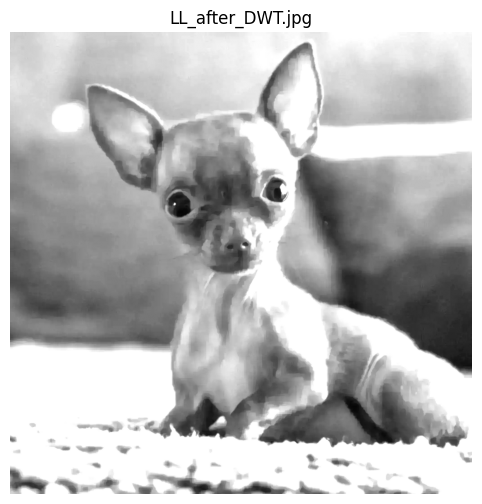

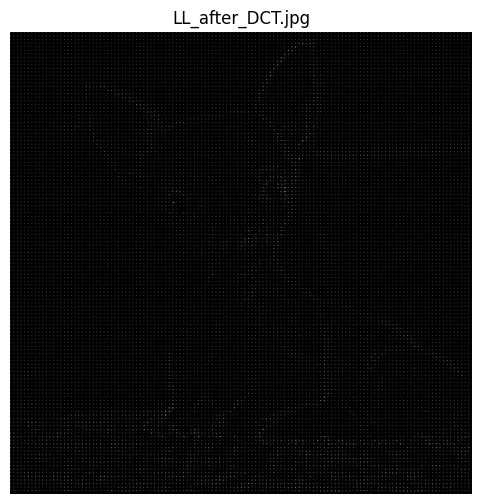

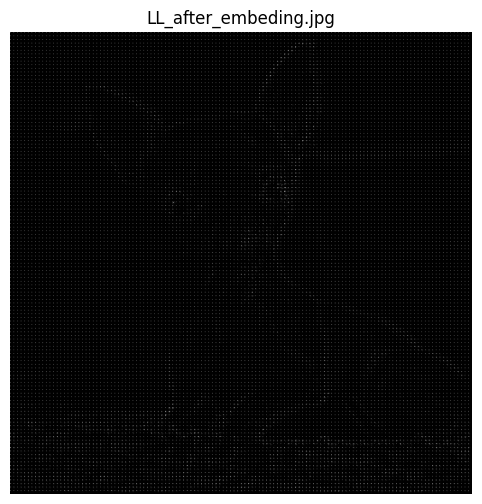

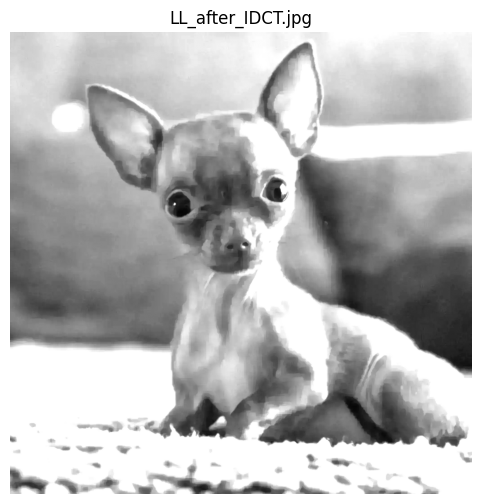

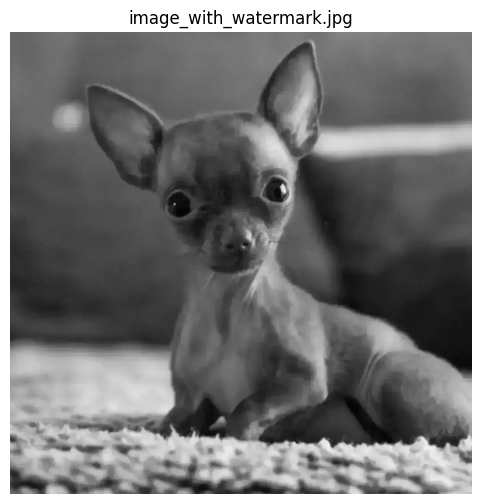

PSNR value is 57.29514277116692 dB
(2048, 2048)
(2048, 2048)
Coeffs:  1024


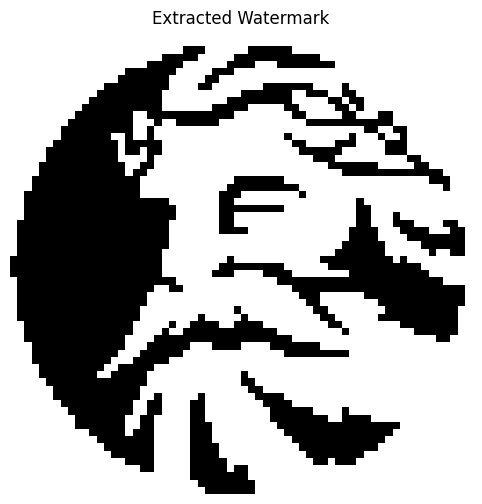

In [29]:
YOUR_KEY = 2025
DELTA = 20.0
COEFF = (5,5)
wm_dimension = 64
model = 'haar'
level = 1
image_array = convert_image(image, 2048)
watermark_array = convert_image(watermark, wm_dimension)
wm_bin  = (watermark_array > 127).astype(np.uint8)

payload_bits, (h,w) = to_bits(wm_bin) ##

coeffs_image = process_coefficients(image_array, model, level=level)
#print('Length of coeffes',len(coeffs_image))

print_image_from_array(coeffs_image[0], 'LL_after_DWT.jpg')

dct_array = apply_dct(coeffs_image[0])
print_image_from_array(dct_array, 'LL_after_DCT.jpg')

dct_array = embed_payload_qim(dct_array, payload_bits, key=YOUR_KEY, Δ=DELTA, coeff=COEFF) ##
print_image_from_array(dct_array, 'LL_after_embeding.jpg')

# dct_array = embed_watermark(watermark_array, dct_array)
# print_image_from_array(dct_array, 'LL_after_embeding.jpg')

coeffs_image[0] = inverse_dct(dct_array)
print_image_from_array(coeffs_image[0], 'LL_after_IDCT.jpg')

#-----------------------------------------------------------------------------------#

# reconstruction
#waverec2 = Multilevel 2D Inverse Discrete Wavelet Transform.
image_array_H=pywt.waverec2(coeffs_image, model)

img = Image.fromarray(image_array_H)

if img.mode != 'L':
    img = img.convert('L')
img.save('./images/x-watermarked.jpg')

# Normalize the reconstructed image
image_array_H = np.clip(image_array_H, 0, 255)

print_image_from_array(image_array_H, 'image_with_watermark.jpg')

#Calculate psnr
original = image_array
watermarked = image_array_H
value = PSNR(original, watermarked)
print('PSNR value is',value, 'dB')

# extract watermark
x_ = Image.open('./images/x-watermarked.jpg').convert('L')
x_arr = np.array(x_.getdata(), dtype=np.float64).reshape((2048, 2048))

print(image_array_H.shape)
print(x_arr.shape)

coeffs_watermarked_image = process_coefficients(image_array_H, model, level=level)
dct_watermarked_coeff = apply_dct(coeffs_watermarked_image[0])

# # pass 64 bits first to read header (width/height + CRC)
# bits64 = extract_payload_qim(dct_watermarked_coeff, 64, key=YOUR_KEY, Δ=DELTA, coeff=COEFF)

# # parse header
# hdr = 0
# for i in range(32): hdr = (hdr << 1) | bits64[i]
# H = (hdr >> 16) & 0xFFFF
# W = hdr & 0xFFFF
# crc_hdr = 0
# for i in range(32): crc_hdr = (crc_hdr << 1) | bits64[32 + i]

# n_total = 64 + H * W          # exact length
# print(n_total, H, W)
n_total = 64 + (64 * 64)
bits = extract_payload_qim(dct_watermarked_coeff, n_total, key=YOUR_KEY, Δ=DELTA, coeff=COEFF)
wm = from_bits(bits)          # your existing function
wm_display = (wm * 255).astype(np.uint8)
print_image_from_array(wm_display, "Extracted Watermark")

### Refine

In [ ]:
import numpy as np, zlib, random
import pywt
import os
import cv2
from PIL import Image
from scipy.fftpack import dct
from scipy.fftpack import idct
from math import log10, sqrt
import matplotlib.pyplot as plt

# robustness knobs
REPEAT = 4                  # replicate each bit this many times (fits 4096*4 = 16384 blocks in LL)
COEFFS = [(5,5), (4,5)]    # use 2 coeffs/block; you can add (5,4), (3,6) to go up to 4
BANDS = ["LL", "LH", "HL"]# embed the same payload in three subbands
DELTA = 20.0              # you already use 20; for JPEG Q≈75 try 24–36, tune by PSNR/SSIM
KEY = 2025


def PSNR(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

# --- YCbCr helpers (no host resize) ---
def load_rgb_keep_size(path):
    im = Image.open(path).convert("RGB")
    ycbcr = im.convert("YCbCr")
    Y  = np.array(ycbcr.getchannel(0), dtype=np.float64)
    Cb = np.array(ycbcr.getchannel(1), dtype=np.uint8)
    Cr = np.array(ycbcr.getchannel(2), dtype=np.uint8)
    return Y, Cb, Cr, im.size  # size=(W,H)

def save_rgb_from_y(Y, Cb, Cr, out_path):
    Y8 = np.rint(np.clip(Y, 0, 255)).astype(np.uint8)
    ycbcr = Image.merge("YCbCr", (Image.fromarray(Y8), Image.fromarray(Cb), Image.fromarray(Cr)))
    rgb = ycbcr.convert("RGB")
    rgb.save(out_path)  # use PNG/TIFF for lossless baseline

def image_to_array(image_name):
    img = Image.open(image_name)
    img = img.convert('L')
    image_array = np.array(img.getdata(), dtype=np.float64)

    return image_array

def qim_embed(c, b, Δ):
    q = np.floor(c/Δ)
    return (q + (0.25 if b==0 else 0.75)) * Δ

def qim_extract(c, Δ):
    r = (c/Δ) - np.floor(c/Δ)
    return 1 if r > 0.5 else 0

def dwt2(img, wavelet='haar', level=1, mode='periodization'):
    return pywt.wavedec2(img, wavelet=wavelet, level=level, mode=mode)

def idwt2(coeffs, wavelet='haar', mode='periodization'):
    return pywt.waverec2(coeffs, wavelet=wavelet, mode=mode)

def subband_dict(coeffs):
    # coeffs = [LL, [(LH1,HL1,HH1), (LH2,HL2,HH2), ...]]
    d = {"LL": coeffs[0]}
    for lvl, (LH, HL, HH) in enumerate(coeffs[1:], start=1):
        if lvl == 1:
            d["LH"], d["HL"], d["HH"] = LH, HL, HH
    return d  # only level-1 bands used here

def set_subband(coeffs, band, arr):
    if band == "LL": coeffs[0] = arr; return
    if band == "LH": coeffs[1] = (arr, coeffs[1][1], coeffs[1][2]); return
    if band == "HL": coeffs[1] = (coeffs[1][0], arr, coeffs[1][2]); return
    if band == "HH": coeffs[1] = (coeffs[1][0], coeffs[1][1], arr); return

def make_indices(H, W, n_bits, repeat, key):
    """Return a list of lists: for bit i, a list of block indices where it is embedded."""
    nB = (H//8)*(W//8)
    idx = list(range(nB))
    rng = random.Random(key)
    rng.shuffle(idx)
    need = n_bits * repeat
    if need > nB:
        raise ValueError(f"Need {need} blocks but only {nB} available")
    # slice in chunks of 'repeat'
    groups = [idx[i*repeat:(i+1)*repeat] for i in range(n_bits)]
    return groups

def apply_dct(image_array):
    size = image_array[0].__len__()
    all_subdct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subpixels = image_array[i:i+8, j:j+8]
            subdct = dct(dct(subpixels.T, norm="ortho").T, norm="ortho")
            all_subdct[i:i+8, j:j+8] = subdct

    return all_subdct

def inverse_dct(all_subdct):
    size = all_subdct[0].__len__()
    all_subidct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subidct = idct(idct(all_subdct[i:i+8, j:j+8].T, norm="ortho").T, norm="ortho")
            all_subidct[i:i+8, j:j+8] = subidct

    return all_subidct

def qimb_embed_coeff(c, b, Δ):
    q = np.floor(c/Δ)
    return (q + (0.25 if b==0 else 0.75)) * Δ

def qimb_llr(c, Δ):
    """Soft info: +ve means '1' more likely, -ve means '0' more likely."""
    x = c/Δ
    frac = x - np.floor(x)
    # distance to 0-bin center (0.25) vs 1-bin center (0.75)
    d0 = abs(frac - 0.25)
    d1 = abs(frac - 0.75)
    return d0 - d1  # <0 → 0 closer; >0 → 1 closer

def majority_vote(votes):
    return 1 if sum(votes) >= (len(votes)/2) else 0

def soft_vote(llrs):
    return 1 if np.sum(llrs) > 0 else 0

def embed_bits_multiband(image_array, bits, key=KEY, Δ=DELTA, coeffs_uv=COEFFS, bands=BANDS, wavelet='haar', level=1):
    coeffs = dwt2(image_array, wavelet, level)
    bands_map = subband_dict(coeffs)

    for band in bands:
        SB = bands_map[band]
        H, W = SB.shape
        # DCT per 8x8 block
        D = apply_dct(SB)  # your existing function
        # indices for repetition
        groups = make_indices(H, W, n_bits=len(bits), repeat=REPEAT, key=hash((key, band)))
        # embed
        for bit_idx, where_list in enumerate(groups):
            b = bits[bit_idx]
            for k in where_list:
                i = (k // (W//8))*8
                j = (k %  (W//8))*8
                for (u,v) in coeffs_uv:
                    D[i+u, j+v] = qimb_embed_coeff(D[i+u, j+v], b, Δ)
        # back to pixel domain of subband
        SB_mod = inverse_dct(D)
        bands_map[band] = SB_mod

    # write back bands and reconstruct
    for band in bands:
        set_subband(coeffs, band, bands_map[band])
    watermarked = idwt2(coeffs, wavelet)
    return watermarked

def extract_bits_multiband(image_array, n_bits, key=KEY, Δ=DELTA, coeffs_uv=COEFFS, bands=BANDS, wavelet='haar', level=1):
    coeffs = dwt2(image_array, wavelet, level)
    bands_map = subband_dict(coeffs)
    votes_per_bit = [[] for _ in range(n_bits)]      # hard votes
    softs_per_bit = [[] for _ in range(n_bits)]      # soft LLRs

    for band in bands:
        SB = bands_map[band]
        H, W = SB.shape
        D = apply_dct(SB)
        groups = make_indices(H, W, n_bits=n_bits, repeat=REPEAT, key=hash((key, band)))

        for bit_idx, where_list in enumerate(groups):
            for k in where_list:
                i = (k // (W//8))*8
                j = (k %  (W//8))*8
                # fuse multiple coeffs in the block with soft information
                llrs = []
                hards = []
                for (u,v) in coeffs_uv:
                    c = D[i+u, j+v]
                    llr = qimb_llr(c, Δ)
                    llrs.append(llr)
                    hards.append(1 if llr>0 else 0)
                # vote within the block (coeff-level), then across repetitions
                votes_per_bit[bit_idx].append(majority_vote(hards))
                softs_per_bit[bit_idx].append(np.sum(llrs))

    # final bit by soft vote, fallback to hard majority
    out_bits = []
    for hard_group, soft_group in zip(votes_per_bit, softs_per_bit):
        if np.any(np.array(soft_group) != 0):
            out_bits.append(soft_vote(soft_group))
        else:
            out_bits.append(majority_vote(hard_group))
    return out_bits

def normalize_and_extract(attacked_img_path, base_size=(2048,2048), scales=(1.0,)):
    # load attacked (could be JPEG, resized, cropped)
    img = Image.open(attacked_img_path).convert('L')
    arr0 = np.array(img, dtype=np.float64)

    best_bits = None
    best_score = -1
    for s in scales:
        # scale to canonical size (handles resize & crop reasonably)
        target = (int(base_size[0]), int(base_size[1]))
        # if image is smaller due to crop, upscale directly to base
        arr = np.array(Image.fromarray(arr0.astype(np.uint8)).resize(target, Image.BICUBIC), dtype=np.float64)

        bits = extract_bits_multiband(arr, n_bits=wm_dimension*wm_dimension,
                                      key=YOUR_KEY, Δ=DELTA,
                                      coeffs_uv=COEFFS, bands=BANDS,
                                      wavelet=model, level=level)
        # consistency score: how confident the voting was (close to 0/1 extremes)
        score = sum(1 if b in (0,1) else 0 for b in bits)  # trivial; or compute agreement rate from internals
        if score > best_score:
            best_score, best_bits = score, bits

    wm = np.array(best_bits, dtype=np.uint8).reshape(wm_dimension, wm_dimension)
    return wm


4096 bits in payload


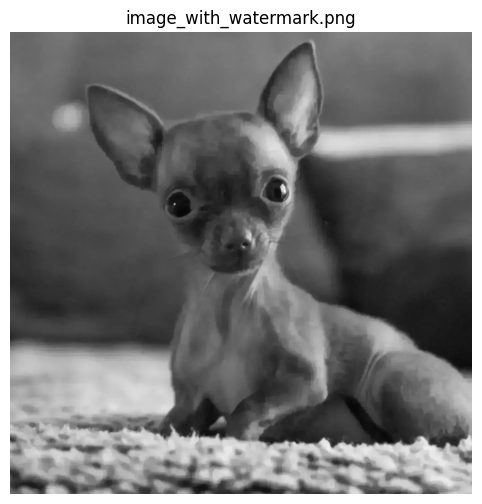

In [34]:
# --- build binary payload of fixed 64x64 (no header/CRC) ---
wm_bin  = (watermark_array > 127).astype(np.uint8)
payload_bits = wm_bin.reshape(-1).tolist()
print(len(payload_bits), "bits in payload")

# --- embed in 3 bands with repetition+multi-coeff ---
image_array_H = embed_bits_multiband(
    image_array, payload_bits, key=KEY, Δ=DELTA,
    coeffs_uv=COEFFS, bands=BANDS, wavelet=model, level=level
)

# save lossless for baseline tests; later you can save JPEG to test robustness
Image.fromarray(np.rint(np.clip(image_array_H,0,255)).astype(np.uint8)).save('./images/x-watermarked.png')
print_image_from_array(image_array_H, 'image_with_watermark.png')

In [35]:
image_array = image_to_array('./images/x-watermarked.png')

bits = extract_bits_multiband(image_array, n_bits=64*64, key=KEY, Δ=DELTA, coeffs_uv=COEFFS, bands=BANDS, wavelet=model, level=level)
wm = np.array(bits, dtype=np.uint8).reshape(wm_dimension, wm_dimension)
wm_display = (wm * 255).astype(np.uint8)
print_image_from_array(wm_display, "Extracted_Watermark")

ValueError: Expected input data to have at least 2 dimensions.

In [ ]:
# try a tiny scale sweep around 1.0 if you expect resizing; keep (1.0,) if not needed
scales = (1.0,)  # or (0.9, 0.95, 1.0, 1.05, 1.1)
wm = normalize_and_extract('./images/x-watermarked.png', base_size=(2048,2048), scales=scales)

wm_display = (wm * 255).astype(np.uint8)
print_image_from_array(wm_display, "Extracted_Watermark")


# XXX

In [2]:
# DWT–DCT QIM Watermarking
import os
import io
import math
import numpy as np
from PIL import Image
import pywt
from scipy.fftpack import dct, idct

# ===============================
# Utility: PSNR
# ===============================

def psnr(img_a: np.ndarray, img_b: np.ndarray) -> float:
    a = img_a.astype(np.float64)
    b = img_b.astype(np.float64)
    mse = np.mean((a - b) ** 2)
    if mse <= 1e-12:
        return 100.0
    return 20.0 * math.log10(255.0 / math.sqrt(mse))

# ===============================
# I/O: Keep original size, support color via YCbCr (embed only in Y)
# ===============================

def load_rgb_keep_size(path: str):
    im = Image.open(path).convert("RGB")
    ycbcr = im.convert("YCbCr")
    Y  = np.array(ycbcr.getchannel(0), dtype=np.float64)
    Cb = np.array(ycbcr.getchannel(1), dtype=np.uint8)
    Cr = np.array(ycbcr.getchannel(2), dtype=np.uint8)
    return Y, Cb, Cr, im.size  # size=(W,H)


def save_rgb_from_y(Y: np.ndarray, Cb: np.ndarray, Cr: np.ndarray, out_path: str):
    Y8 = np.rint(np.clip(Y, 0, 255)).astype(np.uint8)
    ycbcr = Image.merge(
        "YCbCr",
        (Image.fromarray(Y8), Image.fromarray(Cb), Image.fromarray(Cr))
    )
    rgb = ycbcr.convert("RGB")
    rgb.save(out_path)

# ===============================
# DWT helpers (stable boundary handling)
# ===============================

def dwt2(img: np.ndarray, wavelet: str = 'haar', level: int = 1, mode: str = 'periodization'):
    return pywt.wavedec2(img, wavelet=wavelet, level=level, mode=mode)


def idwt2(coeffs, wavelet: str = 'haar', mode: str = 'periodization'):
    return pywt.waverec2(coeffs, wavelet=wavelet, mode=mode)


def subband_dict(coeffs):
    # coeffs = [LL, (LH1,HL1,HH1), (LH2,HL2,HH2), ...]. We only use level-1 detail bands here.
    d = {"LL": coeffs[0]}
    LH1, HL1, HH1 = coeffs[1]
    d["LH"], d["HL"], d["HH"] = LH1, HL1, HH1
    return d


def set_subband(coeffs, band: str, arr: np.ndarray):
    LH1, HL1, HH1 = coeffs[1]
    if band == "LL":
        coeffs[0] = arr
    elif band == "LH":
        coeffs[1] = (arr, HL1, HH1)
    elif band == "HL":
        coeffs[1] = (LH1, arr, HH1)
    elif band == "HH":
        coeffs[1] = (LH1, HL1, arr)

# ===============================
# Block DCT with automatic padding to multiple of 8 (no host resize)
# ===============================

def dct8x8_full(arr: np.ndarray):
    H, W = arr.shape
    H8 = (H + 7) // 8 * 8
    W8 = (W + 7) // 8 * 8
    pad = np.pad(arr, ((0, H8 - H), (0, W8 - W)), mode='edge').astype(np.float64)
    D = np.empty((H8, W8), dtype=np.float64)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = pad[i:i+8, j:j+8]
            D[i:i+8, j:j+8] = dct(dct(blk.T, norm="ortho").T, norm="ortho")
    return D, H, W  # keep original size to trim back later


def idct8x8_full(D: np.ndarray, H: int, W: int):
    H8, W8 = D.shape
    rec = np.empty_like(D)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = D[i:i+8, j:j+8]
            rec[i:i+8, j:j+8] = idct(idct(blk.T, norm="ortho").T, norm="ortho")
    return rec[:H, :W]

# ===============================
# QIM primitives (no header/CRC)
# ===============================

def qim_embed(c: float, b: int, Delta: float) -> float:
    q = np.floor(c / Delta)
    return (q + (0.25 if b == 0 else 0.75)) * Delta


def qim_llr(c: float, Delta: float) -> float:
    x = c / Delta
    frac = x - np.floor(x)
    # positive => bit=1 closer (0.75), negative => bit=0 closer (0.25)
    return abs(frac - 0.25) - abs(frac - 0.75)

# ===============================
# Tiling (for crop robustness)
# ===============================

def tile_slices(H: int, W: int, tiles=(2, 2)):
    tr, tc = tiles
    # vertical cuts
    hs = [0] + [ (H * r) // tr for r in range(1, tr) ] + [H]
    # horizontal cuts
    ws = [0] + [ (W * c) // tc for c in range(1, tc) ] + [W]
    out = []
    for r in range(tr):
        for c in range(tc):
            r0, r1 = hs[r], hs[r+1]
            c0, c1 = ws[c], ws[c+1]
            out.append((slice(r0, r1), slice(c0, c1), r, c))
    return out

# ===============================
# Multi-band, multi-coeff, tiled QIM embed without header/CRC
# ===============================

BAND_TAG = {"LL": 101, "LH": 102, "HL": 103, "HH": 104}


def embed_bits_tiled_Y(
    Y: np.ndarray,
    bits: list,
    key: int,
    Delta: float,
    coeffs_uv=((5,5), (4,5)),
    bands=("LL", "LH", "HL"),
    wavelet='haar',
    level=1,
    tiles=(2, 2),
    repeat=0,            # 0 = auto-fill per tile capacity
):
    coeffs = dwt2(Y, wavelet, level)
    bands_map = subband_dict(coeffs)

    for band in bands:
        SB = bands_map[band]
        for slr, slc, tr, tc in tile_slices(*SB.shape, tiles=tiles):
            tile = SB[slr, slc]
            D, H0, W0 = dct8x8_full(tile)
            H8, W8 = D.shape
            n_rows, n_cols = H8 // 8, W8 // 8
            nB = n_rows * n_cols
            n_bits = len(bits)

            # compute repetition to fill this tile's capacity
            rep = repeat if repeat > 0 else max(1, nB // n_bits)
            need = n_bits * rep
            if need > nB:
                rep = max(1, nB // n_bits)

            # keyed shuffle of block indices in this tile
            seed = (int(key) ^ (int(tr) << 8) ^ (int(tc) << 4) ^ BAND_TAG.get(band, 99)) & 0xFFFFFFFF
            rng = np.random.RandomState(seed)
            idx = np.arange(nB)
            rng.shuffle(idx)

            pos = 0
            for b_idx, b in enumerate(bits):
                for _ in range(rep):
                    if pos >= nB:
                        break
                    k = int(idx[pos]); pos += 1
                    r = k // n_cols; c = k % n_cols
                    i = r * 8; j = c * 8
                    for (u, v) in coeffs_uv:
                        D[i+u, j+v] = qim_embed(D[i+u, j+v], int(b), Delta)

            SB[slr, slc] = idct8x8_full(D, H0, W0)

        bands_map[band] = SB

    # write back & reconstruct
    for band in bands:
        set_subband(coeffs, band, bands_map[band])
    Yw = idwt2(coeffs, wavelet)
    return Yw

# ===============================
# Multi-band, multi-coeff, tiled QIM extraction with soft voting
# ===============================

def extract_bits_tiled_Y(
    Y: np.ndarray,
    n_bits: int,
    key: int,
    Delta: float,
    coeffs_uv=((5,5), (4,5)),
    bands=("LL", "LH", "HL"),
    wavelet='haar',
    level=1,
    tiles=(2, 2),
):
    coeffs = dwt2(Y, wavelet, level)
    bands_map = subband_dict(coeffs)

    soft_acc = np.zeros(n_bits, dtype=np.float64)

    for band in bands:
        SB = bands_map[band]
        for slr, slc, tr, tc in tile_slices(*SB.shape, tiles=tiles):
            tile = SB[slr, slc]
            D, H0, W0 = dct8x8_full(tile)
            H8, W8 = D.shape
            n_rows, n_cols = H8 // 8, W8 // 8
            nB = n_rows * n_cols

            # derive same pseudo layout as embed (auto rep)
            rep = max(1, nB // n_bits)
            seed = (int(key) ^ (int(tr) << 8) ^ (int(tc) << 4) ^ BAND_TAG.get(band, 99)) & 0xFFFFFFFF
            rng = np.random.RandomState(seed)
            idx = np.arange(nB)
            rng.shuffle(idx)

            pos = 0
            for b_idx in range(n_bits):
                s_total = 0.0
                for _ in range(rep):
                    if pos >= nB:
                        break
                    k = int(idx[pos]); pos += 1
                    r = k // n_cols; c = k % n_cols
                    i = r * 8; j = c * 8
                    for (u, v) in coeffs_uv:
                        s_total += qim_llr(D[i+u, j+v], Delta)
                soft_acc[b_idx] += s_total

    out_bits = (soft_acc >= 0).astype(np.uint8).tolist()
    return out_bits

# ===============================
# Attacks (optional): JPEG, resize, crop — for testing robustness only
# ===============================

def save_jpeg(input_path: str, out_path: str, quality: int = 75):
    Image.open(input_path).convert("RGB").save(out_path, quality=quality, subsampling=0, optimize=False)


def save_resized(input_path: str, out_path: str, scale: float):
    im = Image.open(input_path).convert("RGB")
    W, H = im.size
    im2 = im.resize((max(1, int(W*scale)), max(1, int(H*scale))), Image.BICUBIC)
    im2.save(out_path)


def save_cropped(input_path: str, out_path: str, crop_ratio: float = 0.8):
    """Center crop to given ratio (0<ratio<=1)."""
    im = Image.open(input_path).convert("RGB")
    W, H = im.size
    cw, ch = int(W * crop_ratio), int(H * crop_ratio)
    left = (W - cw) // 2
    top  = (H - ch) // 2
    box = (left, top, left + cw, top + ch)
    im2 = im.crop(box)
    im2.save(out_path)

# ===============================
# Demo / Main
# ===============================
if __name__ == "__main__":
    # ---- User paths ----
    HOST_PATH = "./images/chihuahua.webp"   # color image; any size
    WM_PATH   = "./images/watermark.jpg"    # will be binarized to 64x64

    os.makedirs("./result", exist_ok=True)
    os.makedirs("./images", exist_ok=True)

    # ---- Params ----
    KEY     = 2025
    DELTA   = 24.0           # increase to ~28–36 for stronger JPEG robustness
    MODEL   = 'db2'
    LEVEL   = 2
    WM_DIM  = 64
    BANDS   = ("LL", "LH", "HL")
    COEFFS  = ((5,5), (4,5))
    TILES   = (1, 1)         # 2x2 tiling for crop robustness

    # ---- Load host (keep original size), split to YCbCr ----
    Y, Cb, Cr, size = load_rgb_keep_size(HOST_PATH)
    H, W = Y.shape
    print(f"Host Y size: {W}x{H}")

    # ---- Prepare watermark as binary (no header) ----
    wm_gray = Image.open(WM_PATH).convert('L').resize((WM_DIM, WM_DIM), Image.LANCZOS)
    wm_bin  = (np.array(wm_gray, dtype=np.uint8) > 127).astype(np.uint8)
    payload_bits = wm_bin.reshape(-1).tolist()

    # ---- Embed (no resize of host) ----
    Y_wm = embed_bits_tiled_Y(
        Y, payload_bits, key=KEY, Delta=DELTA,
        coeffs_uv=COEFFS, bands=BANDS, wavelet=MODEL, level=LEVEL, tiles=TILES, repeat=0
    )

    # ---- Save color watermarked (lossless PNG for baseline) ----
    WATERMARKED_PATH = "./images/x-watermarked.png"
    save_rgb_from_y(Y_wm, Cb, Cr, WATERMARKED_PATH)

    # ---- Quality check ----
    psnr_val = psnr(Y.astype(np.uint8), np.rint(np.clip(Y_wm,0,255)).astype(np.uint8))
    print(f"PSNR (Y channel) ≈ {psnr_val:.2f} dB")

    # ---- Extract from clean watermarked image (same size, no normalization) ----
    Y2, Cb2, Cr2, _ = load_rgb_keep_size(WATERMARKED_PATH)
    bits_rec = extract_bits_tiled_Y(
        Y2, WM_DIM*WM_DIM, key=KEY, Delta=DELTA,
        coeffs_uv=COEFFS, bands=BANDS, wavelet=MODEL, level=LEVEL, tiles=TILES
    )
    wm_rec = np.array(bits_rec, dtype=np.uint8).reshape(WM_DIM, WM_DIM)
    Image.fromarray((wm_rec*255).astype(np.uint8)).save("./result/Extracted_clean.png")

    # ===============================
    # Optional robustness tests
    # ===============================

    # --- JPEG attack ---
    ATTACK_JPEG = "./images/attack_q75.jpg"
    save_jpeg(WATERMARKED_PATH, ATTACK_JPEG, quality=75)
    Yj, _, _, _ = load_rgb_keep_size(ATTACK_JPEG)
    bits_j = extract_bits_tiled_Y(
        Yj, WM_DIM*WM_DIM, key=KEY, Delta=DELTA,
        coeffs_uv=COEFFS, bands=BANDS, wavelet=MODEL, level=LEVEL, tiles=TILES
    )
    wm_j = np.array(bits_j, dtype=np.uint8).reshape(WM_DIM, WM_DIM)
    Image.fromarray((wm_j*255).astype(np.uint8)).save("./result/Extracted_JPEG_q75.png")

    # --- Resize attack (for test only; your embed path never resizes host) ---
    ATTACK_RESIZE = "./images/attack_resize_0p9.png"
    save_resized(WATERMARKED_PATH, ATTACK_RESIZE, scale=0.9)
    # Note: extraction here assumes same size; if attacker resizes, you may optionally resample back externally
    Yrz, _, _, _ = load_rgb_keep_size(ATTACK_RESIZE)
    bits_rz = extract_bits_tiled_Y(
        Yrz, WM_DIM*WM_DIM, key=KEY, Delta=DELTA,
        coeffs_uv=COEFFS, bands=BANDS, wavelet=MODEL, level=LEVEL, tiles=TILES
    )
    wm_rz = np.array(bits_rz, dtype=np.uint8).reshape(WM_DIM, WM_DIM)
    Image.fromarray((wm_rz*255).astype(np.uint8)).save("./result/Extracted_Resize_0p9.png")

    # --- Crop attack (center crop 80%) ---
    ATTACK_CROP = "./images/attack_crop_0p8.png"
    save_cropped(WATERMARKED_PATH, ATTACK_CROP, crop_ratio=0.8)
    Ycp, _, _, _ = load_rgb_keep_size(ATTACK_CROP)
    bits_cp = extract_bits_tiled_Y(
        Ycp, WM_DIM*WM_DIM, key=KEY, Delta=DELTA,
        coeffs_uv=COEFFS, bands=BANDS, wavelet=MODEL, level=LEVEL, tiles=TILES
    )
    wm_cp = np.array(bits_cp, dtype=np.uint8).reshape(WM_DIM, WM_DIM)
    Image.fromarray((wm_cp*255).astype(np.uint8)).save("./result/Extracted_Crop_0p8.png")

    print("Done. Check ./images and ./result for outputs.")


Host Y size: 2048x2048
PSNR (Y channel) ≈ 48.23 dB
Done. Check ./images and ./result for outputs.


In [34]:
# DWT–DCT QIM Watermarking (Color host, no resize at embed, no header/CRC)
# Robustness via multi-band + multi-coeff embedding, tiling, and majority/soft voting

import os
import io
import math
import cv2
from math import log10, sqrt
import numpy as np
from PIL import Image
import pywt
from scipy.fftpack import dct, idct

# ===============================
# Utility: PSNR
# ===============================

# def psnr(img_a: np.ndarray, img_b: np.ndarray) -> float:
#     a = img_a.astype(np.float64)
#     b = img_b.astype(np.float64)
#     mse = np.mean((a - b) ** 2)
#     if mse <= 1e-12:
#         return 100.0
#     return 20.0 * math.log10(255.0 / math.sqrt(mse))

def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def bit_error_rate(wm_true, wm_pred, threshold=None, return_counts=False):
    """
    BER = (# of differing bits) / (total bits)

    Args:
        wm_true, wm_pred : np.ndarray (same shape). Can be 0/1, 0/255, or grayscale.
        threshold        : if None, auto (127 for 8-bit, 0.5 for [0,1]). 
                           If given, binarize via (x > threshold).
        return_counts    : if True, also return counts dict (tp, tn, fp, fn, etc.)

    Returns:
        ber (float) or (ber, counts_dict) if return_counts=True
    """
    a = np.asarray(wm_true)
    b = np.asarray(wm_pred)
    if a.shape != b.shape:
        raise ValueError(f"Shape mismatch: {a.shape} vs {b.shape}")

    def binarize(x):
        x = np.asarray(x)
        if threshold is not None:
            thr = threshold
        else:
            thr = 0.5 if x.max() <= 1.0 else 127  # auto pick for [0,1] or [0,255]
        return (x > thr).astype(np.uint8)

    a_bin = binarize(a)
    b_bin = binarize(b)

    errors = np.count_nonzero(a_bin ^ b_bin)  # XOR then count 1s
    N = a_bin.size
    ber = errors / N

    if not return_counts:
        return ber

    tp = np.count_nonzero((a_bin == 1) & (b_bin == 1))
    tn = np.count_nonzero((a_bin == 0) & (b_bin == 0))
    fp = np.count_nonzero((a_bin == 0) & (b_bin == 1))
    fn = np.count_nonzero((a_bin == 1) & (b_bin == 0))
    return ber, {"errors": errors, "total": N, "accuracy": 1.0 - ber,
                 "tp": tp, "tn": tn, "fp": fp, "fn": fn}

# ===============================
# I/O: Keep original size, support color via YCbCr (embed only in Y)
# ===============================

def load_rgb_keep_size(path: str):
    im = Image.open(path).convert("RGB")
    ycbcr = im.convert("YCbCr")
    Y  = np.array(ycbcr.getchannel(0), dtype=np.float64)
    Cb = np.array(ycbcr.getchannel(1), dtype=np.uint8)
    Cr = np.array(ycbcr.getchannel(2), dtype=np.uint8)
    return Y, Cb, Cr, im.size  # size=(W,H)


def save_rgb_from_y(Y: np.ndarray, Cb: np.ndarray, Cr: np.ndarray, out_path: str):
    Y8 = np.rint(np.clip(Y, 0, 255)).astype(np.uint8)
    ycbcr = Image.merge(
        "YCbCr",
        (Image.fromarray(Y8), Image.fromarray(Cb), Image.fromarray(Cr))
    )
    rgb = ycbcr.convert("RGB")
    rgb.save(out_path)

# ===============================
# DWT helpers (stable boundary handling)
# ===============================

def dwt2(img: np.ndarray, wavelet: str = 'haar', level: int = 1, mode: str = 'periodization'):
    return pywt.wavedec2(img, wavelet=wavelet, level=level, mode=mode)


def idwt2(coeffs, wavelet: str = 'haar', mode: str = 'periodization'):
    return pywt.waverec2(coeffs, wavelet=wavelet, mode=mode)


def subband_dict(coeffs):
    # coeffs = [LL, (LH1,HL1,HH1), (LH2,HL2,HH2), ...]. We only use level-1 detail bands here.
    d = {"LL": coeffs[0]}
    LH1, HL1, HH1 = coeffs[1]
    d["LH"], d["HL"], d["HH"] = LH1, HL1, HH1
    return d


def set_subband(coeffs, band: str, arr: np.ndarray):
    LH1, HL1, HH1 = coeffs[1]
    if band == "LL":
        coeffs[0] = arr
    elif band == "LH":
        coeffs[1] = (arr, HL1, HH1)
    elif band == "HL":
        coeffs[1] = (LH1, arr, HH1)
    elif band == "HH":
        coeffs[1] = (LH1, HL1, arr)

# ===============================
# Block DCT with automatic padding to multiple of 8 (no host resize)
# ===============================

def dct8x8_full(arr: np.ndarray):
    H, W = arr.shape
    H8 = (H + 7) // 8 * 8
    W8 = (W + 7) // 8 * 8
    pad = np.pad(arr, ((0, H8 - H), (0, W8 - W)), mode='edge').astype(np.float64)
    D = np.empty((H8, W8), dtype=np.float64)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = pad[i:i+8, j:j+8]
            D[i:i+8, j:j+8] = dct(dct(blk.T, norm="ortho").T, norm="ortho")
    return D, H, W  # keep original size to trim back later


def idct8x8_full(D: np.ndarray, H: int, W: int):
    H8, W8 = D.shape
    rec = np.empty_like(D)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = D[i:i+8, j:j+8]
            rec[i:i+8, j:j+8] = idct(idct(blk.T, norm="ortho").T, norm="ortho")
    return rec[:H, :W]

# ===============================
# QIM primitives (no header/CRC)
# ===============================

def qim_embed(c: float, b: int, Delta: float) -> float:
    q = np.floor(c / Delta)
    return (q + (0.25 if b == 0 else 0.75)) * Delta


def qim_llr(c: float, Delta: float) -> float:
    x = c / Delta
    frac = x - np.floor(x)
    # positive => bit=1 closer (0.75), negative => bit=0 closer (0.25)
    return abs(frac - 0.25) - abs(frac - 0.75)

# ===============================
# Tiling (for crop robustness)
# ===============================

def tile_slices(H: int, W: int, tiles=(2, 2)):
    tr, tc = tiles
    # vertical cuts
    hs = [0] + [ (H * r) // tr for r in range(1, tr) ] + [H]
    # horizontal cuts
    ws = [0] + [ (W * c) // tc for c in range(1, tc) ] + [W]
    out = []
    for r in range(tr):
        for c in range(tc):
            r0, r1 = hs[r], hs[r+1]
            c0, c1 = ws[c], ws[c+1]
            out.append((slice(r0, r1), slice(c0, c1), r, c))
    return out

# ===============================
# Multi-band, multi-coeff, tiled QIM embed without header/CRC
# ===============================

BAND_TAG = {"LL": 101, "LH": 102, "HL": 103, "HH": 104}


def embed_bits_tiled_Y(
    Y: np.ndarray,
    bits: list,
    key: int,
    Delta: float,
    coeffs_uv=((5,5), (4,5)),
    bands=("LL", "LH", "HL"),
    wavelet='haar',
    level=1,
    tiles=(2, 2),
    repeat=0,            # 0 = auto-fill per tile capacity
):
    coeffs = dwt2(Y, wavelet, level)
    bands_map = subband_dict(coeffs)

    for band in bands:
        SB = bands_map[band]
        for slr, slc, tr, tc in tile_slices(*SB.shape, tiles=tiles):
            tile = SB[slr, slc]
            D, H0, W0 = dct8x8_full(tile)
            H8, W8 = D.shape
            n_rows, n_cols = H8 // 8, W8 // 8
            nB = n_rows * n_cols
            n_bits = len(bits)

            # compute repetition to fill this tile's capacity
            rep = repeat if repeat > 0 else max(1, nB // n_bits)
            need = n_bits * rep
            if need > nB:
                rep = max(1, nB // n_bits)

            # keyed shuffle of block indices in this tile
            seed = (int(key) ^ (int(tr) << 8) ^ (int(tc) << 4) ^ BAND_TAG.get(band, 99)) & 0xFFFFFFFF
            rng = np.random.RandomState(seed)
            idx = np.arange(nB)
            rng.shuffle(idx)

            pos = 0
            for b_idx, b in enumerate(bits):
                for _ in range(rep):
                    if pos >= nB:
                        break
                    k = int(idx[pos]); pos += 1
                    r = k // n_cols; c = k % n_cols
                    i = r * 8; j = c * 8
                    for (u, v) in coeffs_uv:
                        D[i+u, j+v] = qim_embed(D[i+u, j+v], int(b), Delta)

            SB[slr, slc] = idct8x8_full(D, H0, W0)

        bands_map[band] = SB

    # write back & reconstruct
    for band in bands:
        set_subband(coeffs, band, bands_map[band])
    Yw = idwt2(coeffs, wavelet)
    return Yw

# ===============================
# Multi-band, multi-coeff, tiled QIM extraction with soft voting
# ===============================

def extract_bits_tiled_Y(
    Y: np.ndarray,
    n_bits: int,
    key: int,
    Delta: float,
    coeffs_uv=((5,5), (4,5)),
    bands=("LL", "LH", "HL"),
    wavelet='haar',
    level=1,
    tiles=(2, 2),
):
    coeffs = dwt2(Y, wavelet, level)
    bands_map = subband_dict(coeffs)

    soft_acc = np.zeros(n_bits, dtype=np.float64)

    for band in bands:
        SB = bands_map[band]
        for slr, slc, tr, tc in tile_slices(*SB.shape, tiles=tiles):
            tile = SB[slr, slc]
            D, H0, W0 = dct8x8_full(tile)
            H8, W8 = D.shape
            n_rows, n_cols = H8 // 8, W8 // 8
            nB = n_rows * n_cols

            # derive same pseudo layout as embed (auto rep)
            rep = max(1, nB // n_bits)
            seed = (int(key) ^ (int(tr) << 8) ^ (int(tc) << 4) ^ BAND_TAG.get(band, 99)) & 0xFFFFFFFF
            rng = np.random.RandomState(seed)
            idx = np.arange(nB)
            rng.shuffle(idx)

            pos = 0
            for b_idx in range(n_bits):
                s_total = 0.0
                for _ in range(rep):
                    if pos >= nB:
                        break
                    k = int(idx[pos]); pos += 1
                    r = k // n_cols; c = k % n_cols
                    i = r * 8; j = c * 8
                    for (u, v) in coeffs_uv:
                        s_total += qim_llr(D[i+u, j+v], Delta)
                soft_acc[b_idx] += s_total

    out_bits = (soft_acc >= 0).astype(np.uint8).tolist()
    return out_bits

# ===============================
# Attacks (optional): JPEG, resize, crop — for testing robustness only
# ===============================

def save_jpeg(input_path: str, out_path: str, quality: int = 75):
    Image.open(input_path).convert("RGB").save(out_path, quality=quality, subsampling=0, optimize=False)


def save_resized(input_path: str, out_path: str, scale: float):
    im = Image.open(input_path).convert("RGB")
    W, H = im.size
    im2 = im.resize((max(1, int(W*scale)), max(1, int(H*scale))), Image.BICUBIC)
    im2.save(out_path)


def save_cropped(input_path: str, out_path: str, crop_ratio: float = 0.8):
    """Center crop to given ratio (0<ratio<=1)."""
    im = Image.open(input_path).convert("RGB")
    W, H = im.size
    cw, ch = int(W * crop_ratio), int(H * crop_ratio)
    left = (W - cw) // 2
    top  = (H - ch) // 2
    box = (left, top, left + cw, top + ch)
    im2 = im.crop(box)
    im2.save(out_path)

# ===============================
# Multi-level variant (supports arbitrary LEVEL>=1 without needing huge hosts)
# ===============================

# Key idea: don't restrict to LL only. Use all detail bands across all levels (H/V/D)
# and optionally LL at the deepest level. Total 8x8-block capacity across all levels
# remains ~ (N/8)^2 blocks. So a 512x512 host still fits a 64x64 (4096-bit) payload
# at LEVEL=1..5 without increasing host size. We embed with redundancy (tiling +
# multi-coeff) for robustness, not because of capacity.

# ---- Helpers to traverse all levels ----

def bands_all_levels(coeffs, use_LL=True, use_HV=True, use_D=False):
    """Yield (level_index, band_name, array_ref) with band_name in {LL,H,V,D}.
    level_index: L (deepest) for LL, and L..1 for details.
    """
    out = []
    # coeffs[0] is LL at deepest level L
    L = len(coeffs) - 1
    if use_LL:
        out.append((L, 'LL', coeffs[0]))
    for l in range(L, 0, -1):
        (cH, cV, cD) = coeffs[L - l + 1]  # pywt order is (H, V, D)
        if use_HV:
            out.append((l, 'H', cH))
            out.append((l, 'V', cV))
        if use_D:
            out.append((l, 'D', cD))
    return out


def set_band_at_level(coeffs, level_index, band_name, arr):
    L = len(coeffs) - 1
    if band_name == 'LL':
        coeffs[0] = arr; return
    # details tuple at location corresponding to this level
    idx = L - level_index + 1
    cH, cV, cD = coeffs[idx]
    if band_name == 'H':
        coeffs[idx] = (arr, cV, cD)
    elif band_name == 'V':
        coeffs[idx] = (cH, arr, cD)
    elif band_name == 'D':
        coeffs[idx] = (cH, cV, arr)


# ---- Multi-level embed/extract using all detail bands ----

def embed_bits_tiled_Y_multilevel(
    Y: np.ndarray,
    bits: list,
    key: int,
    Delta: float,
    coeffs_uv=((5,5), (4,5)),
    wavelet='haar',
    level=2,
    tiles=(2,2),
    repeat=0,
    include_LL=False,    # often False for imperceptibility
    include_D=False      # diagonal band optional
):
    # Ensure dimensions are multiples of both 2^level (for DWT) and 8 (for DCT)
    m = 1 << level
    mult = m if m >= 8 else 8
    H0, W0 = Y.shape
    Hm = (H0 + mult - 1) // mult * mult
    Wm = (W0 + mult - 1) // mult * mult
    Ypad = np.pad(Y, ((0, Hm - H0), (0, Wm - W0)), mode='edge')

    coeffs = dwt2(Ypad, wavelet, level)

    # choose bands across all levels
    bands = bands_all_levels(coeffs, use_LL=include_LL, use_HV=True, use_D=include_D)

    for lvl, bname, SB in bands:
        for slr, slc, tr, tc in tile_slices(*SB.shape, tiles=tiles):
            tile = SB[slr, slc]
            D, Ht, Wt = dct8x8_full(tile)
            H8, W8 = D.shape
            n_rows, n_cols = H8 // 8, W8 // 8
            nB = n_rows * n_cols
            n_bits = len(bits)

            rep = repeat if repeat > 0 else max(1, nB // n_bits)
            need = n_bits * rep
            if need > nB:
                rep = max(1, nB // n_bits)

            # keyed per (level, band, tile)
            tag = {'LL':201,'H':202,'V':203,'D':204}[bname]
            seed = (int(key) ^ (int(tr)<<9) ^ (int(tc)<<5) ^ (lvl<<1) ^ tag) & 0xFFFFFFFF
            rng = np.random.RandomState(seed)
            idx = np.arange(nB); rng.shuffle(idx)

            pos = 0
            for b_idx, b in enumerate(bits):
                for _ in range(rep):
                    if pos >= nB: break
                    k = int(idx[pos]); pos += 1
                    r = k // n_cols; c = k % n_cols
                    i = r*8; j = c*8
                    for (u,v) in coeffs_uv:
                        D[i+u, j+v] = qim_embed(D[i+u, j+v], int(b), Delta)

            SB[slr, slc] = idct8x8_full(D, Ht, Wt)
        # write back this band
        set_band_at_level(coeffs, lvl, bname, SB)

    Yw_pad = idwt2(coeffs, wavelet)
    # crop back to original size
    return Yw_pad[:H0, :W0]


def extract_bits_tiled_Y_multilevel(
    Y: np.ndarray,
    n_bits: int,
    key: int,
    Delta: float,
    coeffs_uv=((5,5), (4,5)),
    wavelet='haar',
    level=2,
    tiles=(2,2),
    include_LL=False,
    include_D=False
):
    m = 1 << level
    mult = m if m >= 8 else 8
    H0, W0 = Y.shape
    Hm = (H0 + mult - 1) // mult * mult
    Wm = (W0 + mult - 1) // mult * mult
    Ypad = np.pad(Y, ((0, Hm - H0), (0, Wm - W0)), mode='edge')

    coeffs = dwt2(Ypad, wavelet, level)

    soft_acc = np.zeros(n_bits, dtype=np.float64)

    bands = bands_all_levels(coeffs, use_LL=include_LL, use_HV=True, use_D=include_D)

    for lvl, bname, SB in bands:
        for slr, slc, tr, tc in tile_slices(*SB.shape, tiles=tiles):
            tile = SB[slr, slc]
            D, Ht, Wt = dct8x8_full(tile)
            H8, W8 = D.shape
            n_rows, n_cols = H8 // 8, W8 // 8
            nB = n_rows * n_cols

            rep = max(1, nB // n_bits)
            tag = {'LL':201,'H':202,'V':203,'D':204}[bname]
            seed = (int(key) ^ (int(tr)<<9) ^ (int(tc)<<5) ^ (lvl<<1) ^ tag) & 0xFFFFFFFF
            rng = np.random.RandomState(seed)
            idx = np.arange(nB); rng.shuffle(idx)

            pos = 0
            for b_idx in range(n_bits):
                s_total = 0.0
                for _ in range(rep):
                    if pos >= nB: break
                    k = int(idx[pos]); pos += 1
                    r = k // n_cols; c = k % n_cols
                    i = r*8; j = c*8
                    for (u,v) in coeffs_uv:
                        s_total += qim_llr(D[i+u, j+v], Delta)
                soft_acc[b_idx] += s_total

    out_bits = (soft_acc >= 0).astype(np.uint8).tolist()
    return out_bits

# ===============================
# Demo / Main
# ===============================
if __name__ == "__main__":
    # ---- User paths ----
    HOST_PATH = "./images/cat.webp"   # color host, any size (no resize)
    WM_PATH   = "./images/s.jpg"    # converted to binary 64x64

    os.makedirs("./result", exist_ok=True)
    os.makedirs("./images", exist_ok=True)

    # ---- Params ----
    KEY     = 2025
    DELTA   = 60.0
    MODEL   = 'haar'
    LEVEL   = 4
    WM_DIM  = 64
    # COEFFS  = ((2,2), (2,3), (3,2))
    COEFFS  = ((2,2), (3,3))
    TILES   = (1, 1)

    # ---- Load host (original size) ----
    Y, Cb, Cr, size = load_rgb_keep_size(HOST_PATH)

    # ---- Prepare watermark bits (no header) ----
    wm_gray = Image.open(WM_PATH).convert('L').resize((WM_DIM, WM_DIM), Image.LANCZOS)
    wm_bin  = (np.array(wm_gray, dtype=np.uint8) > 127).astype(np.uint8)
    payload_bits = wm_bin.reshape(-1).tolist()

    # ---- Embed across ALL levels (details) + tiled, no LL for lower visibility ----
    Y_wm = embed_bits_tiled_Y_multilevel(
        Y, payload_bits, key=KEY, Delta=DELTA,
        coeffs_uv=COEFFS, wavelet=MODEL, level=LEVEL,
        tiles=TILES, repeat=0, include_LL=False, include_D=False
    )

    WATERMARKED_PATH = "./images/x-watermarked-ml.png"
    save_rgb_from_y(Y_wm, Cb, Cr, WATERMARKED_PATH)

    # ---- Extract ----
    Y2, Cb2, Cr2, _ = load_rgb_keep_size(WATERMARKED_PATH)
    bits_ml = extract_bits_tiled_Y_multilevel(
        Y2, WM_DIM*WM_DIM, key=KEY, Delta=DELTA,
        coeffs_uv=COEFFS, wavelet=MODEL, level=LEVEL,
        tiles=TILES, include_LL=False, include_D=False
    )

    wm_rec = np.array(bits_ml, dtype=np.uint8).reshape(WM_DIM, WM_DIM)
    Image.fromarray((wm_rec*255).astype(np.uint8)).save("./result/Extracted_MultiLevel.png")

    # --- JPEG attack ---
    ATTACK_JPEG = "./images/attack_q75-Multilevel.jpg"
    save_jpeg(WATERMARKED_PATH, ATTACK_JPEG, quality=75)
    Yj, _, _, _ = load_rgb_keep_size(ATTACK_JPEG)
    bits_j = extract_bits_tiled_Y_multilevel(
        Yj, WM_DIM*WM_DIM, key=KEY, Delta=DELTA,
        coeffs_uv=COEFFS, wavelet=MODEL, level=LEVEL,
        tiles=TILES, include_LL=False, include_D=False
    )

    wm_j = np.array(bits_j, dtype=np.uint8).reshape(WM_DIM, WM_DIM)
    Image.fromarray((wm_j*255).astype(np.uint8)).save("./result/Extracted_JPEG_q75-Multilevel.png")
        
    # --- Resize attack (for test only; your embed path never resizes host) ---
    ATTACK_RESIZE = "./images/attack_resize_0p9.png"
    save_resized(WATERMARKED_PATH, ATTACK_RESIZE, scale=0.9)
    # Note: extraction here assumes same size; if attacker resizes, you may optionally resample back externally
    Yrz, _, _, _ = load_rgb_keep_size(ATTACK_RESIZE)
    bits_rz = extract_bits_tiled_Y_multilevel(
        Yrz, WM_DIM*WM_DIM, key=KEY, Delta=DELTA,
        coeffs_uv=COEFFS, wavelet=MODEL, level=LEVEL,
        tiles=TILES, include_LL=False, include_D=False
    )
    wm_rz = np.array(bits_rz, dtype=np.uint8).reshape(WM_DIM, WM_DIM)
    Image.fromarray((wm_rz*255).astype(np.uint8)).save("./result/Extracted_Resize_0p9.png")

    # --- Crop attack (center crop 80%) ---
    ATTACK_CROP = "./images/attack_crop_0p8.png"
    save_cropped(WATERMARKED_PATH, ATTACK_CROP, crop_ratio=0.8)
    Ycp, _, _, _ = load_rgb_keep_size(ATTACK_CROP)
    bits_cp =  extract_bits_tiled_Y_multilevel(
        Ycp, WM_DIM*WM_DIM, key=KEY, Delta=DELTA,
        coeffs_uv=COEFFS, wavelet=MODEL, level=LEVEL,
        tiles=TILES, include_LL=False, include_D=False
    )
    wm_cp = np.array(bits_cp, dtype=np.uint8).reshape(WM_DIM, WM_DIM)
    Image.fromarray((wm_cp*255).astype(np.uint8)).save("./result/Extracted_Crop_0p8.png")


    print("Multi-level embed/extract completed. Outputs in ./images and ./result.")

    host = cv2.imread(HOST_PATH)
    watermarked = cv2.imread(WATERMARKED_PATH)
    PSNR = psnr(host, watermarked)
    print(f"PSNR: {PSNR:.4f} dB")

    ber, stats = bit_error_rate(wm_bin, wm_rec, return_counts=True)
    print("\nOriginal")
    print(f"BER: {ber:.4f}  |  Acc: {stats['accuracy']:.4f}  |  Errors: {stats['errors']}/{stats['total']}")

    ber, stats = bit_error_rate(wm_j, wm_rec, return_counts=True)
    print("\nJPEG")
    print(f"BER: {ber:.4f}  |  Acc: {stats['accuracy']:.4f}  |  Errors: {stats['errors']}/{stats['total']}")

    ber, stats = bit_error_rate(wm_rz, wm_rec, return_counts=True)
    print("\nResize")
    print(f"BER: {ber:.4f}  |  Acc: {stats['accuracy']:.4f}  |  Errors: {stats['errors']}/{stats['total']}")

    ber, stats = bit_error_rate(wm_cp, wm_rec, return_counts=True)
    print("\nCrop")
    print(f"BER: {ber:.4f}  |  Acc: {stats['accuracy']:.4f}  |  Errors: {stats['errors']}/{stats['total']}")


Multi-level embed/extract completed. Outputs in ./images and ./result.
PSNR: 36.6613 dB

Original
BER: 0.0000  |  Acc: 1.0000  |  Errors: 0/4096

JPEG
BER: 0.0979  |  Acc: 0.9021  |  Errors: 401/4096

Resize
BER: 0.4585  |  Acc: 0.5415  |  Errors: 1878/4096

Crop
BER: 0.4844  |  Acc: 0.5156  |  Errors: 1984/4096


## NEW

In [8]:
# DWT–DCT Watermarking (Color host, no resize at embed, blind)
# Methods:
#   - "QIM_DCT": your original QIM on selected DCT coeffs
#   - "SVD_QIM": Σ-only QIM on SVD of a mid-band patch of each 8×8 DCT block
# Robustness via multi-level DWT + tiling + repetition + soft/majority voting

import os
import math
import cv2
from math import log10, sqrt
import numpy as np
from PIL import Image
import pywt
from scipy.fftpack import dct, idct

# ===============================
# Utility: PSNR & BER
# ===============================

def psnr(img1, img2):
    a = img1.astype(np.float64)
    b = img2.astype(np.float64)
    mse = np.mean((a - b) ** 2)
    if mse <= 1e-12:
        return 100.0
    return 20.0 * math.log10(255.0 / math.sqrt(mse))

def bit_error_rate(wm_true, wm_pred, threshold=None, return_counts=False):
    a = np.asarray(wm_true)
    b = np.asarray(wm_pred)
    if a.shape != b.shape:
        raise ValueError(f"Shape mismatch: {a.shape} vs {b.shape}")

    def binarize(x):
        x = np.asarray(x)
        thr = (0.5 if x.max() <= 1.0 else 127) if threshold is None else threshold
        return (x > thr).astype(np.uint8)

    a_bin = binarize(a)
    b_bin = binarize(b)
    errors = np.count_nonzero(a_bin ^ b_bin)
    N = a_bin.size
    ber = errors / N

    if not return_counts:
        return ber

    tp = np.count_nonzero((a_bin == 1) & (b_bin == 1))
    tn = np.count_nonzero((a_bin == 0) & (b_bin == 0))
    fp = np.count_nonzero((a_bin == 0) & (b_bin == 1))
    fn = np.count_nonzero((a_bin == 1) & (b_bin == 0))
    return ber, {"errors": errors, "total": N, "accuracy": 1.0 - ber,
                 "tp": tp, "tn": tn, "fp": fp, "fn": fn}

# ===============================
# I/O: Keep original size, YCbCr (embed in Y)
# ===============================

def load_rgb_keep_size(path: str):
    im = Image.open(path).convert("RGB")
    ycbcr = im.convert("YCbCr")
    Y  = np.array(ycbcr.getchannel(0), dtype=np.float64)
    Cb = np.array(ycbcr.getchannel(1), dtype=np.uint8)
    Cr = np.array(ycbcr.getchannel(2), dtype=np.uint8)
    return Y, Cb, Cr, im.size  # (W,H)

def save_rgb_from_y(Y: np.ndarray, Cb: np.ndarray, Cr: np.ndarray, out_path: str):
    Y8 = np.rint(np.clip(Y, 0, 255)).astype(np.uint8)
    ycbcr = Image.merge(
        "YCbCr",
        (Image.fromarray(Y8), Image.fromarray(Cb), Image.fromarray(Cr))
    )
    rgb = ycbcr.convert("RGB")
    rgb.save(out_path)

# ===============================
# DWT helpers
# ===============================

def dwt2(img: np.ndarray, wavelet: str = 'haar', level: int = 1, mode: str = 'periodization'):
    return pywt.wavedec2(img, wavelet=wavelet, level=level, mode=mode)

def idwt2(coeffs, wavelet: str = 'haar', mode: str = 'periodization'):
    return pywt.waverec2(coeffs, wavelet=wavelet, mode=mode)

def subband_dict(coeffs):
    d = {"LL": coeffs[0]}
    LH1, HL1, HH1 = coeffs[1]
    d["LH"], d["HL"], d["HH"] = LH1, HL1, HH1
    return d

def set_subband(coeffs, band: str, arr: np.ndarray):
    LH1, HL1, HH1 = coeffs[1]
    if band == "LL":
        coeffs[0] = arr
    elif band == "LH":
        coeffs[1] = (arr, HL1, HH1)
    elif band == "HL":
        coeffs[1] = (LH1, arr, HH1)
    elif band == "HH":
        coeffs[1] = (LH1, HL1, arr)

# ===============================
# Block DCT with padding to multiple of 8 (no host resize)
# ===============================

def dct8x8_full(arr: np.ndarray):
    H, W = arr.shape
    H8 = (H + 7) // 8 * 8
    W8 = (W + 7) // 8 * 8
    pad = np.pad(arr, ((0, H8 - H), (0, W8 - W)), mode='edge').astype(np.float64)
    D = np.empty((H8, W8), dtype=np.float64)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = pad[i:i+8, j:j+8]
            D[i:i+8, j:j+8] = dct(dct(blk.T, norm="ortho").T, norm="ortho")
    return D, H, W

def idct8x8_full(D: np.ndarray, H: int, W: int):
    H8, W8 = D.shape
    rec = np.empty_like(D)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = D[i:i+8, j:j+8]
            rec[i:i+8, j:j+8] = idct(idct(blk.T, norm="ortho").T, norm="ortho")
    return rec[:H, :W]

# ===============================
# QIM primitives
# ===============================

def qim_embed(c: float, b: int, Delta: float) -> float:
    q = np.floor(c / Delta)
    return (q + (0.25 if b == 0 else 0.75)) * Delta

def qim_llr(c: float, Delta: float) -> float:
    x = c / Delta
    frac = x - np.floor(x)
    # positive => bit=1 closer (0.75), negative => bit=0 closer (0.25)
    return abs(frac - 0.25) - abs(frac - 0.75)

# ===============================
# SVD-on-DCT-block helpers (Σ-only QIM)
# ===============================

def svd_qim_embed_block(Dblk: np.ndarray, b: int, Delta: float, svd_k: int = 0,
                        patch_rows=(2,6), patch_cols=(2,6)) -> None:
    """
    In-place: modify a mid-band patch of the 8x8 DCT block via Σ-only QIM.
    Dblk: view into D (8x8)
    b   : bit {0,1}
    Delta: quantization step for σ_k
    svd_k: which singular value index (0=largest)
    patch_rows/cols: slice bounds (r0,r1),(c0,c1) inside the 8x8 block (default 2..5)
    """
    r0, r1 = patch_rows; c0, c1 = patch_cols
    P = Dblk[r0:r1, c0:c1]
    U, S, Vt = np.linalg.svd(P, full_matrices=False)
    k = min(svd_k, len(S)-1)
    S[k] = qim_embed(S[k], int(b), Delta)
    P2 = (U * S) @ Vt  # U @ diag(S) @ Vt
    Dblk[r0:r1, c0:c1] = P2

def svd_qim_llr_block(Dblk: np.ndarray, Delta: float, svd_k: int = 0,
                      patch_rows=(2,6), patch_cols=(2,6)) -> float:
    r0, r1 = patch_rows; c0, c1 = patch_cols
    P = Dblk[r0:r1, c0:c1]
    U, S, Vt = np.linalg.svd(P, full_matrices=False)
    k = min(svd_k, len(S)-1)
    return qim_llr(S[k], Delta)

# ===============================
# Tiling (for crop robustness)
# ===============================

def tile_slices(H: int, W: int, tiles=(2, 2)):
    tr, tc = tiles
    hs = [0] + [ (H * r) // tr for r in range(1, tr) ] + [H]
    ws = [0] + [ (W * c) // tc for c in range(1, tc) ] + [W]
    out = []
    for r in range(tr):
        for c in range(tc):
            r0, r1 = hs[r], hs[r+1]
            c0, c1 = ws[c], ws[c+1]
            out.append((slice(r0, r1), slice(c0, c1), r, c))
    return out

# ===============================
# Multi-band, multi-coeff/Σ, tiled embed without header/CRC
# ===============================

BAND_TAG = {"LL": 101, "LH": 102, "HL": 103, "HH": 104}

def embed_bits_tiled_Y(
    Y: np.ndarray,
    bits: list,
    key: int,
    Delta: float,
    method: str = "SVD_QIM",   # "SVD_QIM" or "QIM_DCT"
    coeffs_uv=((5,5), (4,5)),
    svd_k: int = 0,
    svd_patch=((2,6),(2,6)),
    bands=("LL", "LH", "HL"),
    wavelet='haar',
    level=1,
    tiles=(2, 2),
    repeat=0
):
    coeffs = dwt2(Y, wavelet, level)
    bands_map = subband_dict(coeffs)
    pr, pc = svd_patch

    for band in bands:
        SB = bands_map[band]
        for slr, slc, tr, tc in tile_slices(*SB.shape, tiles=tiles):
            tile = SB[slr, slc]
            D, H0, W0 = dct8x8_full(tile)
            H8, W8 = D.shape
            n_rows, n_cols = H8 // 8, W8 // 8
            nB = n_rows * n_cols
            n_bits = len(bits)

            rep = repeat if repeat > 0 else max(1, nB // n_bits)
            need = n_bits * rep
            if need > nB:
                rep = max(1, nB // n_bits)

            seed = (int(key) ^ (int(tr) << 8) ^ (int(tc) << 4) ^ BAND_TAG.get(band, 99)) & 0xFFFFFFFF
            rng = np.random.RandomState(seed)
            idx = np.arange(nB)
            rng.shuffle(idx)

            pos = 0
            for b_idx, b in enumerate(bits):
                for _ in range(rep):
                    if pos >= nB: break
                    k = int(idx[pos]); pos += 1
                    r = k // n_cols; c = k % n_cols
                    i = r * 8; j = c * 8
                    if method == "QIM_DCT":
                        for (u, v) in coeffs_uv:
                            D[i+u, j+v] = qim_embed(D[i+u, j+v], int(b), Delta)
                    elif method == "SVD_QIM":
                        svd_qim_embed_block(D[i:i+8, j:j+8], int(b), Delta,
                                            svd_k=svd_k, patch_rows=pr, patch_cols=pc)
                    else:
                        raise ValueError("Unknown method")

            SB[slr, slc] = idct8x8_full(D, H0, W0)

        bands_map[band] = SB

    for band in bands:
        set_subband(coeffs, band, bands_map[band])
    Yw = idwt2(coeffs, wavelet)
    return Yw

# ===============================
# Extraction with soft voting
# ===============================

def extract_bits_tiled_Y(
    Y: np.ndarray,
    n_bits: int,
    key: int,
    Delta: float,
    method: str = "SVD_QIM",
    coeffs_uv=((5,5), (4,5)),
    svd_k: int = 0,
    svd_patch=((2,6),(2,6)),
    bands=("LL", "LH", "HL"),
    wavelet='haar',
    level=1,
    tiles=(2, 2),
):
    coeffs = dwt2(Y, wavelet, level)
    bands_map = subband_dict(coeffs)
    soft_acc = np.zeros(n_bits, dtype=np.float64)
    pr, pc = svd_patch

    for band in bands:
        SB = bands_map[band]
        for slr, slc, tr, tc in tile_slices(*SB.shape, tiles=tiles):
            tile = SB[slr, slc]
            D, H0, W0 = dct8x8_full(tile)
            H8, W8 = D.shape
            n_rows, n_cols = H8 // 8, W8 // 8
            nB = n_rows * n_cols

            rep = max(1, nB // n_bits)
            seed = (int(key) ^ (int(tr) << 8) ^ (int(tc) << 4) ^ BAND_TAG.get(band, 99)) & 0xFFFFFFFF
            rng = np.random.RandomState(seed)
            idx = np.arange(nB)
            rng.shuffle(idx)

            pos = 0
            for b_idx in range(n_bits):
                s_total = 0.0
                for _ in range(rep):
                    if pos >= nB: break
                    k = int(idx[pos]); pos += 1
                    r = k // n_cols; c = k % n_cols
                    i = r * 8; j = c * 8
                    if method == "QIM_DCT":
                        for (u, v) in coeffs_uv:
                            s_total += qim_llr(D[i+u, j+v], Delta)
                    elif method == "SVD_QIM":
                        s_total += svd_qim_llr_block(D[i:i+8, j:j+8], Delta,
                                                     svd_k=svd_k, patch_rows=pr, patch_cols=pc)
                    else:
                        raise ValueError("Unknown method")
                soft_acc[b_idx] += s_total

    out_bits = (soft_acc >= 0).astype(np.uint8).tolist()
    return out_bits

# ===============================
# Multi-level variants (LEVEL>=1)
# ===============================

def bands_all_levels(coeffs, use_LL=True, use_HV=True, use_D=False):
    out = []
    L = len(coeffs) - 1
    if use_LL:
        out.append((L, 'LL', coeffs[0]))
    for l in range(L, 0, -1):
        (cH, cV, cD) = coeffs[L - l + 1]
        if use_HV:
            out.append((l, 'H', cH))
            out.append((l, 'V', cV))
        if use_D:
            out.append((l, 'D', cD))
    return out

def set_band_at_level(coeffs, level_index, band_name, arr):
    L = len(coeffs) - 1
    if band_name == 'LL':
        coeffs[0] = arr; return
    idx = L - level_index + 1
    cH, cV, cD = coeffs[idx]
    if band_name == 'H':
        coeffs[idx] = (arr, cV, cD)
    elif band_name == 'V':
        coeffs[idx] = (cH, arr, cD)
    elif band_name == 'D':
        coeffs[idx] = (cH, cV, arr)

def embed_bits_tiled_Y_multilevel(
    Y: np.ndarray,
    bits: list,
    key: int,
    Delta: float,
    method: str = "SVD_QIM",
    coeffs_uv=((5,5), (4,5)),
    svd_k: int = 0,
    svd_patch=((2,6),(2,6)),
    wavelet='haar',
    level=2,
    tiles=(2,2),
    repeat=0,
    include_LL=False,
    include_D=False
):
    m = 1 << level
    mult = m if m >= 8 else 8
    H0, W0 = Y.shape
    Hm = (H0 + mult - 1) // mult * mult
    Wm = (W0 + mult - 1) // mult * mult
    Ypad = np.pad(Y, ((0, Hm - H0), (0, Wm - W0)), mode='edge')

    coeffs = dwt2(Ypad, wavelet, level)
    bands = bands_all_levels(coeffs, use_LL=include_LL, use_HV=True, use_D=include_D)
    pr, pc = svd_patch

    for lvl, bname, SB in bands:
        for slr, slc, tr, tc in tile_slices(*SB.shape, tiles=tiles):
            tile = SB[slr, slc]
            D, Ht, Wt = dct8x8_full(tile)
            H8, W8 = D.shape
            n_rows, n_cols = H8 // 8, W8 // 8
            nB = n_rows * n_cols
            n_bits = len(bits)

            rep = repeat if repeat > 0 else max(1, nB // n_bits)
            need = n_bits * rep
            if need > nB:
                rep = max(1, nB // n_bits)

            tag = {'LL':201,'H':202,'V':203,'D':204}[bname]
            seed = (int(key) ^ (int(tr)<<9) ^ (int(tc)<<5) ^ (lvl<<1) ^ tag) & 0xFFFFFFFF
            rng = np.random.RandomState(seed)
            idx = np.arange(nB); rng.shuffle(idx)

            pos = 0
            for b_idx, b in enumerate(bits):
                for _ in range(rep):
                    if pos >= nB: break
                    k = int(idx[pos]); pos += 1
                    r = k // n_cols; c = k % n_cols
                    i = r*8; j = c*8
                    if method == "QIM_DCT":
                        for (u,v) in coeffs_uv:
                            D[i+u, j+v] = qim_embed(D[i+u, j+v], int(b), Delta)
                    elif method == "SVD_QIM":
                        svd_qim_embed_block(D[i:i+8, j:j+8], int(b), Delta,
                                            svd_k=svd_k, patch_rows=pr, patch_cols=pc)
                    else:
                        raise ValueError("Unknown method")

            SB[slr, slc] = idct8x8_full(D, Ht, Wt)
        set_band_at_level(coeffs, lvl, bname, SB)

    Yw_pad = idwt2(coeffs, wavelet)
    return Yw_pad[:H0, :W0]

def extract_bits_tiled_Y_multilevel(
    Y: np.ndarray,
    n_bits: int,
    key: int,
    Delta: float,
    method: str = "SVD_QIM",
    coeffs_uv=((5,5), (4,5)),
    svd_k: int = 0,
    svd_patch=((2,6),(2,6)),
    wavelet='haar',
    level=2,
    tiles=(2,2),
    include_LL=False,
    include_D=False
):
    m = 1 << level
    mult = m if m >= 8 else 8
    H0, W0 = Y.shape
    Hm = (H0 + mult - 1) // mult * mult
    Wm = (W0 + mult - 1) // mult * mult
    Ypad = np.pad(Y, ((0, Hm - H0), (0, Wm - W0)), mode='edge')

    coeffs = dwt2(Ypad, wavelet, level)
    soft_acc = np.zeros(n_bits, dtype=np.float64)
    bands = bands_all_levels(coeffs, use_LL=include_LL, use_HV=True, use_D=include_D)
    pr, pc = svd_patch

    for lvl, bname, SB in bands:
        for slr, slc, tr, tc in tile_slices(*SB.shape, tiles=tiles):
            tile = SB[slr, slc]
            D, Ht, Wt = dct8x8_full(tile)
            H8, W8 = D.shape
            n_rows, n_cols = H8 // 8, W8 // 8
            nB = n_rows * n_cols

            rep = max(1, nB // n_bits)
            tag = {'LL':201,'H':202,'V':203,'D':204}[bname]
            seed = (int(key) ^ (int(tr)<<9) ^ (int(tc)<<5) ^ (lvl<<1) ^ tag) & 0xFFFFFFFF
            rng = np.random.RandomState(seed)
            idx = np.arange(nB); rng.shuffle(idx)

            pos = 0
            for b_idx in range(n_bits):
                s_total = 0.0
                for _ in range(rep):
                    if pos >= nB: break
                    k = int(idx[pos]); pos += 1
                    r = k // n_cols; c = k % n_cols
                    i = r*8; j = c*8
                    if method == "QIM_DCT":
                        for (u,v) in coeffs_uv:
                            s_total += qim_llr(D[i+u, j+v], Delta)
                    elif method == "SVD_QIM":
                        s_total += svd_qim_llr_block(D[i:i+8, j:j+8], Delta,
                                                     svd_k=svd_k, patch_rows=pr, patch_cols=pc)
                    else:
                        raise ValueError("Unknown method")
                soft_acc[b_idx] += s_total

    out_bits = (soft_acc >= 0).astype(np.uint8).tolist()
    return out_bits

# ===============================
# Attacks (for testing)
# ===============================

def save_jpeg(input_path: str, out_path: str, quality: int = 75):
    Image.open(input_path).convert("RGB").save(out_path, quality=quality, subsampling=0, optimize=False)

def save_resized(input_path: str, out_path: str, scale: float):
    im = Image.open(input_path).convert("RGB")
    W, H = im.size
    im2 = im.resize((max(1, int(W*scale)), max(1, int(H*scale))), Image.BICUBIC)
    im2.save(out_path)

def save_cropped(input_path: str, out_path: str, crop_ratio: float = 0.8):
    im = Image.open(input_path).convert("RGB")
    W, H = im.size
    cw, ch = int(W * crop_ratio), int(H * crop_ratio)
    left = (W - cw) // 2
    top  = (H - ch) // 2
    box = (left, top, left + cw, top + ch)
    im2 = im.crop(box)
    im2.save(out_path)

def save_small_random_cutout(input_path: str,
                             out_path: str,
                             area_ratio: float = 0.01,
                             num_patches: int = 1,
                             shape: str = "rect",          # 'rect' or 'circle'
                             fill: str = "noise",          # 'noise'|'black'|'avg'|'blur'|'inpaint'
                             blur_kernel: int = 11,
                             seed: int | None = None):
    """
    Remove one or more small regions from the image while keeping the same size.

    Params
    ------
    input_path  : path to input image
    out_path    : path to save attacked image
    area_ratio  : per-patch area relative to full image (e.g., 0.01 = 1%)
    num_patches : how many small regions to cut out
    shape       : 'rect' (default) or 'circle'
    fill        : how to fill the removed region
                  - 'noise' : random RGB noise (default, looks like small noise)
                  - 'black' : fill with zeros
                  - 'avg'   : fill with global mean color
                  - 'blur'  : paste a blurred version (local detail loss)
                  - 'inpaint' : OpenCV Telea inpaint to plausibly fill
    blur_kernel : odd kernel size for Gaussian blur (when fill='blur')
    seed        : RNG seed for reproducibility (use your KEY if you like)
    """
    im = Image.open(input_path).convert("RGB")
    arr = np.array(im, dtype=np.uint8)
    H, W, C = arr.shape

    rng = np.random.default_rng(seed)

    def make_mask_rect(x0, y0, w, h):
        m = np.zeros((H, W), dtype=np.uint8)
        m[y0:y0+h, x0:x0+w] = 255
        return m

    def make_mask_circle(x0, y0, w, h):
        m = np.zeros((H, W), dtype=np.uint8)
        cy, cx = y0 + h // 2, x0 + w // 2
        r = int(0.5 * max(w, h))
        yy, xx = np.ogrid[:H, :W]
        circle = (yy - cy) ** 2 + (xx - cx) ** 2 <= r * r
        m[circle] = 255
        return m

    for _ in range(max(1, int(num_patches))):
        # Patch size ~ sqrt(area_ratio) * (W,H)  → area ≈ area_ratio * W * H
        w = max(1, int(round(np.sqrt(area_ratio) * W)))
        h = max(1, int(round(np.sqrt(area_ratio) * H)))
        x0 = int(rng.integers(0, max(1, W - w)))
        y0 = int(rng.integers(0, max(1, H - h)))

        mask = make_mask_rect(x0, y0, w, h) if shape == "rect" else make_mask_circle(x0, y0, w, h)

        if fill == "black":
            arr[mask == 255] = 0

        elif fill == "avg":
            mean = arr.reshape(-1, C).mean(axis=0).astype(np.uint8)
            arr[mask == 255] = mean

        elif fill == "noise":
            noise = rng.integers(0, 256, size=(H, W, C), dtype=np.uint8)
            arr[mask == 255] = noise[mask == 255]

        elif fill == "blur":
            k = blur_kernel if blur_kernel % 2 == 1 else blur_kernel + 1
            blurred = cv2.GaussianBlur(arr, (k, k), 0)
            arr[mask == 255] = blurred[mask == 255]

        elif fill == "inpaint":
            # OpenCV expects BGR; convert back afterward
            bgr = cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)
            bgr = cv2.inpaint(bgr, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
            arr = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

        else:
            raise ValueError("fill must be one of {'noise','black','avg','blur','inpaint'}")

    Image.fromarray(arr).save(out_path)


# ===============================
# Demo / Main
# ===============================
if __name__ == "__main__":
    # ---- User paths ----
    HOST_PATH = "./images/cat.webp"   # color host, any size (no resize)
    WM_PATH   = "./images/s.jpg"      # watermark will be binarized to 64x64

    os.makedirs("./result", exist_ok=True)
    os.makedirs("./images", exist_ok=True)

    # ---- Params ----
    KEY       = 1234567890
    DELTA     = 60.0                 # step for QIM & SVD-QIM (tune vs PSNR/robustness)
    MODEL     = 'haar'
    LEVEL     = 4
    WM_DIM    = 32
    COEFFS    = ((2,2), (3,3))       # used in QIM_DCT mode
    TILES     = (1, 1)
    METHOD    = "SVD_QIM"            # "SVD_QIM" or "QIM_DCT"

    # SVD settings (used when METHOD == "SVD_QIM")
    SVD_K     = 0                    # which σ_k to quantize (0 = largest)
    SVD_PATCH = ((2,6),(2,6))        # mid-band patch inside the 8x8 DCT block

    # ---- Load host ----
    Y, Cb, Cr, size = load_rgb_keep_size(HOST_PATH)

    # ---- Prepare watermark bits ----
    wm_gray = Image.open(WM_PATH).convert('L').resize((WM_DIM, WM_DIM), Image.LANCZOS)
    wm_bin  = (np.array(wm_gray, dtype=np.uint8) > 127).astype(np.uint8)
    payload_bits = wm_bin.reshape(-1).tolist()

    # ---- Embed (multi-level, details only for imperceptibility) ----
    Y_wm = embed_bits_tiled_Y_multilevel(
        Y, payload_bits, key=KEY, Delta=DELTA,
        method=METHOD, coeffs_uv=COEFFS,
        svd_k=SVD_K, svd_patch=SVD_PATCH,
        wavelet=MODEL, level=LEVEL,
        tiles=TILES, repeat=0, include_LL=False, include_D=False
    )

    WATERMARKED_PATH = "./images/x-watermarked-ml.png"
    save_rgb_from_y(Y_wm, Cb, Cr, WATERMARKED_PATH)

    # ---- Extract (clean) ----
    Y2, Cb2, Cr2, _ = load_rgb_keep_size(WATERMARKED_PATH)
    bits_ml = extract_bits_tiled_Y_multilevel(
        Y2, WM_DIM*WM_DIM, key=KEY, Delta=DELTA,
        method=METHOD, coeffs_uv=COEFFS,
        svd_k=SVD_K, svd_patch=SVD_PATCH,
        wavelet=MODEL, level=LEVEL,
        tiles=TILES, include_LL=False, include_D=False
    )
    wm_rec = np.array(bits_ml, dtype=np.uint8).reshape(WM_DIM, WM_DIM)
    Image.fromarray((wm_rec*255).astype(np.uint8)).save("./result/Extracted_MultiLevel.png")

    # --- JPEG attack ---
    ATTACK_JPEG = "./images/attack_q75-Multilevel.jpg"
    save_jpeg(WATERMARKED_PATH, ATTACK_JPEG, quality=75)
    Yj, _, _, _ = load_rgb_keep_size(ATTACK_JPEG)
    bits_j = extract_bits_tiled_Y_multilevel(
        Yj, WM_DIM*WM_DIM, key=KEY, Delta=DELTA,
        method=METHOD, coeffs_uv=COEFFS,
        svd_k=SVD_K, svd_patch=SVD_PATCH,
        wavelet=MODEL, level=LEVEL,
        tiles=TILES, include_LL=False, include_D=False
    )
    wm_j = np.array(bits_j, dtype=np.uint8).reshape(WM_DIM, WM_DIM)
    Image.fromarray((wm_j*255).astype(np.uint8)).save("./result/Extracted_JPEG_q75-Multilevel.png")

    # --- Resize attack (test only; attacker resized) ---
    ATTACK_RESIZE = "./images/attack_resize_0p9.png"
    save_resized(WATERMARKED_PATH, ATTACK_RESIZE, scale=0.9)
    Yrz, _, _, _ = load_rgb_keep_size(ATTACK_RESIZE)
    bits_rz = extract_bits_tiled_Y_multilevel(
        Yrz, WM_DIM*WM_DIM, key=KEY, Delta=DELTA,
        method=METHOD, coeffs_uv=COEFFS,
        svd_k=SVD_K, svd_patch=SVD_PATCH,
        wavelet=MODEL, level=LEVEL,
        tiles=TILES, include_LL=False, include_D=False
    )
    wm_rz = np.array(bits_rz, dtype=np.uint8).reshape(WM_DIM, WM_DIM)
    Image.fromarray((wm_rz*255).astype(np.uint8)).save("./result/Extracted_Resize_0p9.png")

    # --- Crop attack (center crop 80%) ---
    ATTACK_CROP = "./images/attack_crop_0.8.png"
    save_cropped(WATERMARKED_PATH, ATTACK_CROP, crop_ratio=0.8)
    Ycp, _, _, _ = load_rgb_keep_size(ATTACK_CROP)
    bits_cp =  extract_bits_tiled_Y_multilevel(
        Ycp, WM_DIM*WM_DIM, key=KEY, Delta=DELTA,
        method=METHOD, coeffs_uv=COEFFS,
        svd_k=SVD_K, svd_patch=SVD_PATCH,
        wavelet=MODEL, level=LEVEL,
        tiles=TILES, include_LL=False, include_D=False
    )
    wm_cp = np.array(bits_cp, dtype=np.uint8).reshape(WM_DIM, WM_DIM)
    Image.fromarray((wm_cp*255).astype(np.uint8)).save("./result/Extracted_Crop_0p8.png")

    ATTACK_SMALL = "./images/attack_small_cutout.png"
    save_small_random_cutout(WATERMARKED_PATH, ATTACK_SMALL,
                            area_ratio=0.001,   # ~0.5% of image area
                            num_patches=50,      # a few tiny specks
                            shape="rect",
                            fill="noise",
                            seed=KEY)
    Ysc, _, _, _ = load_rgb_keep_size(ATTACK_SMALL)
    bit_sc = extract_bits_tiled_Y_multilevel(
        Ysc, WM_DIM*WM_DIM, key=KEY, Delta=DELTA,
        method=METHOD, coeffs_uv=COEFFS,
        svd_k=SVD_K, svd_patch=SVD_PATCH,
        wavelet=MODEL, level=LEVEL,
        tiles=TILES, include_LL=False, include_D=False
    )
    wm_sc = np.array(bit_sc, dtype=np.uint8).reshape(WM_DIM, WM_DIM)
    Image.fromarray((wm_sc*255).astype(np.uint8)).save("./result/Extracted_Small_Cutout.png")


    # ---- Metrics ----
    host = cv2.imread(HOST_PATH)
    watermarked = cv2.imread(WATERMARKED_PATH)
    PSNR = psnr(host, watermarked)
    print(f"PSNR: {PSNR:.4f} dB")

    # Compare ALL extractions against the original watermark bits (correct reference)
    ber_clean, stats_clean = bit_error_rate(wm_bin, wm_rec, return_counts=True)
    print("\nClean Extraction vs Original")
    print(f"BER: {ber_clean:.4f}  |  Acc: {stats_clean['accuracy']:.4f}  |  Errors: {stats_clean['errors']}/{stats_clean['total']}")

    ber_j, stats_j = bit_error_rate(wm_bin, wm_j, return_counts=True)
    print("\nJPEG q=75 vs Original")
    print(f"BER: {ber_j:.4f}  |  Acc: {stats_j['accuracy']:.4f}  |  Errors: {stats_j['errors']}/{stats_j['total']}")

    ber_rz, stats_rz = bit_error_rate(wm_bin, wm_rz, return_counts=True)
    print("\nResize 0.9× vs Original")
    print(f"BER: {ber_rz:.4f}  |  Acc: {stats_rz['accuracy']:.4f}  |  Errors: {stats_rz['errors']}/{stats_rz['total']}")

    ber_cp, stats_cp = bit_error_rate(wm_bin, wm_cp, return_counts=True)
    print("\nCenter Crop 80% vs Original")
    print(f"BER: {ber_cp:.4f}  |  Acc: {stats_cp['accuracy']:.4f}  |  Errors: {stats_cp['errors']}/{stats_cp['total']}")

    ber_sc, stats_sc = bit_error_rate(wm_bin, wm_sc, return_counts=True)
    print("\nSmall Cutout vs Original")
    print(f"BER: {ber_sc:.4f}  |  Acc: {stats_sc['accuracy']:.4f}  |  Errors: {stats_sc['errors']}/{stats_sc['total']}")

    print("\nMethod:", METHOD)
    print("Watermarked image:", WATERMARKED_PATH)
    print("Extracted images saved in ./result")


PSNR: 38.2039 dB

Clean Extraction vs Original
BER: 0.0000  |  Acc: 1.0000  |  Errors: 0/1024

JPEG q=75 vs Original
BER: 0.0166  |  Acc: 0.9834  |  Errors: 17/1024

Resize 0.9× vs Original
BER: 0.6982  |  Acc: 0.3018  |  Errors: 715/1024

Center Crop 80% vs Original
BER: 0.6631  |  Acc: 0.3369  |  Errors: 679/1024

Small Cutout vs Original
BER: 0.0000  |  Acc: 1.0000  |  Errors: 0/1024

Method: SVD_QIM
Watermarked image: ./images/x-watermarked-ml.png
Extracted images saved in ./result


## NEW with Minimal

In [4]:
"""
SVD–QIM Watermarking (Color host, blind, no host resizing at embed)

Core idea
---------
1) Work in the Y (luma) channel for perceptual robustness.
2) Apply multi-level DWT; operate only on detail bands (default) for imperceptibility.
3) For each 8×8 DCT block in selected bands/tiles, take a mid-band patch,
   do SVD, and quantize ONE singular value (σ_k) via QIM (Σ-only embedding).
4) Use randomized block assignment (seeded by secret key + band/tile tags) and repetition
   + soft voting at extraction for robustness (e.g., compression and small local cutouts).

This file contains ONLY the SVD_QIM method (the original DCT-QIM branch is removed).
"""

import os
import math
import cv2
import numpy as np
from math import log10, sqrt
from PIL import Image
import pywt
from scipy.fftpack import dct, idct

# ===============================
# Utility: PSNR & BER
# ===============================

def psnr(img_a: np.ndarray, img_b: np.ndarray) -> float:
    """Peak-SNR between two uint8 images (same size)."""
    a = img_a.astype(np.float64)
    b = img_b.astype(np.float64)
    mse = np.mean((a - b) ** 2)
    if mse <= 1e-12:
        return 100.0
    return 20.0 * math.log10(255.0 / math.sqrt(mse))

def bit_error_rate(true_bits, pred_bits, threshold=None, return_counts=False):
    """
    Compute BER between two binary (or gray) arrays/lists.
    If arrays are grayscale, they will be binarized by 0.5 (0..1) or 127 (0..255) unless threshold given.
    """
    a = np.asarray(true_bits)
    b = np.asarray(pred_bits)
    if a.shape != b.shape:
        raise ValueError(f"Shape mismatch: {a.shape} vs {b.shape}")

    def binarize(x):
        x = np.asarray(x)
        thr = (0.5 if x.max() <= 1.0 else 127) if threshold is None else threshold
        return (x > thr).astype(np.uint8)

    a_bin = binarize(a)
    b_bin = binarize(b)
    errors = np.count_nonzero(a_bin ^ b_bin)
    N = a_bin.size
    ber = errors / N

    if not return_counts:
        return ber

    tp = np.count_nonzero((a_bin == 1) & (b_bin == 1))
    tn = np.count_nonzero((a_bin == 0) & (b_bin == 0))
    fp = np.count_nonzero((a_bin == 0) & (b_bin == 1))
    fn = np.count_nonzero((a_bin == 1) & (b_bin == 0))
    return ber, {
        "errors": errors, "total": N, "accuracy": 1.0 - ber,
        "tp": tp, "tn": tn, "fp": fp, "fn": fn
    }

# ===============================
# I/O: Keep original size, YCbCr (we embed in Y only)
# ===============================

def load_rgb_keep_size(path: str):
    """
    Load image as RGB, convert to YCbCr, and return (Y_float64, Cb_u8, Cr_u8, (W,H)).
    We process Y for watermarking, then recombine with original Cb/Cr to save.
    """
    im = Image.open(path).convert("RGB")
    ycbcr = im.convert("YCbCr")
    y_luma = np.array(ycbcr.getchannel(0), dtype=np.float64)
    cb_chroma = np.array(ycbcr.getchannel(1), dtype=np.uint8)
    cr_chroma = np.array(ycbcr.getchannel(2), dtype=np.uint8)
    return y_luma, cb_chroma, cr_chroma, im.size  # (W,H)

def save_rgb_from_y(y_luma: np.ndarray, cb_chroma: np.ndarray, cr_chroma: np.ndarray, out_path: str):
    """
    Save RGB by merging a (possibly float) Y with original Cb/Cr.
    """
    y_u8 = np.rint(np.clip(y_luma, 0, 255)).astype(np.uint8)
    ycbcr = Image.merge(
        "YCbCr",
        (Image.fromarray(y_u8), Image.fromarray(cb_chroma), Image.fromarray(cr_chroma))
    )
    rgb = ycbcr.convert("RGB")
    rgb.save(out_path)

# ===============================
# DWT helpers
# ===============================

def dwt2(image_2d: np.ndarray, wavelet: str = 'haar', level: int = 1, mode: str = 'periodization'):
    return pywt.wavedec2(image_2d, wavelet=wavelet, level=level, mode=mode)

def idwt2(coeffs, wavelet: str = 'haar', mode: str = 'periodization'):
    return pywt.waverec2(coeffs, wavelet=wavelet, mode=mode)

def wavelet_subband_map(coeffs):
    """
    Convert pywt 2D coeffs (level=1) to a dict: {"LL": arr, "LH": arr, "HL": arr, "HH": arr}
    """
    d = {"LL": coeffs[0]}
    lh, hl, hh = coeffs[1]
    d["LH"], d["HL"], d["HH"] = lh, hl, hh
    return d

def update_wavelet_subband(coeffs, band: str, new_arr: np.ndarray):
    """Write back a specific subband into coeffs (level=1)."""
    lh, hl, hh = coeffs[1]
    if band == "LL":
        coeffs[0] = new_arr
    elif band == "LH":
        coeffs[1] = (new_arr, hl, hh)
    elif band == "HL":
        coeffs[1] = (lh, new_arr, hh)
    elif band == "HH":
        coeffs[1] = (lh, hl, new_arr)

# ===============================
# Block DCT with padding to multiple of 8 (no host resize)
# ===============================

def dct2d_blocks_8x8(full_arr: np.ndarray):
    """
    Return DCT of the image (padded to multiples of 8), and original H,W for inverse crop.
    We apply 2D DCT per 8×8 block (JPEG-like).
    """
    H, W = full_arr.shape
    H8 = (H + 7) // 8 * 8
    W8 = (W + 7) // 8 * 8
    padded = np.pad(full_arr, ((0, H8 - H), (0, W8 - W)), mode='edge').astype(np.float64)
    D = np.empty((H8, W8), dtype=np.float64)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = padded[i:i+8, j:j+8]
            D[i:i+8, j:j+8] = dct(dct(blk.T, norm="ortho").T, norm="ortho")
    return D, H, W

def idct2d_blocks_8x8(D: np.ndarray, H: int, W: int):
    """Inverse of dct2d_blocks_8x8; crop back to original H×W."""
    H8, W8 = D.shape
    rec = np.empty_like(D)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = D[i:i+8, j:j+8]
            rec[i:i+8, j:j+8] = idct(idct(blk.T, norm="ortho").T, norm="ortho")
    return rec[:H, :W]

# ===============================
# QIM primitives (for Σ quantization inside SVD)
# ===============================

def embed_bit_by_qim(coeff_value: float, bit: int, step: float) -> float:
    """
    Scalar QIM embed of 1 bit into a single coefficient value.
    Places coeff into the center of the nearest bit-labeled interval of size 'step'.
    - bit=0 → interval centered at 0.25*step
    - bit=1 → interval centered at 0.75*step
    """
    q = np.floor(coeff_value / step)
    return (q + (0.25 if bit == 0 else 0.75)) * step

def qim_log_likelihood_ratio(coeff_value: float, step: float) -> float:
    """
    Soft decision: >0 means 'closer to bit=1', <0 means 'closer to bit=0'.
    Computed via distances to the 0.25*step and 0.75*step targets within the quantization cell.
    """
    x = coeff_value / step
    frac = x - np.floor(x)
    return abs(frac - 0.25) - abs(frac - 0.75)

# ===============================
# SVD-on-DCT-block helpers (Σ-only QIM)
# ===============================

def embed_bit_in_block_svd_qim(
    dct_block_8x8: np.ndarray,
    bit: int,
    step: float,
    svd_index: int = 0,
    patch_rows=(2, 6),
    patch_cols=(2, 6)
) -> None:
    """
    In-place modification of a mid-band patch inside an 8×8 DCT block via Σ-only QIM.

    Steps:
    1) Extract a mid-band patch from the 8×8 DCT block (rows 2..5, cols 2..5 by default).
    2) Compute SVD of the patch: P = U * diag(S) * V^T.
    3) Quantize ONE singular value S[svd_index] using QIM to embed 'bit'.
    4) Reconstruct the patch with the modified singular value and write it back.
    """
    r0, r1 = patch_rows
    c0, c1 = patch_cols
    patch = dct_block_8x8[r0:r1, c0:c1]
    U, S, Vt = np.linalg.svd(patch, full_matrices=False)
    k = min(svd_index, len(S) - 1)
    S[k] = embed_bit_by_qim(S[k], int(bit), step)
    patch_mod = (U * S) @ Vt  # equivalent to U @ diag(S) @ Vt
    dct_block_8x8[r0:r1, c0:c1] = patch_mod

def svd_qim_llr_for_block(
    dct_block_8x8: np.ndarray,
    step: float,
    svd_index: int = 0,
    patch_rows=(2, 6),
    patch_cols=(2, 6)
) -> float:
    """
    Return soft evidence (LLR) for the embedded bit from a single 8×8 block.
    """
    r0, r1 = patch_rows
    c0, c1 = patch_cols
    patch = dct_block_8x8[r0:r1, c0:c1]
    U, S, Vt = np.linalg.svd(patch, full_matrices=False)
    k = min(svd_index, len(S) - 1)
    return qim_log_likelihood_ratio(S[k], step)

# ===============================
# Tiling (for crop/small cutout robustness)
# ===============================

def compute_tile_slices(H: int, W: int, tiles=(2, 2)):
    """
    Split an array into a grid of tiles. Returns list of (rows_slice, cols_slice, tile_r, tile_c).
    We embed/extract bits across tiles with independent RNG shuffles, improving spatial spread.
    """
    tr, tc = tiles
    h_edges = [0] + [(H * r) // tr for r in range(1, tr)] + [H]
    w_edges = [0] + [(W * c) // tc for c in range(1, tc)] + [W]
    out = []
    for r in range(tr):
        for c in range(tc):
            r0, r1 = h_edges[r], h_edges[r + 1]
            c0, c1 = w_edges[c], w_edges[c + 1]
            out.append((slice(r0, r1), slice(c0, c1), r, c))
    return out

# ===============================
# Single-level SVD-QIM (kept for completeness)
# ===============================

BAND_TAG = {"LL": 101, "LH": 102, "HL": 103, "HH": 104}

def embed_bits_tiled_y_svd_qim(
    y_luma: np.ndarray,
    bits: list,
    secret_key: int,
    quant_step: float,
    svd_index: int = 0,
    svd_patch=((2, 6), (2, 6)),
    bands=("LL", "LH", "HL"),
    wavelet='haar',
    dwt_level=1,
    tiles=(2, 2),
    repeat=0
):
    """
    Embed bitstream into selected DWT subbands of Y using SVD-QIM on 8×8 DCT patches.
    """
    coeffs = dwt2(y_luma, wavelet, dwt_level)
    bands_map = wavelet_subband_map(coeffs)
    pr, pc = svd_patch

    for band in bands:
        sb = bands_map[band]
        for sl_r, sl_c, tile_r, tile_c in compute_tile_slices(*sb.shape, tiles=tiles):
            tile = sb[sl_r, sl_c]
            D, H0, W0 = dct2d_blocks_8x8(tile)
            H8, W8 = D.shape
            n_rows, n_cols = H8 // 8, W8 // 8
            n_blocks = n_rows * n_cols
            n_bits = len(bits)

            # Decide how many repetitions per bit (if repeat==0, fill all blocks)
            rep = repeat if repeat > 0 else max(1, n_blocks // n_bits)
            if n_bits * rep > n_blocks:
                rep = max(1, n_blocks // n_bits)

            # RNG shuffle for block positions (seeded by key+tile+band)
            seed = (int(secret_key) ^ (int(tile_r) << 8) ^ (int(tile_c) << 4) ^ BAND_TAG.get(band, 99)) & 0xFFFFFFFF
            rng = np.random.RandomState(seed)
            idx = np.arange(n_blocks)
            rng.shuffle(idx)

            pos = 0
            for bit_idx, bit in enumerate(bits):
                for _ in range(rep):
                    if pos >= n_blocks:
                        break
                    k = int(idx[pos]); pos += 1
                    r = k // n_cols; c = k % n_cols
                    i, j = r * 8, c * 8
                    embed_bit_in_block_svd_qim(
                        D[i:i+8, j:j+8], int(bit), quant_step,
                        svd_index=svd_index, patch_rows=pr, patch_cols=pc
                    )

            sb[sl_r, sl_c] = idct2d_blocks_8x8(D, H0, W0)

        bands_map[band] = sb

    for band in bands:
        update_wavelet_subband(coeffs, band, bands_map[band])
    y_watermarked = idwt2(coeffs, wavelet)
    return y_watermarked

def extract_bits_tiled_y_svd_qim(
    y_luma: np.ndarray,
    n_bits: int,
    secret_key: int,
    quant_step: float,
    svd_index: int = 0,
    svd_patch=((2, 6), (2, 6)),
    bands=("LL", "LH", "HL"),
    wavelet='haar',
    dwt_level=1,
    tiles=(2, 2),
):
    """
    Extract bitstream using soft voting over randomized, repeated block positions.
    Returns a list of {0,1}.
    """
    coeffs = dwt2(y_luma, wavelet, dwt_level)
    bands_map = wavelet_subband_map(coeffs)
    soft_sum = np.zeros(n_bits, dtype=np.float64)
    pr, pc = svd_patch

    for band in bands:
        sb = bands_map[band]
        for sl_r, sl_c, tile_r, tile_c in compute_tile_slices(*sb.shape, tiles=tiles):
            tile = sb[sl_r, sl_c]
            D, H0, W0 = dct2d_blocks_8x8(tile)
            H8, W8 = D.shape
            n_rows, n_cols = H8 // 8, W8 // 8
            n_blocks = n_rows * n_cols

            # How many blocks per bit (mirror of embed when repeat=0)
            rep = max(1, n_blocks // n_bits)

            seed = (int(secret_key) ^ (int(tile_r) << 8) ^ (int(tile_c) << 4) ^ BAND_TAG.get(band, 99)) & 0xFFFFFFFF
            rng = np.random.RandomState(seed)
            idx = np.arange(n_blocks)
            rng.shuffle(idx)

            pos = 0
            for bit_idx in range(n_bits):
                score = 0.0
                for _ in range(rep):
                    if pos >= n_blocks:
                        break
                    k = int(idx[pos]); pos += 1
                    r = k // n_cols; c = k % n_cols
                    i, j = r * 8, c * 8
                    score += svd_qim_llr_for_block(
                        D[i:i+8, j:j+8], quant_step,
                        svd_index=svd_index, patch_rows=pr, patch_cols=pc
                    )
                soft_sum[bit_idx] += score

    # Soft decision across all bands/tiles:
    out_bits = (soft_sum >= 0).astype(np.uint8).tolist()
    return out_bits

# ===============================
# Multi-level variants (LEVEL>=1)
# ===============================

def bands_all_levels(coeffs, use_LL=True, use_HV=True, use_D=False):
    """
    Create a list of (level_index, band_name, array_view) across levels.
    Level indexing: L is deepest. For each level, return H (horizontal), V (vertical), D (diagonal) as requested.
    """
    out = []
    L = len(coeffs) - 1
    if use_LL:
        out.append((L, 'LL', coeffs[0]))
    for l in range(L, 0, -1):
        (cH, cV, cD) = coeffs[L - l + 1]
        if use_HV:
            out.append((l, 'H', cH))
            out.append((l, 'V', cV))
        if use_D:
            out.append((l, 'D', cD))
    return out

def set_band_at_level(coeffs, level_index, band_name, new_arr):
    """Write back band at specific level."""
    L = len(coeffs) - 1
    if band_name == 'LL':
        coeffs[0] = new_arr; return
    idx = L - level_index + 1
    cH, cV, cD = coeffs[idx]
    if band_name == 'H':
        coeffs[idx] = (new_arr, cV, cD)
    elif band_name == 'V':
        coeffs[idx] = (cH, new_arr, cD)
    elif band_name == 'D':
        coeffs[idx] = (cH, cV, new_arr)

def embed_bits_y_multilevel_svd_qim(
    y_luma: np.ndarray,
    bits: list,
    secret_key: int,
    quant_step: float,
    svd_index: int = 0,
    svd_patch=((2, 6), (2, 6)),
    wavelet='haar',
    dwt_levels=2,
    tiles=(2, 2),
    repeat=0,
    include_LL=False,
    include_D=False
):
    """
    Multi-level version: pad Y to match DWT stride, embed across H/V (and optionally LL/D) at all levels.
    """
    # Pad so that after multi-level transforms, we still align to multiples of 8 for DCT blocks
    stride = 1 << dwt_levels
    mult = stride if stride >= 8 else 8
    H0, W0 = y_luma.shape
    Hm = (H0 + mult - 1) // mult * mult
    Wm = (W0 + mult - 1) // mult * mult
    y_pad = np.pad(y_luma, ((0, Hm - H0), (0, Wm - W0)), mode='edge')

    coeffs = dwt2(y_pad, wavelet, dwt_levels)
    target_bands = bands_all_levels(coeffs, use_LL=include_LL, use_HV=True, use_D=include_D)
    pr, pc = svd_patch

    for lvl, bname, sb in target_bands:
        for sl_r, sl_c, tile_r, tile_c in compute_tile_slices(*sb.shape, tiles=tiles):
            tile = sb[sl_r, sl_c]
            D, Ht, Wt = dct2d_blocks_8x8(tile)
            H8, W8 = D.shape
            n_rows, n_cols = H8 // 8, W8 // 8
            n_blocks = n_rows * n_cols
            n_bits = len(bits)

            rep = repeat if repeat > 0 else max(1, n_blocks // n_bits)
            if n_bits * rep > n_blocks:
                rep = max(1, n_blocks // n_bits)

            tag = {'LL': 201, 'H': 202, 'V': 203, 'D': 204}[bname]
            seed = (int(secret_key) ^ (int(tile_r) << 9) ^ (int(tile_c) << 5) ^ (lvl << 1) ^ tag) & 0xFFFFFFFF
            rng = np.random.RandomState(seed)
            idx = np.arange(n_blocks); rng.shuffle(idx)

            pos = 0
            for bit_idx, bit in enumerate(bits):
                for _ in range(rep):
                    if pos >= n_blocks:
                        break
                    k = int(idx[pos]); pos += 1
                    r = k // n_cols; c = k % n_cols
                    i, j = r * 8, c * 8
                    embed_bit_in_block_svd_qim(
                        D[i:i+8, j:j+8], int(bit), quant_step,
                        svd_index=svd_index, patch_rows=pr, patch_cols=pc
                    )

            sb[sl_r, sl_c] = idct2d_blocks_8x8(D, Ht, Wt)
        set_band_at_level(coeffs, lvl, bname, sb)

    y_wm = idwt2(coeffs, wavelet)
    return y_wm[:H0, :W0]

def extract_bits_y_multilevel_svd_qim(
    y_luma: np.ndarray,
    n_bits: int,
    secret_key: int,
    quant_step: float,
    svd_index: int = 0,
    svd_patch=((2, 6), (2, 6)),
    wavelet='haar',
    dwt_levels=2,
    tiles=(2, 2),
    include_LL=False,
    include_D=False
):
    """
    Multi-level extraction with soft voting across all used bands/tiles/levels.
    """
    stride = 1 << dwt_levels
    mult = stride if stride >= 8 else 8
    H0, W0 = y_luma.shape
    Hm = (H0 + mult - 1) // mult * mult
    Wm = (W0 + mult - 1) // mult * mult
    y_pad = np.pad(y_luma, ((0, Hm - H0), (0, Wm - W0)), mode='edge')

    coeffs = dwt2(y_pad, wavelet, dwt_levels)
    soft_sum = np.zeros(n_bits, dtype=np.float64)
    target_bands = bands_all_levels(coeffs, use_LL=include_LL, use_HV=True, use_D=include_D)
    pr, pc = svd_patch

    for lvl, bname, sb in target_bands:
        for sl_r, sl_c, tile_r, tile_c in compute_tile_slices(*sb.shape, tiles=tiles):
            tile = sb[sl_r, sl_c]
            D, Ht, Wt = dct2d_blocks_8x8(tile)
            H8, W8 = D.shape
            n_rows, n_cols = H8 // 8, W8 // 8
            n_blocks = n_rows * n_cols

            rep = max(1, n_blocks // n_bits)
            tag = {'LL': 201, 'H': 202, 'V': 203, 'D': 204}[bname]
            seed = (int(secret_key) ^ (int(tile_r) << 9) ^ (int(tile_c) << 5) ^ (lvl << 1) ^ tag) & 0xFFFFFFFF
            rng = np.random.RandomState(seed)
            idx = np.arange(n_blocks); rng.shuffle(idx)

            pos = 0
            for bit_idx in range(n_bits):
                score = 0.0
                for _ in range(rep):
                    if pos >= n_blocks:
                        break
                    k = int(idx[pos]); pos += 1
                    r = k // n_cols; c = k % n_cols
                    i, j = r * 8, c * 8
                    score += svd_qim_llr_for_block(
                        D[i:i+8, j:j+8], quant_step,
                        svd_index=svd_index, patch_rows=pr, patch_cols=pc
                    )
                soft_sum[bit_idx] += score

    out_bits = (soft_sum >= 0).astype(np.uint8).tolist()
    return out_bits

# ===============================
# Attack helpers (for testing)
# ===============================

def save_jpeg(input_path: str, out_path: str, quality: int = 75):
    Image.open(input_path).convert("RGB").save(out_path, quality=quality, subsampling=0, optimize=False)

def save_small_random_cutout(
    input_path: str,
    out_path: str,
    area_ratio: float = 0.01,
    num_patches: int = 1,
    shape: str = "rect",          # 'rect' or 'circle'
    fill: str = "noise",          # 'noise'|'black'|'avg'|'blur'|'inpaint'
    blur_kernel: int = 11,
    seed: int | None = None
):
    """
    Remove one or more small regions from the image while keeping the same size.

    This simulates 'tiny defects' or stickers/dust (small cutout) without global resizing/cropping.
    """
    im = Image.open(input_path).convert("RGB")
    arr = np.array(im, dtype=np.uint8)
    H, W, C = arr.shape
    rng = np.random.default_rng(seed)

    def mask_rect(x0, y0, w, h):
        m = np.zeros((H, W), dtype=np.uint8)
        m[y0:y0+h, x0:x0+w] = 255
        return m

    def mask_circle(x0, y0, w, h):
        m = np.zeros((H, W), dtype=np.uint8)
        cy, cx = y0 + h // 2, x0 + w // 2
        r = int(0.5 * max(w, h))
        yy, xx = np.ogrid[:H, :W]
        circle = (yy - cy) ** 2 + (xx - cx) ** 2 <= r * r
        m[circle] = 255
        return m

    for _ in range(max(1, int(num_patches))):
        # Patch size ~ sqrt(area_ratio) * (W,H) → area ≈ area_ratio * W * H
        w = max(1, int(round(np.sqrt(area_ratio) * W)))
        h = max(1, int(round(np.sqrt(area_ratio) * H)))
        x0 = int(rng.integers(0, max(1, W - w)))
        y0 = int(rng.integers(0, max(1, H - h)))
        mask = mask_rect(x0, y0, w, h) if shape == "rect" else mask_circle(x0, y0, w, h)

        if fill == "black":
            arr[mask == 255] = 0
        elif fill == "avg":
            mean = arr.reshape(-1, C).mean(axis=0).astype(np.uint8)
            arr[mask == 255] = mean
        elif fill == "noise":
            noise = rng.integers(0, 256, size=(H, W, C), dtype=np.uint8)
            arr[mask == 255] = noise[mask == 255]
        elif fill == "blur":
            k = blur_kernel if blur_kernel % 2 == 1 else blur_kernel + 1
            blurred = cv2.GaussianBlur(arr, (k, k), 0)
            arr[mask == 255] = blurred[mask == 255]
        elif fill == "inpaint":
            bgr = cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)
            bgr = cv2.inpaint(bgr, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
            arr = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        else:
            raise ValueError("fill must be one of {'noise','black','avg','blur','inpaint'}")

    Image.fromarray(arr).save(out_path)

# --- Resize (down→up) resampling attack, size restored to original ---
def save_resize_attack(
    input_path: str,
    out_path: str,
    scale: float = 0.75,
    interpolation: str = "bicubic"  # 'nearest'|'bilinear'|'bicubic'|'lanczos'
):
    interp_map = {
        "nearest": cv2.INTER_NEAREST,
        "bilinear": cv2.INTER_LINEAR,
        "bicubic": cv2.INTER_CUBIC,
        "lanczos": cv2.INTER_LANCZOS4,
    }
    interp = interp_map.get(interpolation, cv2.INTER_CUBIC)

    img = cv2.imread(input_path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(input_path)
    H, W = img.shape[:2]

    W2 = max(1, int(round(W * scale)))
    H2 = max(1, int(round(H * scale)))

    small = cv2.resize(img, (W2, H2), interpolation=interp)
    # # back to original size (this creates typical resampling artifacts)
    # back = cv2.resize(small, (W, H), interpolation=interp)
    cv2.imwrite(out_path, small)

# --- Rotation attack, keeps the original size via warpAffine + border handling ---
def save_rotation_attack(
    input_path: str,
    out_path: str,
    angle_deg: float = 5.0,
    interpolation: str = "bicubic",    # 'nearest'|'bilinear'|'bicubic'|'lanczos'
    border: str = "replicate",         # 'replicate'|'reflect'|'constant_white'|'constant_black'
):
    interp_map = {
        "nearest": cv2.INTER_NEAREST,
        "bilinear": cv2.INTER_LINEAR,
        "bicubic": cv2.INTER_CUBIC,
        "lanczos": cv2.INTER_LANCZOS4,
    }
    border_map = {
        "replicate": (cv2.BORDER_REPLICATE, None),
        "reflect": (cv2.BORDER_REFLECT_101, None),
        "constant_white": (cv2.BORDER_CONSTANT, (255, 255, 255)),
        "constant_black": (cv2.BORDER_CONSTANT, (0, 0, 0)),
    }
    interp = interp_map.get(interpolation, cv2.INTER_CUBIC)
    bmode, bvalue = border_map.get(border, (cv2.BORDER_REPLICATE, None))

    img = cv2.imread(input_path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(input_path)
    H, W = img.shape[:2]

    M = cv2.getRotationMatrix2D((W / 2.0, H / 2.0), angle_deg, 1.0)
    rotated = cv2.warpAffine(
        img, M, (W, H),
        flags=interp,
        borderMode=bmode,
        borderValue=(0, 0, 0) if bvalue is None else bvalue
    )
    cv2.imwrite(out_path, rotated)


# ===============================
# Demo / Main (focus: JPEG compression & small cutout attacks)
# ===============================
if __name__ == "__main__":
    # ---- Paths ----
    HOST_PATH = "./images/cat.webp"   # color host, any size (no resize at embed)
    WM_PATH   = "./images/s.jpg"      # watermark will be binarized to 32×32

    os.makedirs("./result", exist_ok=True)
    os.makedirs("./images", exist_ok=True)

    # ---- Parameters ----
    secret_key     = 1234567890
    quant_step     = 60.0             # QIM step for σ_k (tune vs PSNR/robustness)
    wavelet_name   = 'haar'
    dwt_levels     = 4
    watermark_size = 32
    tile_grid      = (2, 2)

    # SVD settings
    svd_index      = 0                # which σ_k to quantize (0 = largest)
    svd_patch_rc   = ((2, 6), (2, 6)) # mid-band patch inside each 8×8 DCT block

    # ---- Load host (Y, Cb, Cr) ----
    y_luma, cb_chroma, cr_chroma, _ = load_rgb_keep_size(HOST_PATH)

    # ---- Prepare watermark bits ----
    wm_gray = Image.open(WM_PATH).convert('L').resize((watermark_size, watermark_size), Image.LANCZOS)
    wm_bin  = (np.array(wm_gray, dtype=np.uint8) > 127).astype(np.uint8)
    payload_bits = wm_bin.reshape(-1).tolist()

    # ---- Embed (multi-level, details-only for imperceptibility) ----
    y_wm = embed_bits_y_multilevel_svd_qim(
        y_luma, payload_bits,
        secret_key=secret_key,
        quant_step=quant_step,
        svd_index=svd_index,
        svd_patch=svd_patch_rc,
        wavelet=wavelet_name,
        dwt_levels=dwt_levels,
        tiles=tile_grid,
        repeat=0,             # auto-fill all blocks proportionally
        include_LL=False,     # avoid LL for better visual quality
        include_D=False
    )

    WATERMARKED_PATH = "./images/x-watermarked-ml.png"
    save_rgb_from_y(y_wm, cb_chroma, cr_chroma, WATERMARKED_PATH)

    # ---- Extract (clean) ----
    y2, _, _, _ = load_rgb_keep_size(WATERMARKED_PATH)

    bits_clean = extract_bits_y_multilevel_svd_qim(
        y2, watermark_size * watermark_size,
        secret_key=secret_key,
        quant_step=quant_step,
        svd_index=svd_index,
        svd_patch=svd_patch_rc,
        wavelet=wavelet_name,
        dwt_levels=dwt_levels,
        tiles=tile_grid,
        include_LL=False,
        include_D=False
    )
    wm_rec = np.array(bits_clean, dtype=np.uint8).reshape(watermark_size, watermark_size)
    Image.fromarray((wm_rec * 255).astype(np.uint8)).save("./result/Extracted_Clean_MultiLevel.png")

    # --- JPEG compression attack ---
    ATTACK_JPEG = "./images/attack_q75-Multilevel.jpg"
    save_jpeg(WATERMARKED_PATH, ATTACK_JPEG, quality=75)
    y_jpeg, _, _, _ = load_rgb_keep_size(ATTACK_JPEG)

    bits_jpeg = extract_bits_y_multilevel_svd_qim(
        y_jpeg, watermark_size * watermark_size,
        secret_key=secret_key,
        quant_step=quant_step,
        svd_index=svd_index,
        svd_patch=svd_patch_rc,
        wavelet=wavelet_name,
        dwt_levels=dwt_levels,
        tiles=tile_grid,
        include_LL=False,
        include_D=False
    )
    wm_jpeg = np.array(bits_jpeg, dtype=np.uint8).reshape(watermark_size, watermark_size)
    Image.fromarray((wm_jpeg * 255).astype(np.uint8)).save("./result/Extracted_JPEG_q75-Multilevel.png")

    # --- Small random cutout attack (looks like “tiny noise specks”) ---
    ATTACK_SMALL = "./images/attack_small_cutout.png"
    save_small_random_cutout(
        WATERMARKED_PATH, ATTACK_SMALL,
        area_ratio=0.001,   # ~0.1% of image area per patch
        num_patches=50,     # many tiny specks
        shape="rect",
        fill="noise",
        seed=secret_key
    )
    y_sc, _, _, _ = load_rgb_keep_size(ATTACK_SMALL)

    bits_sc = extract_bits_y_multilevel_svd_qim(
        y_sc, watermark_size * watermark_size,
        secret_key=secret_key,
        quant_step=quant_step,
        svd_index=svd_index,
        svd_patch=svd_patch_rc,
        wavelet=wavelet_name,
        dwt_levels=dwt_levels,
        tiles=tile_grid,
        include_LL=False,
        include_D=False
    )
    wm_sc = np.array(bits_sc, dtype=np.uint8).reshape(watermark_size, watermark_size)
    Image.fromarray((wm_sc * 255).astype(np.uint8)).save("./result/Extracted_Small_Cutout.png")

    # --- Resize (downsample→upsample) attack ---
    ATTACK_RESIZE = "./images/attack_resize_0p75.png"
    save_resize_attack(WATERMARKED_PATH, ATTACK_RESIZE, scale=0.75, interpolation="bicubic")
    y_rs, _, _, _ = load_rgb_keep_size(ATTACK_RESIZE)

    bits_rs = extract_bits_y_multilevel_svd_qim(
        y_rs, watermark_size * watermark_size,
        secret_key=secret_key,
        quant_step=quant_step,
        svd_index=svd_index,
        svd_patch=svd_patch_rc,
        wavelet=wavelet_name,
        dwt_levels=dwt_levels,
        tiles=tile_grid,
        include_LL=False,
        include_D=False
    )
    wm_rs = np.array(bits_rs, dtype=np.uint8).reshape(watermark_size, watermark_size)
    Image.fromarray((wm_rs * 255).astype(np.uint8)).save("./result/Extracted_Resize_0p75.png")

    # --- Rotation attack (keep original size) ---
    ATTACK_ROT = "./images/attack_rotate_5deg.png"
    save_rotation_attack(WATERMARKED_PATH, ATTACK_ROT, angle_deg=5.0, interpolation="bicubic", border="replicate")
    y_rot, _, _, _ = load_rgb_keep_size(ATTACK_ROT)

    bits_rot = extract_bits_y_multilevel_svd_qim(
        y_rot, watermark_size * watermark_size,
        secret_key=secret_key,
        quant_step=quant_step,
        svd_index=svd_index,
        svd_patch=svd_patch_rc,
        wavelet=wavelet_name,
        dwt_levels=dwt_levels,
        tiles=tile_grid,
        include_LL=False,
        include_D=False
    )
    wm_rot = np.array(bits_rot, dtype=np.uint8).reshape(watermark_size, watermark_size)
    Image.fromarray((wm_rot * 255).astype(np.uint8)).save("./result/Extracted_Rotate_5deg.png")


    # ---- Metrics ----
    host_bgr = cv2.imread(HOST_PATH)
    watermarked_bgr = cv2.imread(WATERMARKED_PATH)
    PSNR = psnr(host_bgr, watermarked_bgr)
    print(f"PSNR (host vs watermarked): {PSNR:.4f} dB")

    ber_clean, stats_clean = bit_error_rate(wm_bin, wm_rec, return_counts=True)
    print("\nClean extraction vs original")
    print(f"BER: {ber_clean:.4f} | Acc: {stats_clean['accuracy']:.4f} | Errors: {stats_clean['errors']}/{stats_clean['total']}")

    ber_jpeg, stats_jpeg = bit_error_rate(wm_bin, wm_jpeg, return_counts=True)
    print("\nJPEG q=75 vs original")
    print(f"BER: {ber_jpeg:.4f} | Acc: {stats_jpeg['accuracy']:.4f} | Errors: {stats_jpeg['errors']}/{stats_jpeg['total']}")

    ber_sc, stats_sc = bit_error_rate(wm_bin, wm_sc, return_counts=True)
    print("\nSmall cutout vs original")
    print(f"BER: {ber_sc:.4f} | Acc: {stats_sc['accuracy']:.4f} | Errors: {stats_sc['errors']}/{stats_sc['total']}")

    ber_rs, stats_rs = bit_error_rate(wm_bin, wm_rs, return_counts=True)
    print("\nResize (0.75x down -> back up) vs original")
    print(f"BER: {ber_rs:.4f} | Acc: {stats_rs['accuracy']:.4f} | Errors: {stats_rs['errors']}/{stats_rs['total']}")

    ber_rot, stats_rot = bit_error_rate(wm_bin, wm_rot, return_counts=True)
    print("\nRotation (+5°) vs original")
    print(f"BER: {ber_rot:.4f} | Acc: {stats_rot['accuracy']:.4f} | Errors: {stats_rot['errors']}/{stats_rot['total']}")

    print("\nMethod: SVD_QIM (Σ-only on mid-band patch of each 8×8 DCT block)")
    print("Watermarked image:", WATERMARKED_PATH)
    print("Extracted images saved in ./result")

PSNR (host vs watermarked): 38.9711 dB

Clean extraction vs original
BER: 0.0000 | Acc: 1.0000 | Errors: 0/1024

JPEG q=75 vs original
BER: 0.0586 | Acc: 0.9414 | Errors: 60/1024

Small cutout vs original
BER: 0.0000 | Acc: 1.0000 | Errors: 0/1024

Resize (0.75x down -> back up) vs original
BER: 0.6270 | Acc: 0.3730 | Errors: 642/1024

Rotation (+5°) vs original
BER: 0.7002 | Acc: 0.2998 | Errors: 717/1024

Method: SVD_QIM (Σ-only on mid-band patch of each 8×8 DCT block)
Watermarked image: ./images/x-watermarked-ml.png
Extracted images saved in ./result


# Invariant Technique

In [8]:
"""
Invariant Image Watermarking Using Accurate Zernike Moments
Implementation outline based on:
- "Invariant Image Watermarking Using Accurate Zernike Moments" (J. Computer Sci. 6(1):52–59, 2010)
  Embed/extract using dither-mod quantization of Zernike |moments|; reconstruct only changed moment
  contributions (Eqs. 12–20, 15–18). :contentReference[oaicite:0]{index=0}
- Accurate Zernike computation in polar coordinates via ring–sector tiling (Xin et al. 2007; method
  summarized in the paper’s §Materials & Methods with closed-form integrals; Eqs. 5–10). :contentReference[oaicite:1]{index=1}
"""

import os
import math
import cv2
import numpy as np
from PIL import Image

# ---------------------------
# Utility: PSNR & BER
# ---------------------------

def psnr(a: np.ndarray, b: np.ndarray) -> float:
    a = a.astype(np.float64); b = b.astype(np.float64)
    mse = np.mean((a - b) ** 2)
    if mse <= 1e-12: return 100.0
    return 20.0 * math.log10(255.0 / math.sqrt(mse))

def bit_error_rate(true_bits, pred_bits, return_counts=False):
    ta = np.asarray(true_bits, dtype=np.uint8).reshape(-1)
    pa = np.asarray(pred_bits, dtype=np.uint8).reshape(-1)
    if ta.shape != pa.shape: raise ValueError("BER: shape mismatch")
    errs = int(np.count_nonzero(ta ^ pa))
    N = int(ta.size)
    ber = errs / N
    if not return_counts: return ber
    return ber, {"errors": errs, "total": N, "accuracy": 1.0 - ber}

# ---------------------------
# Image I/O helpers (grayscale)
# ---------------------------

def load_gray_8u(path: str, target_size=None) -> np.ndarray:
    img = Image.open(path).convert("L")
    if target_size is not None:
        img = img.resize(target_size, Image.LANCZOS)
    return np.array(img, dtype=np.uint8)

def save_gray_8u(arr: np.ndarray, path: str):
    Image.fromarray(np.clip(np.rint(arr), 0, 255).astype(np.uint8)).save(path)

# ===========================================================
# Accurate Zernike Moments in Polar Coordinates (ring–sector)
# ===========================================================
# Notation follows the paper’s §Materials & Methods:
# Z_pq = ((p+1)/pi) * sum_{i,j} f̂(r_i,θ_ij) * I_n(r_i) * I_q(θ_ij)
# with closed-form integrals:
#  I_n(r_i) = sum_k B_{pqk} * (U_{i+1}^{k+2} - U_i^{k+2})/(k+2)            (Eq. 9)
#  I_q(θ_ij) = (e^{iqV_{i,j+1}} - e^{iqV_{i,j}})/(iq) for q≠0; =Δθ_i for q=0 (Eq. 10)
# Grid: M rings; ring i has K_i = S*(2i+1) sectors; R_i=(2i+1)/(2M); ΔR=1/M; Δθ_i=2π/K_i. (Fig./bullets)
# Each sector is represented by its center (r_i, θ_ij), and f̂ sampled by interpolation. :contentReference[oaicite:2]{index=2}

def _zernike_radial_coeffs(p: int, q: int):
    """Return lists (k_powers, B_coeffs) such that R_pq(r)=sum B * r^k, where k=p-2s."""
    m = abs(q)
    if (p - m) % 2 != 0 or m > p: return [], []
    k_list = []
    b_list = []
    for s in range((p - m)//2 + 1):
        k = p - 2*s
        num = ((-1)**s) * math.factorial(p - s)
        den = math.factorial(s) * math.factorial((p + m)//2 - s) * math.factorial((p - m)//2 - s)
        b = num / den
        k_list.append(k)
        b_list.append(b)
    return k_list, b_list

class PolarSectorGrid:
    """
    Build the ring–sector grid once and reuse. Image is assumed square NxN.
    """
    def __init__(self, N: int, M: int = 64, S: int = 4):
        assert N > 0 and M > 0 and S > 0
        self.N = N
        self.M = M
        self.S = S
        self.delta_r = 1.0 / M
        self.rings = []   # per ring: dict with R_i, U_i, U_ip1, K_i, dtheta, theta_centers (K_i,), V_bounds (K_i,2)
        for i in range(M):
            R_i = (2*i + 1) / (2*M)
            U_i = R_i - self.delta_r/2.0
            U_ip1 = R_i + self.delta_r/2.0
            K_i = S * (2*i + 1)
            dtheta = 2.0*math.pi / K_i
            theta_centers = (np.arange(K_i) + 0.5) * dtheta
            # V bounds for integral in theta
            V_lo = theta_centers - dtheta/2.0
            V_hi = theta_centers + dtheta/2.0
            self.rings.append({
                "i": i, "R": R_i, "U0": U_i, "U1": U_ip1,
                "K": K_i, "dtheta": dtheta,
                "theta": theta_centers.astype(np.float64),
                "V_lo": V_lo.astype(np.float64),
                "V_hi": V_hi.astype(np.float64),
            })
        # Precompute (x,y) sample positions (sector centers) for fast interpolation per ring
        self.cx = (N - 1) / 2.0
        self.cy = (N - 1) / 2.0
        self.radius_pix = (N - 1) / 2.0  # unit disk inscribed in image
        # Build flat arrays
        rs = []; thetas = []; ring_ids = []; sector_ids = []
        for ri, ring in enumerate(self.rings):
            R = ring["R"]; theta = ring["theta"]
            rs.append(np.full(theta.size, R))
            thetas.append(theta)
            ring_ids.append(np.full(theta.size, ri, dtype=np.int32))
            sector_ids.append(np.arange(theta.size, dtype=np.int32))
        self.rs_flat = np.concatenate(rs)
        self.thetas_flat = np.concatenate(thetas)
        self.ring_ids_flat = np.concatenate(ring_ids)
        self.sector_ids_flat = np.concatenate(sector_ids)
        # Cartesian coords for sampling (sector centers)
        xs = self.cx + self.radius_pix * (self.rs_flat * np.cos(self.thetas_flat))
        ys = self.cy + self.radius_pix * (self.rs_flat * np.sin(self.thetas_flat))
        self.sample_x = xs
        self.sample_y = ys

    def sample_image(self, imgN: np.ndarray) -> np.ndarray:
        """
        Bilinear interpolation at sector centers. Outside border clipped.
        imgN: NxN float or uint8.
        returns: array with length total_sectors = sum_i K_i
        """
        N = self.N
        x = np.clip(self.sample_x, 0, N-1 - 1e-6)
        y = np.clip(self.sample_y, 0, N-1 - 1e-6)
        x0 = np.floor(x).astype(np.int32)
        y0 = np.floor(y).astype(np.int32)
        x1 = np.clip(x0 + 1, 0, N-1)
        y1 = np.clip(y0 + 1, 0, N-1)
        dx = x - x0
        dy = y - y0
        Ia = imgN[y0, x0]
        Ib = imgN[y0, x1]
        Ic = imgN[y1, x0]
        Id = imgN[y1, x1]
        return (Ia*(1-dx)*(1-dy) + Ib*dx*(1-dy) + Ic*(1-dx)*dy + Id*dx*dy).astype(np.float64)

    def theta_integral(self, q: int):
        """
        Compute I_q(θ_ij) for all sectors (flattened). Eq. (10)
        """
        V_lo = np.concatenate([r["V_lo"] for r in self.rings])
        V_hi = np.concatenate([r["V_hi"] for r in self.rings])
        if q == 0:
            # Δθ_i per ring
            dtheta = np.concatenate([np.full(r["K"], r["dtheta"]) for r in self.rings])
            return dtheta.astype(np.complex128)
        # (e^{iq V_hi} - e^{iq V_lo}) / (i q)
        num = np.exp(1j * q * V_hi) - np.exp(1j * q * V_lo)
        return num / (1j * q)

    def radial_integral(self, p: int, q: int):
        """
        Compute I_n(r_i) for all rings (length M). Uses Eq. (9) with R_pq(r) expansion coefficients.
        """
        ks, bs = _zernike_radial_coeffs(p, q)
        if not ks: return np.zeros(self.M, dtype=np.float64)
        U0 = np.array([r["U0"] for r in self.rings], dtype=np.float64)
        U1 = np.array([r["U1"] for r in self.rings], dtype=np.float64)
        acc = np.zeros(self.M, dtype=np.float64)
        for k, b in zip(ks, bs):
            power = (U1 ** (k + 2) - U0 ** (k + 2)) / (k + 2)
            acc += b * power
        return acc

    def zernike_moment(self, imgN: np.ndarray, p: int, q: int) -> complex:
        """
        Compute Z_pq via ring–sector tiling with closed-form integrals. Eqs. (5–10).
        """
        # sample f̂ at sector centers
        f_hat = self.sample_image(imgN)  # flattened sectors
        # I_q for all sectors
        Iq = self.theta_integral(q)      # length sum K_i (complex)
        # I_n for rings, then expand to sectors in that ring
        In_ring = self.radial_integral(p, q)  # length M (real)
        # expand to flattened sectors
        In_flat = np.concatenate([np.full(r["K"], In_ring[r["i"]]) for r in self.rings])
        # Z_pq
        Z = ((p + 1.0) / math.pi) * np.sum(f_hat * In_flat * Iq)
        return complex(Z)

# ---------------------------
# Basis evaluation for reconstruction
# f_sel(x,y) = sum_i [Z_{p_i,q_i} V_{p_i,q_i}(x,y) + Z_{p_i,-q_i} V_{p_i,-q_i}(x,y)]
# With V_{pq}(r,θ)=R_{pq}(r) e^{jqθ}. For real images, this reduces to 2*Re{Z_{pq} V_{pq}} when q>0.
# ---------------------------

def zernike_radial_eval(p: int, q: int, r: np.ndarray) -> np.ndarray:
    ks, bs = _zernike_radial_coeffs(p, q)
    if not ks:
        return np.zeros_like(r, dtype=np.float64)
    acc = np.zeros_like(r, dtype=np.float64)
    for k, b in zip(ks, bs):
        acc += b * (r ** k)
    return acc

def zernike_basis_map(N: int, p: int, q: int):
    """
    Return V_{pq}(x,y) over NxN inside the unit disk; zero outside.
    """
    y, x = np.mgrid[0:N, 0:N].astype(np.float64)
    cx = (N - 1) / 2.0
    cy = (N - 1) / 2.0
    R_pix = (N - 1) / 2.0
    xn = (x - cx) / R_pix
    yn = (y - cy) / R_pix
    r = np.hypot(xn, yn)
    theta = np.arctan2(yn, xn)
    mask = (r <= 1.0)
    Rpq = zernike_radial_eval(p, q, r)
    V = np.zeros((N, N), dtype=np.complex128)
    V[mask] = (Rpq[mask] * np.exp(1j * q * theta[mask]))
    return V

# ---------------------------
# Moment selection & dither quantization (Eqs. 12–14, 19–20)
# ---------------------------

def eligible_moments(p_max: int):
    """
    Generate (p,q) with p<=p_max, |q|<=p, p-|q| even, q>0, and q not multiple of 4
    (the paper excludes repetitions q=4i from data hiding). :contentReference[oaicite:3]{index=3}
    """
    pairs = []
    for p in range(1, p_max + 1):
        for q in range(1, p + 1):
            if (p - q) % 2 == 0:
                if q % 4 != 0:  # exclude q=4i; also excludes q=0 implicitly
                    pairs.append((p, q))
    return pairs

def pseudo_random_select(pairs, L: int, seed: int):
    rng = np.random.RandomState(seed & 0xFFFFFFFF)
    idx = np.arange(len(pairs))
    rng.shuffle(idx)
    sel = [pairs[i] for i in idx[:L]]
    return sel

def build_dithers(L: int, step: float, seed: int):
    """
    Generate d(0)_i and d(1)_i = d(0)_i + Δ/2 for i=1..L. (Eq. 13)
    """
    rng = np.random.RandomState((seed ^ 0xA5A5A5A5) & 0xFFFFFFFF)
    d0 = rng.uniform(0.0, step/2.0, size=L).astype(np.float64)
    d1 = d0 + step/2.0
    return d0, d1

def dither_quantize_mag(mag: float, bit: int, step: float, d0: float, d1: float) -> float:
    """
    |Z~| = floor((|Z| - d(bit))/Δ)*Δ + d(bit). (Eq. 12)
    """
    d = d1 if bit else d0
    return (math.floor((mag - d) / step) * step + d)

# ---------------------------
# Embed / Extract
# ---------------------------

def embed_watermark_zernike(
    host_gray_u8: np.ndarray,
    wm_bits: np.ndarray,
    p_max: int = 16,
    step: float = 5.0,
    M: int = 64, S: int = 4,
    secret_key: int = 123456
):
    """
    host_gray_u8 : NxN (will be resized to 256x256)
    wm_bits      : length L in {0,1}
    Returns: watermarked image (NxN uint8), plus an info dict needed for extraction.
    """
    # Normalize to fixed size (scale invariance during extraction). :contentReference[oaicite:4]{index=4}
    N = 256
    hostN = cv2.resize(host_gray_u8, (N, N), interpolation=cv2.INTER_CUBIC).astype(np.float64)

    # Build polar tiling grid once
    grid = PolarSectorGrid(N=N, M=M, S=S)

    # Choose moments and dithers
    pairs_all = eligible_moments(p_max)
    L = int(wm_bits.size)
    pairs = pseudo_random_select(pairs_all, L, secret_key)
    d0, d1 = build_dithers(L, step, secret_key)

    # Precompute selected Z_pq on original image
    Z_orig = []
    for (p, q) in pairs:
        Z = grid.zernike_moment(hostN, p, q)
        Z_orig.append(Z)
    Z_orig = np.array(Z_orig, dtype=np.complex128)

    # Modify magnitudes via dither modulation (Eq. 12), keep phase, (Eq. 14)
    mags = np.abs(Z_orig)
    phases = np.angle(Z_orig)
    mags_q = np.array([dither_quantize_mag(m, int(b), step, d0[i], d1[i])
                       for i, (m, b) in enumerate(zip(mags, wm_bits))], dtype=np.float64)
    Z_mod = mags_q * np.exp(1j * phases)

    # Reconstruct only from selected moments:
    # f = f_rem + f_z; f~ = f_rem + f_z_mod (Eqs. 15–18) :contentReference[oaicite:5]{index=5}
    f_sel = np.zeros((N, N), dtype=np.complex128)
    f_sel_mod = np.zeros((N, N), dtype=np.complex128)
    # Cache basis maps (they are reused for Z and its -q conjugate)
    basis_cache = {}
    for idx, ((p, q), Z_o, Z_m) in enumerate(zip(pairs, Z_orig, Z_mod)):
        key = (p, q)
        if key not in basis_cache:
            Vpq = zernike_basis_map(N, p, q)  # complex
            basis_cache[key] = Vpq
        Vpq = basis_cache[key]
        # Contribution of pair (q and -q) reduces to 2*Re{Z * V} for real images
        f_sel      += 2.0 * (Z_o * Vpq)
        f_sel_mod  += 2.0 * (Z_m * Vpq)

    f_sel_real     = np.real(f_sel)
    f_sel_mod_real = np.real(f_sel_mod)
    f_rem = hostN - f_sel_real
    watermarkedN = f_rem + f_sel_mod_real
    watermarkedN_u8 = np.clip(np.rint(watermarkedN), 0, 255).astype(np.uint8)

    info = {
        "N": N, "M": M, "S": S,
        "p_max": p_max, "pairs": pairs,
        "step": step, "d0": d0, "d1": d1,
        "secret_key": int(secret_key),
    }
    return watermarkedN_u8, info

def extract_watermark_zernike(
    attacked_gray_u8: np.ndarray,
    L_bits: int,
    info: dict
):
    """
    attacked_gray_u8 : attacked image (any size) -> normalized to 256x256 before moments.
    Returns recovered bits (list of 0/1).
    """
    N = int(info["N"])
    attackedN = cv2.resize(attacked_gray_u8, (N, N), interpolation=cv2.INTER_CUBIC).astype(np.float64)

    grid = PolarSectorGrid(N=N, M=int(info["M"]), S=int(info["S"]))
    pairs = info["pairs"]
    step  = float(info["step"])
    d0    = np.array(info["d0"], dtype=np.float64)
    d1    = np.array(info["d1"], dtype=np.float64)

    # Recompute moments on attacked image
    Z_att = []
    for (p, q) in pairs[:L_bits]:  # ensure length matches
        Z = grid.zernike_moment(attackedN, p, q)
        Z_att.append(Z)
    Z_att = np.array(Z_att, dtype=np.complex128)
    mags = np.abs(Z_att)

    # For each |Z|, compute two quantized candidates with d0/d1 and choose nearest. (Eqs. 19–20) :contentReference[oaicite:6]{index=6}
    out_bits = []
    for i in range(L_bits):
        q0 = dither_quantize_mag(mags[i], 0, step, d0[i], d1[i])
        q1 = dither_quantize_mag(mags[i], 1, step, d0[i], d1[i])
        # choose which quantized value is closer
        out_bits.append( int(abs(mags[i] - q1) < abs(mags[i] - q0)) )
    return out_bits

# ---------------------------
# Attacks
# ---------------------------

def attack_jpeg(input_path: str, out_path: str, quality: int = 75):
    Image.open(input_path).convert("RGB").save(out_path, quality=quality, subsampling=0, optimize=False)

def attack_resize(input_path: str, out_path: str, scale: float = 0.75, interp: str = "bicubic"):
    im = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    H, W = im.shape[:2]
    inter_map = {"nearest": cv2.INTER_NEAREST, "bilinear": cv2.INTER_LINEAR,
                 "bicubic": cv2.INTER_CUBIC, "lanczos": cv2.INTER_LANCZOS4}
    I = inter_map.get(interp, cv2.INTER_CUBIC)
    W2, H2 = max(1, int(round(W*scale))), max(1, int(round(H*scale)))
    small = cv2.resize(im, (W2, H2), interpolation=I)
    back  = cv2.resize(small, (W, H), interpolation=I)
    cv2.imwrite(out_path, back)

def attack_rotate(input_path: str, out_path: str, angle_deg: float = 5.0,
                  interp: str = "bicubic", border: str = "replicate"):
    im = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    H, W = im.shape[:2]
    inter_map = {"nearest": cv2.INTER_NEAREST, "bilinear": cv2.INTER_LINEAR,
                 "bicubic": cv2.INTER_CUBIC, "lanczos": cv2.INTER_LANCZOS4}
    border_map = {"replicate": cv2.BORDER_REPLICATE, "reflect": cv2.BORDER_REFLECT_101,
                  "constant_white": cv2.BORDER_CONSTANT, "constant_black": cv2.BORDER_CONSTANT}
    I = inter_map.get(interp, cv2.INTER_CUBIC)
    B = border_map.get(border, cv2.BORDER_REPLICATE)
    bval = 255 if border == "constant_white" else 0
    M = cv2.getRotationMatrix2D((W/2.0, H/2.0), angle_deg, 1.0)
    out = cv2.warpAffine(im, M, (W, H), flags=I, borderMode=B, borderValue=bval)
    cv2.imwrite(out_path, out)

def attack_cutout(input_path: str, out_path: str, area_ratio=0.002, num_patches=40, seed=1234):
    im = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    H, W = im.shape
    rng = np.random.default_rng(seed)
    arr = im.copy()
    for _ in range(num_patches):
        w = max(1, int(round(np.sqrt(area_ratio) * W)))
        h = max(1, int(round(np.sqrt(area_ratio) * H)))
        x0 = int(rng.integers(0, max(1, W - w)))
        y0 = int(rng.integers(0, max(1, H - h)))
        noise = rng.integers(0, 256, size=(h, w), dtype=np.uint8)
        arr[y0:y0+h, x0:x0+w] = noise
    cv2.imwrite(out_path, arr)

# ---------------------------
# Demo / Main
# ---------------------------

if __name__ == "__main__":
    os.makedirs("./images", exist_ok=True)
    os.makedirs("./result", exist_ok=True)

    HOST_PATH = "./images/cat.webp"          # supply any grayscale image
    WM_PATH   = "./images/s.jpg"          # watermark image → binarized to bits (e.g., 32x32)

    # Params (tune p_max & step for trade-off)
    secret_key   = 987654321
    p_max        = 76          # orders used for moments
    step         = 5.0         # dither step Δ (larger -> more robust, lower PSNR)
    M_rings      = 64          # polar rings
    S_inner      = 4           # sectors in innermost ring (total sectors = S * M^2)

    # ---- Load host & watermark bits ----
    host = load_gray_8u(HOST_PATH)  # any size; code will normalize internally to 256x256
    wm_img = load_gray_8u(WM_PATH, target_size=(32, 32))
    wm_bits = (wm_img > 127).astype(np.uint8).reshape(-1)  # length L

    # ---- Embed ----
    wmk_img, info = embed_watermark_zernike(
        host, wm_bits, p_max=p_max, step=step, M=M_rings, S=S_inner, secret_key=secret_key
    )
    WATERMARKED_PATH = "./result/watermarked.png"
    save_gray_8u(wmk_img, WATERMARKED_PATH)

    # ---- Extract (clean) ----
    rec_bits_clean = extract_watermark_zernike(wmk_img, len(wm_bits), info)
    wm_rec_clean = (np.array(rec_bits_clean, dtype=np.uint8).reshape(32, 32)*255).astype(np.uint8)
    save_gray_8u(wm_rec_clean, "./result/extracted_clean.png")

    # Metrics (host vs watermarked)
    # Resize original host to 256 for fair PSNR (since embed normalized to 256)
    host_256 = cv2.resize(host, (256, 256), interpolation=cv2.INTER_CUBIC)
    print("PSNR (host vs watermarked):", f"{psnr(host_256, wmk_img):.4f} dB")
    ber_c, stats_c = bit_error_rate((wm_img>127).astype(np.uint8), (wm_rec_clean>127).astype(np.uint8), True)
    print("Clean extraction BER:", f"{ber_c:.4f}", "| Acc:", f"{stats_c['accuracy']:.4f}",
          f"| Errors: {stats_c['errors']}/{stats_c['total']}")

    # ---- Attacks & extractions ----
    # JPEG
    ATT_JPG = "./result/att_jpeg_q75.jpg"
    attack_jpeg(WATERMARKED_PATH, ATT_JPG, quality=75)
    rec_bits_jpeg = extract_watermark_zernike(load_gray_8u(ATT_JPG), len(wm_bits), info)
    wm_rec_jpeg = (np.array(rec_bits_jpeg, dtype=np.uint8).reshape(32, 32)*255)
    save_gray_8u(wm_rec_jpeg, "./result/extracted_jpeg_q75.png")
    ber_j, st_j = bit_error_rate((wm_img>127).astype(np.uint8), (wm_rec_jpeg>127).astype(np.uint8), True)
    print("JPEG q=75 BER:", f"{ber_j:.4f}", "| Acc:", f"{st_j['accuracy']:.4f}",
          f"| Errors: {st_j['errors']}/{st_j['total']}")

    # Cutout
    ATT_CUT = "./result/att_cut.png"
    attack_cutout(WATERMARKED_PATH, ATT_CUT, area_ratio=0.002, num_patches=40, seed=secret_key)
    rec_bits_cut = extract_watermark_zernike(load_gray_8u(ATT_CUT), len(wm_bits), info)
    wm_rec_cut = (np.array(rec_bits_cut, dtype=np.uint8).reshape(32, 32)*255)
    save_gray_8u(wm_rec_cut, "./result/extracted_cutout.png")
    ber_sc, st_sc = bit_error_rate((wm_img>127).astype(np.uint8), (wm_rec_cut>127).astype(np.uint8), True)
    print("Small cutout BER:", f"{ber_sc:.4f}", "| Acc:", f"{st_sc['accuracy']:.4f}",
          f"| Errors: {st_sc['errors']}/{st_sc['total']}")

    # Resize (down->up)
    ATT_RS = "./result/att_resize.png"
    attack_resize(WATERMARKED_PATH, ATT_RS, scale=0.75, interp="bicubic")
    rec_bits_rs = extract_watermark_zernike(load_gray_8u(ATT_RS), len(wm_bits), info)
    wm_rec_rs = (np.array(rec_bits_rs, dtype=np.uint8).reshape(32, 32)*255)
    save_gray_8u(wm_rec_rs, "./result/extracted_resize.png")
    ber_rs, st_rs = bit_error_rate((wm_img>127).astype(np.uint8), (wm_rec_rs>127).astype(np.uint8), True)
    print("Resize 0.75x BER:", f"{ber_rs:.4f}", "| Acc:", f"{st_rs['accuracy']:.4f}",
          f"| Errors: {st_rs['errors']}/{st_rs['total']}")

    # Rotation (+5°)
    ATT_RT = "./result/att_rotate.png"
    attack_rotate(WATERMARKED_PATH, ATT_RT, angle_deg=5.0, interp="bicubic", border="replicate")
    rec_bits_rt = extract_watermark_zernike(load_gray_8u(ATT_RT), len(wm_bits), info)
    wm_rec_rt = (np.array(rec_bits_rt, dtype=np.uint8).reshape(32, 32)*255)
    save_gray_8u(wm_rec_rt, "./result/extracted_rotate.png")
    ber_rt, st_rt = bit_error_rate((wm_img>127).astype(np.uint8), (wm_rec_rt>127).astype(np.uint8), True)
    print("Rotation +5° BER:", f"{ber_rt:.4f}", "| Acc:", f"{st_rt['accuracy']:.4f}",
          f"| Errors: {st_rt['errors']}/{st_rt['total']}")


PSNR (host vs watermarked): 7.2411 dB
Clean extraction BER: 0.5088 | Acc: 0.4912 | Errors: 521/1024
JPEG q=75 BER: 0.5156 | Acc: 0.4844 | Errors: 528/1024
Small cutout BER: 0.4844 | Acc: 0.5156 | Errors: 496/1024
Resize 0.75x BER: 0.5166 | Acc: 0.4834 | Errors: 529/1024
Rotation +5° BER: 0.5107 | Acc: 0.4893 | Errors: 523/1024


In [16]:
"""
Rotation-invariant blind watermarking using Accurate Zernike Moments (polar rings/sectors)
- Color host (RGB), no host resize on disk
- 32x32 binary watermark
- Embed: QIM on |Z_nm| (magnitude) computed in polar coordinates (equal-area rings/sectors)
- Extract: blind (only watermarked/attacked image, secret key & params)
- Attacks: JPEG, small cutout, rotation (same canvas), down-up resize
- Reports PSNR & BER; saves recovered watermark images
"""

import os
import math
import cmath
import numpy as np
import cv2
from PIL import Image

# =========================
# Utils: PSNR, BER, I/O
# =========================

def psnr(img_a: np.ndarray, img_b: np.ndarray) -> float:
    a = img_a.astype(np.float64)
    b = img_b.astype(np.float64)
    mse = np.mean((a - b) ** 2)
    if mse <= 1e-12:
        return 100.0
    return 20.0 * math.log10(255.0 / math.sqrt(mse))

def bit_error_rate(true_bits, pred_bits, return_counts=False):
    a = np.asarray(true_bits, dtype=np.uint8).reshape(-1)
    b = np.asarray(pred_bits, dtype=np.uint8).reshape(-1)
    if a.shape != b.shape:
        raise ValueError(f"BER: shape mismatch {a.shape} vs {b.shape}")
    err = np.count_nonzero(a ^ b)
    tot = a.size
    ber = err / tot
    if not return_counts:
        return ber
    return ber, {"errors": err, "total": tot, "accuracy": 1.0 - ber}

def load_rgb_ycbcr(path: str):
    im = Image.open(path).convert("RGB")
    ycbcr = im.convert("YCbCr")
    y = np.array(ycbcr.getchannel(0), dtype=np.float64)
    cb = np.array(ycbcr.getchannel(1), dtype=np.uint8)
    cr = np.array(ycbcr.getchannel(2), dtype=np.uint8)
    return y, cb, cr, im.size

def save_rgb_from_y(y: np.ndarray, cb: np.ndarray, cr: np.ndarray, out_path: str):
    y_u8 = np.rint(np.clip(y, 0, 255)).astype(np.uint8)
    ycbcr = Image.merge("YCbCr", (Image.fromarray(y_u8), Image.fromarray(cb), Image.fromarray(cr)))
    ycbcr.convert("RGB").save(out_path)

# =========================
# Attacks
# =========================

def attack_jpeg(in_path: str, out_path: str, quality=75):
    Image.open(in_path).convert("RGB").save(out_path, quality=quality, subsampling=0, optimize=False)

def attack_small_cutout(in_path: str, out_path: str, area_ratio=0.001, num_patches=50, seed=123):
    im = Image.open(in_path).convert("RGB")
    arr = np.array(im, dtype=np.uint8)
    H, W, C = arr.shape
    rng = np.random.default_rng(seed)
    for _ in range(num_patches):
        w = max(1, int(round(np.sqrt(area_ratio) * W)))
        h = max(1, int(round(np.sqrt(area_ratio) * H)))
        x0 = int(rng.integers(0, max(1, W - w)))
        y0 = int(rng.integers(0, max(1, H - h)))
        noise = rng.integers(0, 256, size=(h, w, C), dtype=np.uint8)
        arr[y0:y0+h, x0:x0+w] = noise
    Image.fromarray(arr).save(out_path)

def attack_resize(in_path: str, out_path: str, scale=0.75, interpolation="bicubic"):
    interp_map = {"nearest": cv2.INTER_NEAREST, "bilinear": cv2.INTER_LINEAR,
                  "bicubic": cv2.INTER_CUBIC, "lanczos": cv2.INTER_LANCZOS4}
    interp = interp_map.get(interpolation, cv2.INTER_CUBIC)
    img = cv2.imread(in_path, cv2.IMREAD_COLOR)
    H, W = img.shape[:2]
    W2 = max(1, int(round(W * scale)))
    H2 = max(1, int(round(H * scale)))
    small = cv2.resize(img, (W2, H2), interpolation=interp)
    back  = cv2.resize(small, (W, H), interpolation=interp)
    cv2.imwrite(out_path, back)

def attack_rotate(in_path: str, out_path: str, angle_deg=5.0, interpolation="bicubic", border="replicate"):
    interp_map = {"nearest": cv2.INTER_NEAREST, "bilinear": cv2.INTER_LINEAR,
                  "bicubic": cv2.INTER_CUBIC, "lanczos": cv2.INTER_LANCZOS4}
    border_map = {
        "replicate": (cv2.BORDER_REPLICATE, None),
        "reflect":   (cv2.BORDER_REFLECT_101, None),
        "white":     (cv2.BORDER_CONSTANT, (255, 255, 255)),
        "black":     (cv2.BORDER_CONSTANT, (0, 0, 0)),
    }
    interp = interp_map.get(interpolation, cv2.INTER_CUBIC)
    bmode, bvalue = border_map.get(border, (cv2.BORDER_REPLICATE, None))
    img = cv2.imread(in_path, cv2.IMREAD_COLOR)
    H, W = img.shape[:2]
    M = cv2.getRotationMatrix2D((W/2.0, H/2.0), angle_deg, 1.0)
    rot = cv2.warpAffine(img, M, (W, H), flags=interp, borderMode=bmode,
                         borderValue=(0,0,0) if bvalue is None else bvalue)
    cv2.imwrite(out_path, rot)

# =========================
# Accurate Zernike (polar rings/sectors)
# =========================

class PolarRingsSectors:
    """
    Equal-area rings/sectors sampling over the unit disk mapped to the image center.
    - M rings (constraint: ~N/2 ≤ M ≤ N in classic form; we choose practical M)
    - ring i has K_i = (2i+1)*S sectors so each sector has the SAME area
    """
    def __init__(self, H, W, M=32, S=8):
        self.H, self.W = H, W
        self.M = int(M)
        self.S = int(S)
        # inscribed circle radius in pixels
        self.Rpix = min(H, W) / 2.0
        self.cx = (W - 1) / 2.0
        self.cy = (H - 1) / 2.0

        # Build sample centers (r_i, theta_{i,j}) and map to image coords
        rs = []
        thetas = []
        pix_xy = []
        ring_index = []
        # Each ring i: radius center r_i = (2i+1)/(2M)
        for i in range(self.M):
            r_i = (2*i + 1) / (2.0*self.M)
            K_i = (2*i + 1) * self.S  # integer
            for j in range(K_i):
                theta = (2*np.pi) * (j / K_i)
                x = self.cx + (r_i * self.Rpix) * math.cos(theta)
                y = self.cy - (r_i * self.Rpix) * math.sin(theta)
                rs.append(r_i)
                thetas.append(theta)
                pix_xy.append((x, y))
                ring_index.append(i)
        self.rs = np.array(rs, dtype=np.float64)
        self.thetas = np.array(thetas, dtype=np.float64)
        self.xy = np.array(pix_xy, dtype=np.float64)  # [N,2]
        self.ring_index = np.array(ring_index, dtype=np.int32)

        # constant factor for discrete ZM: area per sector = pi/(S*M^2)
        # So Z_nm ≈ (n+1)/π * Σ f * V* * area = (n+1)/(S*M^2) Σ f * V*
        self.const_area = 1.0 / (self.S * (self.M**2))  # multiply later by (n+1)

    def bilinear_sample(self, img2d: np.ndarray) -> np.ndarray:
        """Sample image at sector center coords, bilinear."""
        H, W = img2d.shape
        xs = self.xy[:, 0]
        ys = self.xy[:, 1]

        x0 = np.floor(xs).astype(np.int32); x1 = np.clip(x0+1, 0, W-1)
        y0 = np.floor(ys).astype(np.int32); y1 = np.clip(y0+1, 0, H-1)

        wx = xs - x0; wy = ys - y0
        w00 = (1-wx)*(1-wy); w10 = wx*(1-wy); w01 = (1-wx)*wy; w11 = wx*wy

        v00 = img2d[np.clip(y0,0,H-1), np.clip(x0,0,W-1)]
        v10 = img2d[np.clip(y0,0,H-1), np.clip(x1,0,W-1)]
        v01 = img2d[np.clip(y1,0,H-1), np.clip(x0,0,W-1)]
        v11 = img2d[np.clip(y1,0,H-1), np.clip(x1,0,W-1)]
        return (w00*v00 + w10*v10 + w01*v01 + w11*v11)

    def bilinear_splat_add(self, img2d: np.ndarray, deltas: np.ndarray):
        """Add deltas at sector centers, distributing bilinearly to 4 neighbors."""
        H, W = img2d.shape
        xs = self.xy[:, 0]
        ys = self.xy[:, 1]

        x0 = np.floor(xs).astype(np.int32); x1 = np.clip(x0+1, 0, W-1)
        y0 = np.floor(ys).astype(np.int32); y1 = np.clip(y0+1, 0, H-1)

        wx = xs - x0; wy = ys - y0
        w00 = (1-wx)*(1-wy); w10 = wx*(1-wy); w01 = (1-wx)*wy; w11 = wx*wy

        # add safely (vectorized)
        np.add.at(img2d, (np.clip(y0,0,H-1), np.clip(x0,0,W-1)), w00 * deltas)
        np.add.at(img2d, (np.clip(y0,0,H-1), np.clip(x1,0,W-1)), w10 * deltas)
        np.add.at(img2d, (np.clip(y1,0,H-1), np.clip(x0,0,W-1)), w01 * deltas)
        np.add.at(img2d, (np.clip(y1,0,H-1), np.clip(x1,0,W-1)), w11 * deltas)

# ---- Radial Zernike polynomial R_n^m(r) (explicit formula) ----

def zernike_radial(n: int, m_abs: int, r: np.ndarray) -> np.ndarray:
    # n - m must be even, m_abs <= n
    if (n - m_abs) % 2 != 0 or m_abs > n:
        return np.zeros_like(r)
    R = np.zeros_like(r, dtype=np.float64)
    kmax = (n - m_abs) // 2
    for s in range(kmax + 1):
        c = ((-1.0)**s) * math.factorial(n - s) / (
            math.factorial(s) *
            math.factorial((n + m_abs)//2 - s) *
            math.factorial((n - m_abs)//2 - s)
        )
        R += c * np.power(r, n - 2*s)
    return R

def zernike_moment_from_samples(y_samples: np.ndarray, rs: np.ndarray, thetas: np.ndarray,
                                n: int, m: int, area_const: float) -> complex:
    # V_nm*(r,θ) = R_n^{|m|}(r) * e^{-i m θ}
    m_abs = abs(m)
    R = zernike_radial(n, m_abs, rs)
    e = np.exp(-1j * m * thetas)
    # Z ≈ (n+1) * area_const * Σ y * R * e^{-i mθ}
    return (n + 1) * area_const * np.sum(y_samples * R * e)

# =========================
# QIM on magnitude |Z|
# =========================

def qim_embed_mag(val_mag: float, bit: int, step: float) -> float:
    """Quantize |Z| to nearest bin center of bit 0 or 1 (0.25s vs 0.75s in each interval)."""
    q = math.floor(val_mag / step)
    target = (q + (0.25 if bit == 0 else 0.75)) * step
    return target

def qim_llr_from_mag(val_mag: float, step: float) -> float:
    x = val_mag / step
    frac = x - math.floor(x)
    # positive → closer to 1; negative → closer to 0
    return abs(frac - 0.25) - abs(frac - 0.75)

# =========================
# Pair selection (n,m)
# =========================

def build_zernike_pairs_for_bits(num_bits: int, n_min=4, n_max_cap=60, use_m0=True, seed=123):
    """
    Build a list of (n,m) (with m>=0) satisfying n-|m| even, until we have >= num_bits pairs.
    We include m=0 optionally; magnitudes with +m and -m are identical -> only keep m>=0 to avoid duplicates.
    """
    pairs = []
    n = n_min
    while len(pairs) < num_bits and n <= n_max_cap:
        for m in range(0, n+1):
            if (n - m) % 2 != 0:
                continue
            if m == 0 and not use_m0:
                continue
            # avoid very low orders (n small) to reduce visible artifacts — handled by n_min
            pairs.append((n, m))
            if len(pairs) >= num_bits:
                break
        n += 1
    # shuffle with seed for security/randomization of bit-to-pair mapping
    rng = np.random.default_rng(seed)
    rng.shuffle(pairs)
    return pairs

# =========================
# New Helper
# =========================
def logqim_embed(logA, bit, step):
    q = math.floor(logA / step)
    return (q + (0.25 if bit == 0 else 0.75)) * step

def logqim_llr(logA, step):
    x = logA / step
    frac = x - math.floor(x)
    return abs(frac - 0.25) - abs(frac - 0.75)

def assign_pairs_with_repetition(num_bits, R, key, n_min=6, n_max_cap=64):
    # Build >= num_bits*R unique (n,m) then permute and group R-per-bit
    all_pairs = build_zernike_pairs_for_bits(num_bits*R, n_min=n_min, n_max_cap=n_max_cap, use_m0=True, seed=key)
    idx = np.arange(len(all_pairs))
    rng = np.random.default_rng(key ^ 0x9E3779B9)
    rng.shuffle(idx)
    all_pairs = [all_pairs[i] for i in idx]
    group_ids = np.repeat(np.arange(num_bits), R)
    return all_pairs[:num_bits*R], group_ids[:num_bits*R]

# =========================
# Embed & Extract (blind)
# =========================
def embed_watermark_zernike_v2(Y, wm_bits, key, M=40, S=12, R=3,
                               log_step_scale=0.25, gain=0.7, max_iter=4,
                               clamp_alpha=2.0):
    """
    - Log-domain QIM with per-pair steps
    - Correct gradient (conjugate)
    - Repetition R with soft combining at extraction
    - A few enforcement iterations per pair
    """
    H, W = Y.shape
    prs = PolarRingsSectors(H, W, M=M, S=S)
    samples = prs.bilinear_sample(Y)

    # assign pairs with repetition
    pairs, group_ids = assign_pairs_with_repetition(len(wm_bits), R, key, n_min=6, n_max_cap=64)

    # baseline moments / magnitudes (and per-pair log step)
    Z = []
    A = []
    for (n, m) in pairs:
        z = zernike_moment_from_samples(samples, prs.rs, prs.thetas, n, m, prs.const_area)
        Z.append(z)
        A.append(abs(z))
    Z = np.array(Z, dtype=np.complex128)
    A = np.array(A, dtype=np.float64)
    logA = np.log(np.maximum(A, 1e-12))
    # per-pair step from local statistics (robust to spread)
    # group by order n to get comparable magnitudes
    ns = np.array([nm[0] for nm in pairs], dtype=np.int32)
    step_log = np.zeros_like(logA)
    for n_val in np.unique(ns):
        idx = np.where(ns == n_val)[0]
        med = np.median(logA[idx])
        mad = np.median(np.abs(logA[idx] - med)) + 1e-6
        step_log[idx] = log_step_scale * max(0.1, mad)

    rng = np.random.default_rng(key ^ 0xA53B9C17)
    dither = (rng.random(len(pairs)) - 0.5) * 0.05  # small in-bin jitter (in log domain, units of step)

    # Expand bits by repetition order
    wm_rep = wm_bits[group_ids]

    for k, (n, m) in enumerate(pairs):
        bit = int(wm_rep[k])
        # current stats
        z = Z[k]
        a = max(abs(z), 1e-12)
        phi = cmath.phase(z)
        s_log = step_log[k]
        # log-domain target center
        target_log = logqim_embed(math.log(a), bit, s_log) + dither[k]*s_log

        for it in range(max_iter):
            # desired new magnitude
            A_target = math.exp(target_log)
            deltaA = A_target - a
            if abs(deltaA) < 0.05 * s_log * A_target:  # close enough in relative terms
                break

            # gradient direction (CONJ basis)
            Rnm = zernike_radial(n, abs(m), prs.rs)
            Vnm = Rnm * np.exp(1j * m * prs.thetas)
            p = np.real(np.exp(1j*phi) * np.conj(Vnm))

            # numeric gain calibration
            eps = 1e-3 * (np.std(samples) if np.std(samples) > 0 else 1.0)
            z_base = z
            z_pert = zernike_moment_from_samples(samples + eps*p, prs.rs, prs.thetas, n, m, prs.const_area)
            dA = abs(z_pert) - abs(z_base)
            if abs(dA) < 1e-12:
                break

            alpha = gain * (deltaA / dA)
            # clamp huge jumps (helps stability)
            alpha = float(np.clip(alpha, -clamp_alpha, clamp_alpha))

            # apply, re-sample, refresh stats
            prs.bilinear_splat_add(Y, alpha * p)
            Y[:] = np.clip(Y, 0, 255)
            samples = prs.bilinear_sample(Y)
            z = zernike_moment_from_samples(samples, prs.rs, prs.thetas, n, m, prs.const_area)
            a = max(abs(z), 1e-12)
            phi = cmath.phase(z)

        Z[k] = z  # final z for this pair

    # Save parameters needed for blind extraction
    return Y, {
        "pairs": pairs,
        "group_ids": group_ids,
        "M": M, "S": S,
        "step_log": step_log,
        "key": key,
        "R": R,
    }

def extract_watermark_zernike_v2(Y, n_bits, params):
    prs = PolarRingsSectors(Y.shape[0], Y.shape[1], M=params["M"], S=params["S"])
    samples = prs.bilinear_sample(Y)
    pairs = params["pairs"]
    gids  = params["group_ids"]
    step_log = params["step_log"]
    R = params["R"]

    # soft sums per original bit id
    soft = np.zeros(n_bits, dtype=np.float64)

    for k, (n, m) in enumerate(pairs):
        z = zernike_moment_from_samples(samples, prs.rs, prs.thetas, n, m, prs.const_area)
        a = max(abs(z), 1e-12)
        llr = logqim_llr(math.log(a), step_log[k])
        soft[gids[k]] += llr

    bits = (soft >= 0).astype(np.uint8)
    return bits, soft

# ======= helpers for masking / smoothing / DC removal =======

def build_texture_mask(Y: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    """
    Perceptual/texture mask in [0,1]: high on edges/texture, low on flats.
    We normalize with 95th percentile and keep a floor so nothing is fully blocked.
    """
    Yf = Y.astype(np.float32)
    gx = cv2.Sobel(Yf, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(Yf, cv2.CV_32F, 0, 1, ksize=3)
    mag = np.sqrt(gx * gx + gy * gy)
    p95 = np.percentile(mag, 95)
    m = mag / float(p95 + eps)
    m = np.clip(m, 0.0, 1.0)
    m = m ** 0.7                # sharpen a bit
    m = 0.35 + 0.65 * m   # give at least 35% weight even in smooth areas
    return m.astype(np.float64)

def remove_ring_dc(vec: np.ndarray, ring_index: np.ndarray) -> np.ndarray:
    """
    Subtract per-ring mean from the sample-domain update vector to kill radial DC that causes rings.
    """
    out = vec.copy()
    for r in np.unique(ring_index):
        idx = (ring_index == r)
        if np.any(idx):
            out[idx] -= np.mean(out[idx])
    return out

def splat_to_image(prs: PolarRingsSectors, vec: np.ndarray, shape) -> np.ndarray:
    """
    Turn a vector of sample deltas into an image delta via bilinear splatting.
    """
    delta = np.zeros(shape, dtype=np.float64)
    prs.bilinear_splat_add(delta, vec)
    return delta

def smooth_delta(delta_img: np.ndarray, sigma_px: float = 0.8) -> np.ndarray:
    k = max(3, int(2 * round(3 * sigma_px) + 1))  # odd kernel ≈ 6σ window
    return cv2.GaussianBlur(delta_img, (k, k), sigma_px)


# ======= v3 embed: mask + DC removal + smoothed updates, no m=0 =======

def assign_pairs_with_repetition(num_bits, R, key, n_min=6, n_max_cap=36):
    all_pairs = build_zernike_pairs_for_bits(
        num_bits * R, n_min=n_min, n_max_cap=n_max_cap, use_m0=False, seed=key
    )
    idx = np.arange(len(all_pairs))
    rng = np.random.default_rng(key ^ 0x9E3779B9)
    rng.shuffle(idx)
    all_pairs = [all_pairs[i] for i in idx]
    group_ids = np.repeat(np.arange(num_bits), R)
    return all_pairs[:num_bits * R], group_ids[:num_bits * R]

def embed_watermark_zernike_v3(
    Y: np.ndarray, wm_bits: np.ndarray, key: int,
    M: int = 40, S: int = 12, R: int = 5,
    log_step_scale: float = 0.18, gain: float = 0.7,
    max_iter: int = 4, sigma_smooth: float = 0.8,
    delta_cap: float = 2.0
):
    """
    v3 = v2 + texture mask + per-ring DC removal + smoothed updates (reduces rings & boosts PSNR)
    - no m=0 pairs
    - lower orders only (n<=36) to avoid strong radial patterns on outer rings
    """
    H, W = Y.shape
    prs = PolarRingsSectors(H, W, M=M, S=S)
    samples = prs.bilinear_sample(Y)

    # repetition mapping (R moments per bit)
    pairs, group_ids = assign_pairs_with_repetition(len(wm_bits), R, key, n_min=6, n_max_cap=36)

    # baseline moments/magnitudes (for per-order log-step)
    Z = []
    A = []
    ns = []
    for (n, m) in pairs:
        z = zernike_moment_from_samples(samples, prs.rs, prs.thetas, n, m, prs.const_area)
        Z.append(z); A.append(abs(z)); ns.append(n)
    Z = np.array(Z, dtype=np.complex128)
    A = np.array(A, dtype=np.float64)
    ns = np.array(ns, dtype=np.int32)
    logA = np.log(np.maximum(A, 1e-12))

    step_log = np.zeros_like(logA)
    for n_val in np.unique(ns):
        idx = np.where(ns == n_val)[0]
        med = np.median(logA[idx])
        mad = np.median(np.abs(logA[idx] - med)) + 1e-6
        step_log[idx] = log_step_scale * max(0.1, mad)

    rng = np.random.default_rng(key ^ 0xA53B9C17)
    dither = (rng.random(len(pairs)) - 0.5) * 0.05  # log-domain, in step units

    wm_rep = wm_bits[group_ids]

    # perceptual mask sampled at ring/sector centers
    tex_mask_img = build_texture_mask(Y)
    tex_w = prs.bilinear_sample(tex_mask_img)

    for k, (n, m) in enumerate(pairs):
        bit = int(wm_rep[k])

        # current magnitude/phase
        z = Z[k]
        a = max(abs(z), 1e-12)
        phi = cmath.phase(z)
        s_log = step_log[k]
        target_log = logqim_embed(math.log(a), bit, s_log) + dither[k] * s_log

        # precompute basis at samples
        Rnm = zernike_radial(n, abs(m), prs.rs)
        Vnm = Rnm * np.exp(1j * m * prs.thetas)

        # gradient direction (CONJ) at samples, then mask & ring-DC remove
        p = np.real(np.exp(1j * phi) * np.conj(Vnm))
        p *= tex_w  # push to textured areas
        p = remove_ring_dc(p, prs.ring_index)

        for it in range(max_iter):
            A_target = math.exp(target_log)
            deltaA = A_target - a
            if abs(deltaA) < 0.03 * A_target:
                break

            # --- derivative via smoothed splat (so calibration matches what we apply) ---
            eps = 1e-3 * (np.std(samples) if np.std(samples) > 0 else 1.0)
            delta_img_eps = splat_to_image(prs, eps * p, (H, W))
            delta_img_eps = smooth_delta(delta_img_eps, sigma_smooth)
            # clamp to avoid spikes in flats
            delta_img_eps = np.clip(delta_img_eps, -delta_cap, +delta_cap)

            Ytmp = np.clip(Y + delta_img_eps, 0, 255)
            samples_tmp = prs.bilinear_sample(Ytmp)
            z_pert = zernike_moment_from_samples(samples_tmp, prs.rs, prs.thetas, n, m, prs.const_area)
            dA = abs(z_pert) - a
            if abs(dA) < 1e-10:
                break

            alpha = gain * (deltaA / dA)
            alpha = float(np.clip(alpha, -2.0, 2.0))

            # --- apply smoothed delta for real update ---
            delta_img = splat_to_image(prs, alpha * p, (H, W))
            delta_img = smooth_delta(delta_img, sigma_smooth)
            delta_img = np.clip(delta_img, -delta_cap, +delta_cap)

            Y[:] = np.clip(Y + delta_img, 0, 255)
            samples = prs.bilinear_sample(Y)
            z = zernike_moment_from_samples(samples, prs.rs, prs.thetas, n, m, prs.const_area)
            a = max(abs(z), 1e-12)
            phi = cmath.phase(z)

        Z[k] = z

    return Y, {
        "pairs": pairs,
        "group_ids": group_ids,
        "M": M, "S": S,
        "step_log": step_log,
        "key": key,
        "R": R,
    }


# =========================
# Demo / Main  (v3 embed + v2 extract + pilot auto-polarity)
# =========================
if __name__ == "__main__":
    os.makedirs("./images", exist_ok=True)
    os.makedirs("./result", exist_ok=True)

    # ---- Inputs ----
    HOST_PATH = "./images/cat.webp"   # color host (no resize on disk)
    WM_PATH   = "./images/s.jpg"      # any binary-ish logo; will be resized to 32x32

    # ---- Hyperparams (stronger, ring-safe)
    secret_key     = 0x5EED1234
    rings_M        = 40
    sectors_S      = 12
    R_repetition   = 6        # moments per bit (robust)
    log_step_scale = 0.28     # log-domain step (per-order)
    gain           = 0.85
    max_iter       = 6
    sigma_smooth   = 0.6      # delta smoothing (px)
    delta_cap      = 3.5      # per-pixel clamp (luma units)
    pilot_len      = 64       # pilot for auto-polarity

    # ---- Load host (Y, Cb, Cr) ----
    y, cb, cr, _ = load_rgb_ycbcr(HOST_PATH)

    # ---- Watermark bits (32x32 binary) ----
    wm_img  = Image.open(WM_PATH).convert("L").resize((32, 32), Image.NEAREST)
    wm_bits = (np.array(wm_img, dtype=np.uint8) > 127).astype(np.uint8).reshape(-1)  # 1024 bits

    # ---- Build pilot + TX payload ----
    rng    = np.random.default_rng(secret_key ^ 0xDEADBEEF)
    pilot  = (rng.random(pilot_len) > 0.5).astype(np.uint8)
    wm_bits_tx = np.concatenate([pilot, wm_bits])  # <-- embed these

    # ---- Embed (v3) ----
    y_embed = y.copy()
    y_embed, embed_params = embed_watermark_zernike_v3(
        y_embed, wm_bits_tx, key=secret_key,
        M=rings_M, S=sectors_S, R=R_repetition,
        log_step_scale=log_step_scale, gain=gain, max_iter=max_iter,
        sigma_smooth=sigma_smooth, delta_cap=delta_cap
    )
    WATERMARKED_PATH = "./images/wm_zernike_v3.png"
    save_rgb_from_y(y_embed, cb, cr, WATERMARKED_PATH)

    # ---- Helper: extract with pilot auto-polarity ----
    def extract_payload_bits(img_path, out_png):
        yx, _, _, _ = load_rgb_ycbcr(img_path)
        bits_rx, _ = extract_watermark_zernike_v2(yx, wm_bits_tx.size, embed_params)
        # auto polarity using pilot
        flip = (np.mean(bits_rx[:pilot_len] ^ pilot) > 0.5)
        if flip:
            bits_rx ^= 1
        payload = bits_rx[pilot_len:]
        Image.fromarray((payload.reshape(32, 32) * 255).astype(np.uint8)).save(out_png)
        return payload

    # ---- Extract (clean) ----
    bits_clean = extract_payload_bits(WATERMARKED_PATH, "./result/Extracted_Clean.png")

    # ---- Metrics (clean) ----
    # Use PIL for PSNR to avoid any OpenCV codec gaps
    host_rgb = np.array(Image.open(HOST_PATH).convert("RGB"))
    wm_rgb   = np.array(Image.open(WATERMARKED_PATH).convert("RGB"))
    P = psnr(host_rgb, wm_rgb)
    ber_clean, stats_clean = bit_error_rate(wm_bits, bits_clean, return_counts=True)
    print(f"PSNR (host vs watermarked): {P:.3f} dB")
    print(f"CLEAN   BER={ber_clean:.4f}  Acc={stats_clean['accuracy']:.4f}  "
          f"Errors={stats_clean['errors']}/{stats_clean['total']}")

    # ---- JPEG attack ----
    JPEG_PATH = "./images/attack_jpeg_q75.jpg"
    attack_jpeg(WATERMARKED_PATH, JPEG_PATH, quality=75)
    bits_jpeg = extract_payload_bits(JPEG_PATH, "./result/Extracted_JPEG_q75.png")
    ber_jpeg, stats_jpeg = bit_error_rate(wm_bits, bits_jpeg, return_counts=True)
    print(f"JPEG75  BER={ber_jpeg:.4f}  Acc={stats_jpeg['accuracy']:.4f}  "
          f"Errors={stats_jpeg['errors']}/{stats_jpeg['total']}")

    # ---- Small cutout attack ----
    SC_PATH = "./images/attack_smallcut.png"
    attack_small_cutout(WATERMARKED_PATH, SC_PATH, area_ratio=0.001, num_patches=50, seed=secret_key)
    bits_sc = extract_payload_bits(SC_PATH, "./result/Extracted_SmallCutout.png")
    ber_sc, stats_sc = bit_error_rate(wm_bits, bits_sc, return_counts=True)
    print(f"CUTOUT  BER={ber_sc:.4f}  Acc={stats_sc['accuracy']:.4f}  "
          f"Errors={stats_sc['errors']}/{stats_sc['total']}")

    # ---- Resize (down->up) attack ----
    RS_PATH = "./images/attack_resize_0p75.png"
    attack_resize(WATERMARKED_PATH, RS_PATH, scale=0.75, interpolation="bicubic")
    bits_rs = extract_payload_bits(RS_PATH, "./result/Extracted_Resize_0p75.png")
    ber_rs, stats_rs = bit_error_rate(wm_bits, bits_rs, return_counts=True)
    print(f"RESIZE  BER={ber_rs:.4f}  Acc={stats_rs['accuracy']:.4f}  "
          f"Errors={stats_rs['errors']}/{stats_rs['total']}")

    # ---- Rotation (same canvas) attack ----
    ROT_PATH = "./images/attack_rotate_5deg.png"
    attack_rotate(WATERMARKED_PATH, ROT_PATH, angle_deg=5.0, interpolation="bicubic", border="replicate")
    bits_rot = extract_payload_bits(ROT_PATH, "./result/Extracted_Rotate_5deg.png")
    ber_rot, stats_rot = bit_error_rate(wm_bits, bits_rot, return_counts=True)
    print(f"ROT+5°  BER={ber_rot:.4f}  Acc={stats_rot['accuracy']:.4f}  "
          f"Errors={stats_rot['errors']}/{stats_rot['total']}")

    print("\nWatermarked image:", WATERMARKED_PATH)
    print("Extracted logos saved in ./result/")


PSNR (host vs watermarked): 44.864 dB
CLEAN   BER=0.3008  Acc=0.6992  Errors=308/1024
JPEG75  BER=0.3008  Acc=0.6992  Errors=308/1024
CUTOUT  BER=0.3008  Acc=0.6992  Errors=308/1024
RESIZE  BER=0.3008  Acc=0.6992  Errors=308/1024
ROT+5°  BER=0.3008  Acc=0.6992  Errors=308/1024

Watermarked image: ./images/wm_zernike_v3.png
Extracted logos saved in ./result/


# IWT

In [5]:
"""
SVD–QIM Watermarking (Color host, blind, no host resizing at embed) — IWT version

Core idea (unchanged)
---------------------
1) Work in the Y (luma) channel for perceptual robustness.
2) Apply multi-level IWT (integer Haar lifting); operate on detail bands/tiles.
3) For each 8×8 DCT block in selected bands/tiles, take a mid-band patch,
   do SVD, and quantize ONE singular value (σ_k) via QIM (Σ-only embedding).
4) Use randomized block assignment (seeded by secret key + band/tile tags) and repetition
   + soft voting at extraction for robustness (compression & small local cutouts).

This file contains ONLY the SVD_QIM method, with DWT replaced by IWT (integer Haar lifting).
"""

import os
import math
import cv2
import numpy as np
from math import log10, sqrt
from PIL import Image
from scipy.fftpack import dct, idct

# ===============================
# Utility: PSNR & BER
# ===============================

def psnr(img_a: np.ndarray, img_b: np.ndarray) -> float:
    """Peak-SNR between two uint8 images (same size)."""
    a = img_a.astype(np.float64)
    b = img_b.astype(np.float64)
    mse = np.mean((a - b) ** 2)
    if mse <= 1e-12:
        return 100.0
    return 20.0 * math.log10(255.0 / math.sqrt(mse))

def bit_error_rate(true_bits, pred_bits, threshold=None, return_counts=False):
    """
    Compute BER between two binary (or gray) arrays/lists.
    If arrays are grayscale, they will be binarized by 0.5 (0..1) or 127 (0..255) unless threshold given.
    """
    a = np.asarray(true_bits)
    b = np.asarray(pred_bits)
    if a.shape != b.shape:
        raise ValueError(f"Shape mismatch: {a.shape} vs {b.shape}")

    def binarize(x):
        x = np.asarray(x)
        thr = (0.5 if x.max() <= 1.0 else 127) if threshold is None else threshold
        return (x > thr).astype(np.uint8)

    a_bin = binarize(a)
    b_bin = binarize(b)
    errors = np.count_nonzero(a_bin ^ b_bin)
    N = a_bin.size
    ber = errors / N

    if not return_counts:
        return ber

    tp = np.count_nonzero((a_bin == 1) & (b_bin == 1))
    tn = np.count_nonzero((a_bin == 0) & (b_bin == 0))
    fp = np.count_nonzero((a_bin == 0) & (b_bin == 1))
    fn = np.count_nonzero((a_bin == 1) & (b_bin == 0))
    return ber, {
        "errors": errors, "total": N, "accuracy": 1.0 - ber,
        "tp": tp, "tn": tn, "fp": fp, "fn": fn
    }

# ===============================
# I/O: Keep original size, YCbCr (we embed in Y only)
# ===============================

def load_rgb_keep_size(path: str):
    """
    Load image as RGB, convert to YCbCr, and return (Y_float64, Cb_u8, Cr_u8, (W,H)).
    We process Y for watermarking, then recombine with original Cb/Cr to save.
    """
    im = Image.open(path).convert("RGB")
    ycbcr = im.convert("YCbCr")
    y_luma = np.array(ycbcr.getchannel(0), dtype=np.float64)
    cb_chroma = np.array(ycbcr.getchannel(1), dtype=np.uint8)
    cr_chroma = np.array(ycbcr.getchannel(2), dtype=np.uint8)
    return y_luma, cb_chroma, cr_chroma, im.size  # (W,H)

def save_rgb_from_y(y_luma: np.ndarray, cb_chroma: np.ndarray, cr_chroma: np.ndarray, out_path: str):
    """
    Save RGB by merging a (possibly float) Y with original Cb/Cr.
    """
    y_u8 = np.rint(np.clip(y_luma, 0, 255)).astype(np.uint8)
    ycbcr = Image.merge(
        "YCbCr",
        (Image.fromarray(y_u8), Image.fromarray(cb_chroma), Image.fromarray(cr_chroma))
    )
    rgb = ycbcr.convert("RGB")
    rgb.save(out_path)

# ===============================
# Integer Wavelet Transform (IWT, Haar lifting)
# API matches pywt.wavedec2 / waverec2 shapes:
#   coeffs = [LL_L, (cH_L, cV_L, cD_L), (cH_{L-1}, cV_{L-1}, cD_{L-1}), ..., (cH_1, cV_1, cD_1)]
# ===============================

def _ihaar_1d_forward(x: np.ndarray):
    """Integer Haar 1D forward (lifting). x length must be even."""
    even = x[::2]
    odd  = x[1::2]
    d = odd - even
    s = even + (d // 2)
    return s, d

def _ihaar_1d_inverse(s: np.ndarray, d: np.ndarray):
    """Integer Haar 1D inverse (lifting)."""
    even = s - (d // 2)
    odd  = d + even
    y = np.empty((s.size + d.size,), dtype=np.int32)
    y[::2] = even
    y[1::2] = odd
    return y

def _iwt2_haar_once(img2d: np.ndarray):
    """
    Single-level 2D integer Haar.
    Returns LL and (cH, cV, cD) in the SAME ORDER as pywt (cH,cV,cD).
      - cH ≈ HL (horizontal detail)
      - cV ≈ LH (vertical detail)
      - cD ≈ HH (diagonal detail)
    """
    H, W = img2d.shape
    assert H % 2 == 0 and W % 2 == 0

    # Row transform → L (low horiz) and Hh (high horiz)
    L  = np.empty((H, W // 2), dtype=np.int32)
    Hh = np.empty((H, W // 2), dtype=np.int32)
    for r in range(H):
        s, d = _ihaar_1d_forward(img2d[r, :])
        L[r, :], Hh[r, :] = s, d

    # Column transform on L → (LL, cV)
    LL = np.empty((H // 2, W // 2), dtype=np.int32)
    cV = np.empty((H // 2, W // 2), dtype=np.int32)
    for c in range(W // 2):
        s, d = _ihaar_1d_forward(L[:, c])
        LL[:, c], cV[:, c] = s, d

    # Column transform on Hh → (cH, cD)
    cH = np.empty((H // 2, W // 2), dtype=np.int32)
    cD = np.empty((H // 2, W // 2), dtype=np.int32)
    for c in range(W // 2):
        s, d = _ihaar_1d_forward(Hh[:, c])
        cH[:, c], cD[:, c] = s, d

    return LL, (cH, cV, cD)

def _iiwt2_haar_once(LL: np.ndarray, cH: np.ndarray, cV: np.ndarray, cD: np.ndarray):
    """Single-level 2D inverse integer Haar (order: (LL, cH, cV, cD))."""
    H2, W2 = LL.shape
    H, W = H2 * 2, W2 * 2

    # Invert column: (LL, cV) → L
    L = np.empty((H, W2), dtype=np.int32)
    for c in range(W2):
        L[:, c] = _ihaar_1d_inverse(LL[:, c], cV[:, c])

    # Invert column: (cH, cD) → Hh
    Hh = np.empty((H, W2), dtype=np.int32)
    for c in range(W2):
        Hh[:, c] = _ihaar_1d_inverse(cH[:, c], cD[:, c])

    # Invert row: (L, Hh)
    out = np.empty((H, W), dtype=np.int32)
    for r in range(H):
        out[r, :] = _ihaar_1d_inverse(L[r, :], Hh[r, :])
    return out

def iwt2_levels(img2d: np.ndarray, levels: int):
    """
    Multi-level IWT, returns list like pywt.wavedec2:
      [LL_L, (cH_L,cV_L,cD_L), (cH_{L-1},cV_{L-1},cD_{L-1}), ..., (cH_1,cV_1,cD_1)]
    """
    # Convert to int32 for lossless lifting; if float, round first.
    cur = np.rint(img2d).astype(np.int32)
    details = []
    for _ in range(levels):
        LL, (cH, cV, cD) = _iwt2_haar_once(cur)
        details.append((cH, cV, cD))
        cur = LL
    return [cur] + details[::-1]

def iiwt2_levels(coeffs):
    """Inverse of iwt2_levels()."""
    cur = coeffs[0].astype(np.int32)
    for (cH, cV, cD) in coeffs[1:]:
        cur = _iiwt2_haar_once(cur, cH.astype(np.int32), cV.astype(np.int32), cD.astype(np.int32))
    return cur

# --- Drop-in replacements for your previous dwt2/idwt2 wrappers ---
def dwt2(image_2d: np.ndarray, wavelet: str = 'haar', level: int = 1, mode: str = 'periodization'):
    # wavelet/mode kept for API compatibility; we use integer Haar only here.
    return iwt2_levels(image_2d, levels=level)

def idwt2(coeffs, wavelet: str = 'haar', mode: str = 'periodization'):
    return iiwt2_levels(coeffs)

def wavelet_subband_map(coeffs):
    """
    Convert 2D coeffs (level=1) to a dict: {"LL": arr, "LH": arr, "HL": arr, "HH": arr}
    NOTE: For compatibility with your original code, we keep the same *names* mapping:
      coeffs[1] is (cH, cV, cD) → we expose keys "LH"←cH, "HL"←cV, "HH"←cD
    """
    d = {"LL": coeffs[0]}
    cH, cV, cD = coeffs[1]
    d["LH"], d["HL"], d["HH"] = cH, cV, cD
    return d

def update_wavelet_subband(coeffs, band: str, new_arr: np.ndarray):
    """Write back a specific subband into coeffs (level=1)."""
    cH, cV, cD = coeffs[1]
    if band == "LL":
        coeffs[0] = new_arr
    elif band == "LH":
        coeffs[1] = (new_arr, cV, cD)
    elif band == "HL":
        coeffs[1] = (cH, new_arr, cD)
    elif band == "HH":
        coeffs[1] = (cH, cV, new_arr)

# ===============================
# Block DCT with padding to multiple of 8 (no host resize)
# ===============================

def dct2d_blocks_8x8(full_arr: np.ndarray):
    """
    Return DCT of the image (padded to multiples of 8), and original H,W for inverse crop.
    We apply 2D DCT per 8×8 block (JPEG-like).
    """
    H, W = full_arr.shape
    H8 = (H + 7) // 8 * 8
    W8 = (W + 7) // 8 * 8
    padded = np.pad(full_arr, ((0, H8 - H), (0, W8 - W)), mode='edge').astype(np.float64)
    D = np.empty((H8, W8), dtype=np.float64)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = padded[i:i+8, j:j+8]
            D[i:i+8, j:j+8] = dct(dct(blk.T, norm="ortho").T, norm="ortho")
    return D, H, W

def idct2d_blocks_8x8(D: np.ndarray, H: int, W: int):
    """Inverse of dct2d_blocks_8x8; crop back to original H×W."""
    H8, W8 = D.shape
    rec = np.empty_like(D)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = D[i:i+8, j:j+8]
            rec[i:i+8, j:j+8] = idct(idct(blk.T, norm="ortho").T, norm="ortho")
    return rec[:H, :W]

# ===============================
# QIM primitives (for Σ quantization inside SVD)
# ===============================

def embed_bit_by_qim(coeff_value: float, bit: int, step: float) -> float:
    """
    Scalar QIM embed of 1 bit into a single coefficient value.
    Places coeff into the center of the nearest bit-labeled interval of size 'step'.
    - bit=0 → interval centered at 0.25*step
    - bit=1 → interval centered at 0.75*step
    """
    q = np.floor(coeff_value / step)
    return (q + (0.25 if bit == 0 else 0.75)) * step

def qim_log_likelihood_ratio(coeff_value: float, step: float) -> float:
    """
    Soft decision: >0 means 'closer to bit=1', <0 means 'closer to bit=0'.
    Computed via distances to the 0.25*step and 0.75*step targets within the quantization cell.
    """
    x = coeff_value / step
    frac = x - np.floor(x)
    return abs(frac - 0.25) - abs(frac - 0.75)

# ===============================
# SVD-on-DCT-block helpers (Σ-only QIM)
# ===============================

def embed_bit_in_block_svd_qim(
    dct_block_8x8: np.ndarray,
    bit: int,
    step: float,
    svd_index: int = 0,
    patch_rows=(2, 6),
    patch_cols=(2, 6)
) -> None:
    """
    In-place modification of a mid-band patch inside an 8×8 DCT block via Σ-only QIM.
    """
    r0, r1 = patch_rows
    c0, c1 = patch_cols
    patch = dct_block_8x8[r0:r1, c0:c1]
    U, S, Vt = np.linalg.svd(patch, full_matrices=False)
    k = min(svd_index, len(S) - 1)
    S[k] = embed_bit_by_qim(S[k], int(bit), step)
    patch_mod = (U * S) @ Vt
    dct_block_8x8[r0:r1, c0:c1] = patch_mod

def svd_qim_llr_for_block(
    dct_block_8x8: np.ndarray,
    step: float,
    svd_index: int = 0,
    patch_rows=(2, 6),
    patch_cols=(2, 6)
) -> float:
    """
    Return soft evidence (LLR) for the embedded bit from a single 8×8 block.
    """
    r0, r1 = patch_rows
    c0, c1 = patch_cols
    patch = dct_block_8x8[r0:r1, c0:c1]
    U, S, Vt = np.linalg.svd(patch, full_matrices=False)
    k = min(svd_index, len(S) - 1)
    return qim_log_likelihood_ratio(S[k], step)

# ===============================
# Tiling (for crop/small cutout robustness)
# ===============================

def compute_tile_slices(H: int, W: int, tiles=(2, 2)):
    """
    Split an array into a grid of tiles. Returns list of (rows_slice, cols_slice, tile_r, tile_c).
    We embed/extract bits across tiles with independent RNG shuffles.
    """
    tr, tc = tiles
    h_edges = [0] + [(H * r) // tr for r in range(1, tr)] + [H]
    w_edges = [0] + [(W * c) // tc for c in range(1, tc)] + [W]
    out = []
    for r in range(tr):
        for c in range(tc):
            r0, r1 = h_edges[r], h_edges[r + 1]
            c0, c1 = w_edges[c], w_edges[c + 1]
            out.append((slice(r0, r1), slice(c0, c1), r, c))
    return out

# ===============================
# Single-level SVD-QIM (kept for completeness) — now with safe padding for IWT
# ===============================

BAND_TAG = {"LL": 101, "LH": 102, "HL": 103, "HH": 104}

def _pad_for_iwt(y: np.ndarray, levels: int):
    """Pad to be divisible by 2^levels (and at least 8 for DCT alignment)."""
    stride = 1 << levels
    mult = stride if stride >= 2 else 2
    H0, W0 = y.shape
    Hm = (H0 + mult - 1) // mult * mult
    Wm = (W0 + mult - 1) // mult * mult
    y_pad = np.pad(y, ((0, Hm - H0), (0, Wm - W0)), mode='edge')
    return y_pad, H0, W0

def embed_bits_tiled_y_svd_qim(
    y_luma: np.ndarray,
    bits: list,
    secret_key: int,
    quant_step: float,
    svd_index: int = 0,
    svd_patch=((2, 6), (2, 6)),
    bands=("LL", "LH", "HL"),
    wavelet='haar',
    dwt_level=1,
    tiles=(2, 2),
    repeat=0
):
    """
    Embed bitstream into selected IWT subbands of Y using SVD-QIM on 8×8 DCT patches.
    """
    y_pad, H0, W0 = _pad_for_iwt(y_luma, dwt_level)
    coeffs = dwt2(y_pad, wavelet, dwt_level)
    bands_map = wavelet_subband_map(coeffs)
    pr, pc = svd_patch

    for band in bands:
        sb = bands_map[band]
        for sl_r, sl_c, tile_r, tile_c in compute_tile_slices(*sb.shape, tiles=tiles):
            tile = sb[sl_r, sl_c]
            D, Ht, Wt = dct2d_blocks_8x8(tile)
            H8, W8 = D.shape
            n_rows, n_cols = H8 // 8, W8 // 8
            n_blocks = n_rows * n_cols
            n_bits = len(bits)

            rep = repeat if repeat > 0 else max(1, n_blocks // n_bits)
            if n_bits * rep > n_blocks:
                rep = max(1, n_blocks // n_bits)

            seed = (int(secret_key) ^ (int(tile_r) << 8) ^ (int(tile_c) << 4) ^ BAND_TAG.get(band, 99)) & 0xFFFFFFFF
            rng = np.random.RandomState(seed)
            idx = np.arange(n_blocks)
            rng.shuffle(idx)

            pos = 0
            for bit_idx, bit in enumerate(bits):
                for _ in range(rep):
                    if pos >= n_blocks:
                        break
                    k = int(idx[pos]); pos += 1
                    r = k // n_cols; c = k % n_cols
                    i, j = r * 8, c * 8
                    embed_bit_in_block_svd_qim(
                        D[i:i+8, j:j+8], int(bit), quant_step,
                        svd_index=svd_index, patch_rows=pr, patch_cols=pc
                    )

            # IMPORTANT: round back to integers for IWT
            sb[sl_r, sl_c] = np.rint(idct2d_blocks_8x8(D, Ht, Wt)).astype(np.int32)

        bands_map[band] = sb

    for band in bands:
        update_wavelet_subband(coeffs, band, bands_map[band])
    y_wm = idwt2(coeffs, wavelet)

    # Crop back to original
    return y_wm[:H0, :W0]

def extract_bits_tiled_y_svd_qim(
    y_luma: np.ndarray,
    n_bits: int,
    secret_key: int,
    quant_step: float,
    svd_index: int = 0,
    svd_patch=((2, 6), (2, 6)),
    bands=("LL", "LH", "HL"),
    wavelet='haar',
    dwt_level=1,
    tiles=(2, 2),
):
    """
    Extract bitstream using soft voting over randomized, repeated block positions.
    Returns a list of {0,1}.
    """
    y_pad, H0, W0 = _pad_for_iwt(y_luma, dwt_level)
    coeffs = dwt2(y_pad, wavelet, dwt_level)
    bands_map = wavelet_subband_map(coeffs)
    soft_sum = np.zeros(n_bits, dtype=np.float64)
    pr, pc = svd_patch

    for band in bands:
        sb = bands_map[band]
        for sl_r, sl_c, tile_r, tile_c in compute_tile_slices(*sb.shape, tiles=tiles):
            tile = sb[sl_r, sl_c]
            D, Ht, Wt = dct2d_blocks_8x8(tile)
            H8, W8 = D.shape
            n_rows, n_cols = H8 // 8, W8 // 8
            n_blocks = n_rows * n_cols

            rep = max(1, n_blocks // n_bits)

            seed = (int(secret_key) ^ (int(tile_r) << 8) ^ (int(tile_c) << 4) ^ BAND_TAG.get(band, 99)) & 0xFFFFFFFF
            rng = np.random.RandomState(seed)
            idx = np.arange(n_blocks)
            rng.shuffle(idx)

            pos = 0
            for bit_idx in range(n_bits):
                score = 0.0
                for _ in range(rep):
                    if pos >= n_blocks:
                        break
                    k = int(idx[pos]); pos += 1
                    r = k // n_cols; c = k % n_cols
                    i, j = r * 8, c * 8
                    score += svd_qim_llr_for_block(
                        D[i:i+8, j:j+8], quant_step,
                        svd_index=svd_index, patch_rows=pr, patch_cols=pc
                    )
                soft_sum[bit_idx] += score

    out_bits = (soft_sum >= 0).astype(np.uint8).tolist()
    return out_bits

# ===============================
# Multi-level variants (LEVEL>=1) — unchanged API
# ===============================

def bands_all_levels(coeffs, use_LL=True, use_HV=True, use_D=False):
    """
    Create a list of (level_index, band_name, array_view) across levels.
    Level indexing: L is deepest. For each level, return H (horizontal), V (vertical), D (diagonal) as requested.
    """
    out = []
    L = len(coeffs) - 1
    if use_LL:
        out.append((L, 'LL', coeffs[0]))
    for l in range(L, 0, -1):
        (cH, cV, cD) = coeffs[L - l + 1]
        if use_HV:
            out.append((l, 'H', cH))
            out.append((l, 'V', cV))
        if use_D:
            out.append((l, 'D', cD))
    return out

def set_band_at_level(coeffs, level_index, band_name, new_arr):
    """Write back band at specific level."""
    L = len(coeffs) - 1
    if band_name == 'LL':
        coeffs[0] = new_arr; return
    idx = L - level_index + 1
    cH, cV, cD = coeffs[idx]
    if band_name == 'H':
        coeffs[idx] = (new_arr, cV, cD)
    elif band_name == 'V':
        coeffs[idx] = (cH, new_arr, cD)
    elif band_name == 'D':
        coeffs[idx] = (cH, cV, new_arr)

def embed_bits_y_multilevel_svd_qim(
    y_luma: np.ndarray,
    bits: list,
    secret_key: int,
    quant_step: float,
    svd_index: int = 0,
    svd_patch=((2, 6), (2, 6)),
    wavelet='haar',
    dwt_levels=2,
    tiles=(2, 2),
    repeat=0,
    include_LL=False,
    include_D=False
):
    """
    Multi-level version: pad Y to match IWT stride, embed across H/V (and optionally LL/D) at all levels.
    """
    # Pad so that after multi-level transforms, we still align to multiples of 8 for DCT blocks
    stride = 1 << dwt_levels
    mult = stride if stride >= 8 else 8
    H0, W0 = y_luma.shape
    Hm = (H0 + mult - 1) // mult * mult
    Wm = (W0 + mult - 1) // mult * mult
    y_pad = np.pad(y_luma, ((0, Hm - H0), (0, Wm - W0)), mode='edge')

    coeffs = dwt2(y_pad, wavelet, dwt_levels)
    target_bands = bands_all_levels(coeffs, use_LL=include_LL, use_HV=True, use_D=include_D)
    pr, pc = svd_patch

    for lvl, bname, sb in target_bands:
        for sl_r, sl_c, tile_r, tile_c in compute_tile_slices(*sb.shape, tiles=tiles):
            tile = sb[sl_r, sl_c]
            D, Ht, Wt = dct2d_blocks_8x8(tile)
            H8, W8 = D.shape
            n_rows, n_cols = H8 // 8, W8 // 8
            n_blocks = n_rows * n_cols
            n_bits = len(bits)

            rep = repeat if repeat > 0 else max(1, n_blocks // n_bits)
            if n_bits * rep > n_blocks:
                rep = max(1, n_blocks // n_bits)

            tag = {'LL': 201, 'H': 202, 'V': 203, 'D': 204}[bname]
            seed = (int(secret_key) ^ (int(tile_r) << 9) ^ (int(tile_c) << 5) ^ (lvl << 1) ^ tag) & 0xFFFFFFFF
            rng = np.random.RandomState(seed)
            idx = np.arange(n_blocks); rng.shuffle(idx)

            pos = 0
            for bit_idx, bit in enumerate(bits):
                for _ in range(rep):
                    if pos >= n_blocks:
                        break
                    k = int(idx[pos]); pos += 1
                    r = k // n_cols; c = k % n_cols
                    i, j = r * 8, c * 8
                    embed_bit_in_block_svd_qim(
                        D[i:i+8, j:j+8], int(bit), quant_step,
                        svd_index=svd_index, patch_rows=pr, patch_cols=pc
                    )

            # Round back to integers for IWT
            sb[sl_r, sl_c] = np.rint(idct2d_blocks_8x8(D, Ht, Wt)).astype(np.int32)

        set_band_at_level(coeffs, lvl, bname, sb)

    y_wm = idwt2(coeffs, wavelet)
    return y_wm[:H0, :W0]

def extract_bits_y_multilevel_svd_qim(
    y_luma: np.ndarray,
    n_bits: int,
    secret_key: int,
    quant_step: float,
    svd_index: int = 0,
    svd_patch=((2, 6), (2, 6)),
    wavelet='haar',
    dwt_levels=2,
    tiles=(2, 2),
    include_LL=False,
    include_D=False
):
    """
    Multi-level extraction with soft voting across all used bands/tiles/levels.
    """
    stride = 1 << dwt_levels
    mult = stride if stride >= 8 else 8
    H0, W0 = y_luma.shape
    Hm = (H0 + mult - 1) // mult * mult
    Wm = (W0 + mult - 1) // mult * mult
    y_pad = np.pad(y_luma, ((0, Hm - H0), (0, Wm - W0)), mode='edge')

    coeffs = dwt2(y_pad, wavelet, dwt_levels)
    soft_sum = np.zeros(n_bits, dtype=np.float64)
    target_bands = bands_all_levels(coeffs, use_LL=include_LL, use_HV=True, use_D=include_D)
    pr, pc = svd_patch

    for lvl, bname, sb in target_bands:
        for sl_r, sl_c, tile_r, tile_c in compute_tile_slices(*sb.shape, tiles=tiles):
            tile = sb[sl_r, sl_c]
            D, Ht, Wt = dct2d_blocks_8x8(tile)
            H8, W8 = D.shape
            n_rows, n_cols = H8 // 8, W8 // 8
            n_blocks = n_rows * n_cols

            rep = max(1, n_blocks // n_bits)
            tag = {'LL': 201, 'H': 202, 'V': 203, 'D': 204}[bname]
            seed = (int(secret_key) ^ (int(tile_r) << 9) ^ (int(tile_c) << 5) ^ (lvl << 1) ^ tag) & 0xFFFFFFFF
            rng = np.random.RandomState(seed)
            idx = np.arange(n_blocks); rng.shuffle(idx)

            pos = 0
            for bit_idx in range(n_bits):
                score = 0.0
                for _ in range(rep):
                    if pos >= n_blocks:
                        break
                    k = int(idx[pos]); pos += 1
                    r = k // n_cols; c = k % n_cols
                    i, j = r * 8, c * 8
                    score += svd_qim_llr_for_block(
                        D[i:i+8, j:j+8], quant_step,
                        svd_index=svd_index, patch_rows=pr, patch_cols=pc
                    )
                soft_sum[bit_idx] += score

    out_bits = (soft_sum >= 0).astype(np.uint8).tolist()
    return out_bits

# ===============================
# Attack helpers (for testing)
# ===============================

def save_jpeg(input_path: str, out_path: str, quality: int = 75):
    Image.open(input_path).convert("RGB").save(out_path, quality=quality, subsampling=0, optimize=False)

def save_small_random_cutout(
    input_path: str,
    out_path: str,
    area_ratio: float = 0.01,
    num_patches: int = 1,
    shape: str = "rect",          # 'rect' or 'circle'
    fill: str = "noise",          # 'noise'|'black'|'avg'|'blur'|'inpaint'
    blur_kernel: int = 11,
    seed: int | None = None
):
    """
    Remove one or more small regions from the image while keeping the same size.
    Simulates 'tiny defects' or stickers/dust (small cutout) without global resizing/cropping.
    """
    im = Image.open(input_path).convert("RGB")
    arr = np.array(im, dtype=np.uint8)
    H, W, C = arr.shape
    rng = np.random.default_rng(seed)

    def mask_rect(x0, y0, w, h):
        m = np.zeros((H, W), dtype=np.uint8)
        m[y0:y0+h, x0:x0+w] = 255
        return m

    def mask_circle(x0, y0, w, h):
        m = np.zeros((H, W), dtype=np.uint8)
        cy, cx = y0 + h // 2, x0 + w // 2
        r = int(0.5 * max(w, h))
        yy, xx = np.ogrid[:H, :W]
        circle = (yy - cy) ** 2 + (xx - cx) ** 2 <= r * r
        m[circle] = 255
        return m

    for _ in range(max(1, int(num_patches))):
        # Patch size ~ sqrt(area_ratio) * (W,H) → area ≈ area_ratio * W * H
        w = max(1, int(round(np.sqrt(area_ratio) * W)))
        h = max(1, int(round(np.sqrt(area_ratio) * H)))
        x0 = int(rng.integers(0, max(1, W - w)))
        y0 = int(rng.integers(0, max(1, H - h)))
        mask = mask_rect(x0, y0, w, h) if shape == "rect" else mask_circle(x0, y0, w, h)

        if fill == "black":
            arr[mask == 255] = 0
        elif fill == "avg":
            mean = arr.reshape(-1, C).mean(axis=0).astype(np.uint8)
            arr[mask == 255] = mean
        elif fill == "noise":
            noise = rng.integers(0, 256, size=(H, W, C), dtype=np.uint8)
            arr[mask == 255] = noise[mask == 255]
        elif fill == "blur":
            k = blur_kernel if blur_kernel % 2 == 1 else blur_kernel + 1
            blurred = cv2.GaussianBlur(arr, (k, k), 0)
            arr[mask == 255] = blurred[mask == 255]
        elif fill == "inpaint":
            bgr = cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)
            bgr = cv2.inpaint(bgr, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
            arr = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        else:
            raise ValueError("fill must be one of {'noise','black','avg','blur','inpaint'}")

    Image.fromarray(arr).save(out_path)

# --- Resize (down→up) resampling attack, size restored to original ---
def save_resize_attack(
    input_path: str,
    out_path: str,
    scale: float = 0.75,
    interpolation: str = "bilinear"  # 'nearest'|'bilinear'|'bicubic'|'lanczos'
):
    interp_map = {
        "nearest": cv2.INTER_NEAREST,
        "bilinear": cv2.INTER_LINEAR,
        "bicubic": cv2.INTER_CUBIC,
        "lanczos": cv2.INTER_LANCZOS4,
    }
    interp = interp_map.get(interpolation, cv2.INTER_CUBIC)

    img = cv2.imread(input_path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(input_path)
    H, W = img.shape[:2]

    W2 = max(1, int(round(W * scale)))
    H2 = max(1, int(round(H * scale)))

    small = cv2.resize(img, (W2, H2), interpolation=interp)
    # # back to original size (this creates typical resampling artifacts)
    # back = cv2.resize(small, (W, H), interpolation=interp)
    cv2.imwrite(out_path, small)

# --- Rotation attack, keeps the original size via warpAffine + border handling ---
def save_rotation_attack(
    input_path: str,
    out_path: str,
    angle_deg: float = 5.0,
    interpolation: str = "bicubic",    # 'nearest'|'bilinear'|'bicubic'|'lanczos'
    border: str = "replicate",         # 'replicate'|'reflect'|'constant_white'|'constant_black'
):
    interp_map = {
        "nearest": cv2.INTER_NEAREST,
        "bilinear": cv2.INTER_LINEAR,
        "bicubic": cv2.INTER_CUBIC,
        "lanczos": cv2.INTER_LANCZOS4,
    }
    border_map = {
        "replicate": (cv2.BORDER_REPLICATE, None),
        "reflect": (cv2.BORDER_REFLECT_101, None),
        "constant_white": (cv2.BORDER_CONSTANT, (255, 255, 255)),
        "constant_black": (cv2.BORDER_CONSTANT, (0, 0, 0)),
    }
    interp = interp_map.get(interpolation, cv2.INTER_CUBIC)
    bmode, bvalue = border_map.get(border, (cv2.BORDER_REPLICATE, None))

    img = cv2.imread(input_path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(input_path)
    H, W = img.shape[:2]

    M = cv2.getRotationMatrix2D((W / 2.0, H / 2.0), angle_deg, 1.0)
    rotated = cv2.warpAffine(
        img, M, (W, H),
        flags=interp,
        borderMode=bmode,
        borderValue=(0, 0, 0) if bvalue is None else bvalue
    )
    cv2.imwrite(out_path, rotated)


# ===============================
# Demo / Main (focus: JPEG compression & small cutout attacks)
# ===============================
if __name__ == "__main__":
    # ---- Paths ----
    HOST_PATH = "./images/cat.webp"   # color host, any size (no resize at embed)
    WM_PATH   = "./images/s.jpg"      # watermark will be binarized to 32×32

    os.makedirs("./result", exist_ok=True)
    os.makedirs("./images", exist_ok=True)

    # ---- Parameters ----
    secret_key     = 1234567890
    quant_step     = 80.0             # QIM step for σ_k (tune vs PSNR/robustness). For IWT, 50–65 often similar.
    wavelet_name   = 'haar'           # kept for API compatibility
    dwt_levels     = 4                # IWT levels
    watermark_size = 32
    tile_grid      = (2, 2)

    # SVD settings
    svd_index      = 0                # which σ_k to quantize (0 = largest)
    svd_patch_rc   = ((2, 6), (2, 6)) # mid-band patch inside each 8×8 DCT block

    # ---- Load host (Y, Cb, Cr) ----
    y_luma, cb_chroma, cr_chroma, _ = load_rgb_keep_size(HOST_PATH)

    # ---- Prepare watermark bits ----
    wm_gray = Image.open(WM_PATH).convert('L').resize((watermark_size, watermark_size), Image.LANCZOS)
    wm_bin  = (np.array(wm_gray, dtype=np.uint8) > 127).astype(np.uint8)
    payload_bits = wm_bin.reshape(-1).tolist()

    # ---- Embed (multi-level, details-only for imperceptibility) ----
    y_wm = embed_bits_y_multilevel_svd_qim(
        y_luma, payload_bits,
        secret_key=secret_key,
        quant_step=quant_step,
        svd_index=svd_index,
        svd_patch=svd_patch_rc,
        wavelet=wavelet_name,
        dwt_levels=dwt_levels,
        tiles=tile_grid,
        repeat=0,             # auto-fill all blocks proportionally
        include_LL=False,     # avoid LL for better visual quality
        include_D=False
    )

    WATERMARKED_PATH = "./images/x-watermarked-ml.png"
    save_rgb_from_y(y_wm, cb_chroma, cr_chroma, WATERMARKED_PATH)

    # ---- Extract (clean) ----
    y2, _, _, _ = load_rgb_keep_size(WATERMARKED_PATH)

    bits_clean = extract_bits_y_multilevel_svd_qim(
        y2, watermark_size * watermark_size,
        secret_key=secret_key,
        quant_step=quant_step,
        svd_index=svd_index,
        svd_patch=svd_patch_rc,
        wavelet=wavelet_name,
        dwt_levels=dwt_levels,
        tiles=tile_grid,
        include_LL=False,
        include_D=False
    )
    wm_rec = np.array(bits_clean, dtype=np.uint8).reshape(watermark_size, watermark_size)
    Image.fromarray((wm_rec * 255).astype(np.uint8)).save("./result/Extracted_Clean_MultiLevel.png")

    # --- JPEG compression attack ---
    ATTACK_JPEG = "./images/attack_q75-Multilevel.jpg"
    save_jpeg(WATERMARKED_PATH, ATTACK_JPEG, quality=75)
    y_jpeg, _, _, _ = load_rgb_keep_size(ATTACK_JPEG)

    bits_jpeg = extract_bits_y_multilevel_svd_qim(
        y_jpeg, watermark_size * watermark_size,
        secret_key=secret_key,
        quant_step=quant_step,
        svd_index=svd_index,
        svd_patch=svd_patch_rc,
        wavelet=wavelet_name,
        dwt_levels=dwt_levels,
        tiles=tile_grid,
        include_LL=False,
        include_D=False
    )
    wm_jpeg = np.array(bits_jpeg, dtype=np.uint8).reshape(watermark_size, watermark_size)
    Image.fromarray((wm_jpeg * 255).astype(np.uint8)).save("./result/Extracted_JPEG_q75-Multilevel.png")

    # --- Small random cutout attack (looks like “tiny noise specks”) ---
    ATTACK_SMALL = "./images/attack_small_cutout.png"
    save_small_random_cutout(
        WATERMARKED_PATH, ATTACK_SMALL,
        area_ratio=0.001,   # ~0.1% of image area per patch
        num_patches=50,     # many tiny specks
        shape="rect",
        fill="noise",
        seed=secret_key
    )
    y_sc, _, _, _ = load_rgb_keep_size(ATTACK_SMALL)

    bits_sc = extract_bits_y_multilevel_svd_qim(
        y_sc, watermark_size * watermark_size,
        secret_key=secret_key,
        quant_step=quant_step,
        svd_index=svd_index,
        svd_patch=svd_patch_rc,
        wavelet=wavelet_name,
        dwt_levels=dwt_levels,
        tiles=tile_grid,
        include_LL=False,
        include_D=False
    )
    wm_sc = np.array(bits_sc, dtype=np.uint8).reshape(watermark_size, watermark_size)
    Image.fromarray((wm_sc * 255).astype(np.uint8)).save("./result/Extracted_Small_Cutout.png")

    # --- Resize (downsample→upsample) attack ---
    ATTACK_RESIZE = "./images/attack_resize_0p75.png"
    save_resize_attack(WATERMARKED_PATH, ATTACK_RESIZE, scale=0.75, interpolation="bilinear")
    y_rs, _, _, _ = load_rgb_keep_size(ATTACK_RESIZE)

    bits_rs = extract_bits_y_multilevel_svd_qim(
        y_rs, watermark_size * watermark_size,
        secret_key=secret_key,
        quant_step=quant_step,
        svd_index=svd_index,
        svd_patch=svd_patch_rc,
        wavelet=wavelet_name,
        dwt_levels=dwt_levels,
        tiles=tile_grid,
        include_LL=False,
        include_D=False
    )
    wm_rs = np.array(bits_rs, dtype=np.uint8).reshape(watermark_size, watermark_size)
    Image.fromarray((wm_rs * 255).astype(np.uint8)).save("./result/Extracted_Resize_0p75.png")

    # --- Rotation attack (keep original size) ---
    ATTACK_ROT = "./images/attack_rotate_5deg.png"
    save_rotation_attack(WATERMARKED_PATH, ATTACK_ROT, angle_deg=5.0, interpolation="bilinear", border="constant_black")
    y_rot, _, _, _ = load_rgb_keep_size(ATTACK_ROT)

    bits_rot = extract_bits_y_multilevel_svd_qim(
        y_rot, watermark_size * watermark_size,
        secret_key=secret_key,
        quant_step=quant_step,
        svd_index=svd_index,
        svd_patch=svd_patch_rc,
        wavelet=wavelet_name,
        dwt_levels=dwt_levels,
        tiles=tile_grid,
        include_LL=False,
        include_D=False
    )
    wm_rot = np.array(bits_rot, dtype=np.uint8).reshape(watermark_size, watermark_size)
    Image.fromarray((wm_rot * 255).astype(np.uint8)).save("./result/Extracted_Rotate_5deg.png")


    # ---- Metrics ----
    host_bgr = cv2.imread(HOST_PATH)
    watermarked_bgr = cv2.imread(WATERMARKED_PATH)
    PSNR = psnr(host_bgr, watermarked_bgr)
    print(f"PSNR (host vs watermarked): {PSNR:.4f} dB")

    ber_clean, stats_clean = bit_error_rate(wm_bin, wm_rec, return_counts=True)
    print("\nClean extraction vs original")
    print(f"BER: {ber_clean:.4f} | Acc: {stats_clean['accuracy']:.4f} | Errors: {stats_clean['errors']}/{stats_clean['total']}")

    ber_jpeg, stats_jpeg = bit_error_rate(wm_bin, wm_jpeg, return_counts=True)
    print("\nJPEG q=75 vs original")
    print(f"BER: {ber_jpeg:.4f} | Acc: {stats_jpeg['accuracy']:.4f} | Errors: {stats_jpeg['errors']}/{stats_jpeg['total']}")

    ber_sc, stats_sc = bit_error_rate(wm_bin, wm_sc, return_counts=True)
    print("\nSmall cutout vs original")
    print(f"BER: {ber_sc:.4f} | Acc: {stats_sc['accuracy']:.4f} | Errors: {stats_sc['errors']}/{stats_sc['total']}")

    ber_rs, stats_rs = bit_error_rate(wm_bin, wm_rs, return_counts=True)
    print("\nResize (0.75x down -> back up) vs original")
    print(f"BER: {ber_rs:.4f} | Acc: {stats_rs['accuracy']:.4f} | Errors: {stats_rs['errors']}/{stats_rs['total']}")

    ber_rot, stats_rot = bit_error_rate(wm_bin, wm_rot, return_counts=True)
    print("\nRotation (+5°) vs original")
    print(f"BER: {ber_rot:.4f} | Acc: {stats_rot['accuracy']:.4f} | Errors: {stats_rot['errors']}/{stats_rot['total']}")

    print("\nMethod: SVD_QIM + Integer Haar IWT (Σ-only on mid-band patch of each 8×8 DCT block)")
    print("Watermarked image:", WATERMARKED_PATH)
    print("Extracted images saved in ./result")


PSNR (host vs watermarked): 31.4928 dB

Clean extraction vs original
BER: 0.0000 | Acc: 1.0000 | Errors: 0/1024

JPEG q=75 vs original
BER: 0.0010 | Acc: 0.9990 | Errors: 1/1024

Small cutout vs original
BER: 0.0000 | Acc: 1.0000 | Errors: 0/1024

Resize (0.75x down -> back up) vs original
BER: 0.6289 | Acc: 0.3711 | Errors: 644/1024

Rotation (+5°) vs original
BER: 0.7002 | Acc: 0.2998 | Errors: 717/1024

Method: SVD_QIM + Integer Haar IWT (Σ-only on mid-band patch of each 8×8 DCT block)
Watermarked image: ./images/x-watermarked-ml.png
Extracted images saved in ./result


## DFT-Ring ❌

In [5]:
# DWT–(DCT/SVD/DFT) Watermarking (Color host, no resize at embed, blind)
# Modes:
#   - "QIM_DCT":     QIM on mid-band DCT coeffs (per 8x8 block)
#   - "SVD_QIM":     Σ-only QIM on SVD of a mid-band patch inside each 8x8 DCT block
#   - "DFT_RING_QIM": QIM on magnitudes along a keyed frequency ring in the 2-D FFT of each DWT tile
#
# Robustness via multi-level DWT + tiling + repetition + soft voting

import os
import math
import cv2
from math import log10, sqrt
import numpy as np
from PIL import Image
import pywt
from scipy.fftpack import dct, idct

# ===============================
# Utility: PSNR & BER
# ===============================

def psnr(img1, img2):
    a = img1.astype(np.float64)
    b = img2.astype(np.float64)
    mse = np.mean((a - b) ** 2)
    if mse <= 1e-12:
        return 100.0
    return 20.0 * math.log10(255.0 / math.sqrt(mse))

def bit_error_rate(wm_true, wm_pred, threshold=None, return_counts=False):
    a = np.asarray(wm_true)
    b = np.asarray(wm_pred)
    if a.shape != b.shape:
        raise ValueError(f"Shape mismatch: {a.shape} vs {b.shape}")

    def binarize(x):
        x = np.asarray(x)
        thr = (0.5 if x.max() <= 1.0 else 127) if threshold is None else threshold
        return (x > thr).astype(np.uint8)

    a_bin = binarize(a)
    b_bin = binarize(b)
    errors = np.count_nonzero(a_bin ^ b_bin)
    N = a_bin.size
    ber = errors / N

    if not return_counts:
        return ber

    tp = np.count_nonzero((a_bin == 1) & (b_bin == 1))
    tn = np.count_nonzero((a_bin == 0) & (b_bin == 0))
    fp = np.count_nonzero((a_bin == 0) & (b_bin == 1))
    fn = np.count_nonzero((a_bin == 1) & (b_bin == 0))
    return ber, {"errors": errors, "total": N, "accuracy": 1.0 - ber,
                 "tp": tp, "tn": tn, "fp": fp, "fn": fn}

# ===============================
# I/O: Keep original size, YCbCr (embed in Y)
# ===============================

def load_rgb_keep_size(path: str):
    im = Image.open(path).convert("RGB")
    ycbcr = im.convert("YCbCr")
    Y  = np.array(ycbcr.getchannel(0), dtype=np.float64)
    Cb = np.array(ycbcr.getchannel(1), dtype=np.uint8)
    Cr = np.array(ycbcr.getchannel(2), dtype=np.uint8)
    return Y, Cb, Cr, im.size

def save_rgb_from_y(Y: np.ndarray, Cb: np.ndarray, Cr: np.ndarray, out_path: str):
    Y8 = np.rint(np.clip(Y, 0, 255)).astype(np.uint8)
    ycbcr = Image.merge("YCbCr", (Image.fromarray(Y8), Image.fromarray(Cb), Image.fromarray(Cr)))
    ycbcr.convert("RGB").save(out_path)

# ===============================
# DWT helpers
# ===============================

def dwt2(img: np.ndarray, wavelet: str = 'haar', level: int = 1, mode: str = 'periodization'):
    return pywt.wavedec2(img, wavelet=wavelet, level=level, mode=mode)

def idwt2(coeffs, wavelet: str = 'haar', mode: str = 'periodization'):
    return pywt.waverec2(coeffs, wavelet=wavelet, mode=mode)

def subband_dict(coeffs):
    d = {"LL": coeffs[0]}
    LH1, HL1, HH1 = coeffs[1]
    d["LH"], d["HL"], d["HH"] = LH1, HL1, HH1
    return d

def set_subband(coeffs, band: str, arr: np.ndarray):
    LH1, HL1, HH1 = coeffs[1]
    if band == "LL":
        coeffs[0] = arr
    elif band == "LH":
        coeffs[1] = (arr, HL1, HH1)
    elif band == "HL":
        coeffs[1] = (LH1, arr, HH1)
    elif band == "HH":
        coeffs[1] = (LH1, HL1, arr)

# ===============================
# Block DCT with padding to multiple of 8 (no host resize)
# ===============================

def dct8x8_full(arr: np.ndarray):
    H, W = arr.shape
    H8 = (H + 7) // 8 * 8
    W8 = (W + 7) // 8 * 8
    pad = np.pad(arr, ((0, H8 - H), (0, W8 - W)), mode='edge').astype(np.float64)
    D = np.empty((H8, W8), dtype=np.float64)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = pad[i:i+8, j:j+8]
            D[i:i+8, j:j+8] = dct(dct(blk.T, norm="ortho").T, norm="ortho")
    return D, H, W

def idct8x8_full(D: np.ndarray, H: int, W: int):
    H8, W8 = D.shape
    rec = np.empty_like(D)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = D[i:i+8, j:j+8]
            rec[i:i+8, j:j+8] = idct(idct(blk.T, norm="ortho").T, norm="ortho")
    return rec[:H, :W]

# ===============================
# QIM primitives
# ===============================

def qim_embed(c: float, b: int, Delta: float) -> float:
    q = np.floor(c / Delta)
    return (q + (0.25 if b == 0 else 0.75)) * Delta

def qim_llr(c: float, Delta: float) -> float:
    x = c / Delta
    frac = x - np.floor(x)
    return abs(frac - 0.25) - abs(frac - 0.75)

# ===============================
# SVD-on-DCT-block helpers (Σ-only QIM)
# ===============================

def svd_qim_embed_block(Dblk: np.ndarray, b: int, Delta: float, svd_k: int = 0,
                        patch_rows=(2,6), patch_cols=(2,6)) -> None:
    r0, r1 = patch_rows; c0, c1 = patch_cols
    P = Dblk[r0:r1, c0:c1]
    U, S, Vt = np.linalg.svd(P, full_matrices=False)
    k = min(svd_k, len(S)-1)
    S[k] = qim_embed(S[k], int(b), Delta)
    P2 = (U * S) @ Vt
    Dblk[r0:r1, c0:c1] = P2

def svd_qim_llr_block(Dblk: np.ndarray, Delta: float, svd_k: int = 0,
                      patch_rows=(2,6), patch_cols=(2,6)) -> float:
    r0, r1 = patch_rows; c0, c1 = patch_cols
    P = Dblk[r0:r1, c0:c1]
    U, S, Vt = np.linalg.svd(P, full_matrices=False)
    k = min(svd_k, len(S)-1)
    return qim_llr(S[k], Delta)

# ===============================
# DFT ring helpers (for DFT_RING_QIM)
# ===============================

def _dft_ring_pairs(shape, rmin_frac, rmax_frac):
    """
    Return list of conjugate index pairs (half-plane) on a centered FFT ring.
    shape: (H, W) of the FFT (after fftshift)
    rmin_frac/rmax_frac: fractions of Nyquist radius (min(H,W)/2)
    """
    H, W = shape
    cy, cx = H // 2, W // 2
    Y, X = np.ogrid[:H, :W]
    ry = (Y - cy)
    rx = (X - cx)
    rho = np.sqrt(ry * ry + rx * rx)
    R = min(H, W) / 2.0
    mask = (rho >= rmin_frac * R) & (rho < rmax_frac * R)
    # half-plane selection to avoid duplicates (keep u>cy or (u==cy and v>cx))
    half = ( (Y > cy) | ((Y == cy) & (X > cx)) )
    ring = np.argwhere(mask & half)
    pairs = []
    for (u, v) in ring:
        uc = (H - 1) - u
        vc = (W - 1) - v
        # skip degenerate self-pairs (can happen at exact center/nyquist lines)
        if (u == uc) and (v == vc):
            continue
        pairs.append(((u, v), (uc, vc)))
    return pairs  # list of ((u,v),(uc,vc))

def _dft_embed_ring_qim(tile: np.ndarray, bit: int, Delta: float,
                        rmin_frac: float, rmax_frac: float,
                        pairs_idx: np.ndarray, start_pos: int, bins_per_bit: int):
    """
    Embed 'bit' into 'bins_per_bit' conjugate pairs starting at pairs_idx[start_pos:].
    Returns new start_pos and modifies tile in-place (returns modified tile).
    """
    # FFT (centered)
    F = np.fft.fftshift(np.fft.fft2(tile))
    M = np.abs(F)
    Phi = np.angle(F)
    H, W = M.shape

    n_pairs = pairs_idx.shape[0]
    pos = start_pos
    for _ in range(bins_per_bit):
        if pos >= n_pairs:
            break
        (u, v), (uc, vc) = pairs_idx[pos]; pos += 1
        m = M[u, v]
        m_q = qim_embed(m, int(bit), Delta)
        M[u, v] = m_q
        M[uc, vc] = m_q  # enforce conjugate magnitude symmetry

    # Recompose and inverse FFT
    F2 = M * np.exp(1j * Phi)
    tile2 = np.fft.ifft2(np.fft.ifftshift(F2))
    return np.real(tile2), pos

def _dft_llr_ring_qim(tile: np.ndarray, Delta: float,
                      rmin_frac: float, rmax_frac: float,
                      pairs_idx: np.ndarray, start_pos: int, bins_per_bit: int) -> (float, int):
    """
    Compute soft LLR sum over 'bins_per_bit' conjugate pairs starting at start_pos.
    Returns (score_sum, new_pos).
    """
    F = np.fft.fftshift(np.fft.fft2(tile))
    M = np.abs(F)
    H, W = M.shape

    n_pairs = pairs_idx.shape[0]
    pos = start_pos
    score = 0.0
    for _ in range(bins_per_bit):
        if pos >= n_pairs:
            break
        (u, v), (uc, vc) = pairs_idx[pos]; pos += 1
        # average LLR from both paired magnitudes (identical if symmetric)
        s = 0.5 * (qim_llr(M[u, v], Delta) + qim_llr(M[uc, vc], Delta))
        score += s
    return score, pos

# ===============================
# Tiling (for crop robustness)
# ===============================

def tile_slices(H: int, W: int, tiles=(2, 2)):
    tr, tc = tiles
    hs = [0] + [ (H * r) // tr for r in range(1, tr) ] + [H]
    ws = [0] + [ (W * c) // tc for c in range(1, tc) ] + [W]
    out = []
    for r in range(tr):
        for c in range(tc):
            r0, r1 = hs[r], hs[r+1]
            c0, c1 = ws[c], ws[c+1]
            out.append((slice(r0, r1), slice(c0, c1), r, c))
    return out

# ===============================
# Multi-level embed/extract
# ===============================

def bands_all_levels(coeffs, use_LL=True, use_HV=True, use_D=False):
    out = []
    L = len(coeffs) - 1
    if use_LL:
        out.append((L, 'LL', coeffs[0]))
    for l in range(L, 0, -1):
        (cH, cV, cD) = coeffs[L - l + 1]
        if use_HV:
            out.append((l, 'H', cH))
            out.append((l, 'V', cV))
        if use_D:
            out.append((l, 'D', cD))
    return out

def set_band_at_level(coeffs, level_index, band_name, arr):
    L = len(coeffs) - 1
    if band_name == 'LL':
        coeffs[0] = arr; return
    idx = L - level_index + 1
    cH, cV, cD = coeffs[idx]
    if band_name == 'H':
        coeffs[idx] = (arr, cV, cD)
    elif band_name == 'V':
        coeffs[idx] = (cH, arr, cD)
    elif band_name == 'D':
        coeffs[idx] = (cH, cV, arr)

def embed_bits_tiled_Y_multilevel(
    Y: np.ndarray,
    bits: list,
    key: int,
    Delta: float,
    method: str = "SVD_QIM",       # "SVD_QIM" | "QIM_DCT" | "DFT_RING_QIM"
    coeffs_uv=((5,5), (4,5)),
    svd_k: int = 0,
    svd_patch=((2,6),(2,6)),
    dft_ring=(0.18, 0.28),         # (rmin_frac, rmax_frac) of Nyquist radius
    dft_bins_per_bit: int = 2,
    wavelet='haar',
    level=2,
    tiles=(2,2),
    repeat=0,
    include_LL=False,
    include_D=False
):
    # pad for DWT divisibility (and DCT 8x8 if used)
    m = 1 << level
    mult = m if m >= 8 else 8
    H0, W0 = Y.shape
    Hm = (H0 + mult - 1) // mult * mult
    Wm = (W0 + mult - 1) // mult * mult
    Ypad = np.pad(Y, ((0, Hm - H0), (0, Wm - W0)), mode='edge')

    coeffs = dwt2(Ypad, wavelet, level)
    bands = bands_all_levels(coeffs, use_LL=include_LL, use_HV=True, use_D=include_D)

    pr, pc = svd_patch

    for lvl, bname, SB in bands:
        for slr, slc, tr, tc in tile_slices(*SB.shape, tiles=tiles):
            tile = SB[slr, slc]

            if method in ("QIM_DCT", "SVD_QIM"):
                D, Ht, Wt = dct8x8_full(tile)
                H8, W8 = D.shape
                n_rows, n_cols = H8 // 8, W8 // 8
                nB = n_rows * n_cols
            else:
                # DFT works directly on the tile (no DCT)
                Ht, Wt = tile.shape
                # Precompute ring pairs & capacity
                pairs = _dft_ring_pairs((Ht, Wt), dft_ring[0], dft_ring[1])

            n_bits = len(bits)

            if method in ("QIM_DCT", "SVD_QIM"):
                rep = repeat if repeat > 0 else max(1, nB // n_bits)
                need = n_bits * rep
                if need > nB:
                    rep = max(1, nB // n_bits)
                # keyed per (level, band, tile)
                tag = {'LL':201,'H':202,'V':203,'D':204}[bname]
                seed = (int(key) ^ (int(tr)<<9) ^ (int(tc)<<5) ^ (lvl<<1) ^ tag) & 0xFFFFFFFF
                rng = np.random.RandomState(seed)
                idx = np.arange(nB); rng.shuffle(idx)
                pos = 0
                for b_idx, b in enumerate(bits):
                    for _ in range(rep):
                        if pos >= nB: break
                        k = int(idx[pos]); pos += 1
                        r = k // n_cols; c = k % n_cols
                        i = r*8; j = c*8
                        if method == "QIM_DCT":
                            for (u,v) in coeffs_uv:
                                D[i+u, j+v] = qim_embed(D[i+u, j+v], int(b), Delta)
                        else:  # SVD_QIM
                            svd_qim_embed_block(D[i:i+8, j:j+8], int(b), Delta,
                                                svd_k=svd_k, patch_rows=pr, patch_cols=pc)
                SB[slr, slc] = idct8x8_full(D, Ht, Wt)

            elif method == "DFT_RING_QIM":
                # capacity planning on ring pairs
                n_pairs_total = len(pairs)
                # bins per repetition for each bit
                bins_per_bit = max(1, int(dft_bins_per_bit))
                # repetitions auto-fill
                rep = repeat if repeat > 0 else max(1, n_pairs_total // (n_bits * bins_per_bit))
                need = n_bits * rep * bins_per_bit
                if need > n_pairs_total:
                    rep = max(1, n_pairs_total // (n_bits * bins_per_bit))

                # keyed shuffle of pairs
                tag = {'LL':301,'H':302,'V':303,'D':304}[bname]
                seed = (int(key) ^ (int(tr)<<9) ^ (int(tc)<<5) ^ (lvl<<1) ^ tag) & 0xFFFFFFFF
                rng = np.random.RandomState(seed)
                idx = np.arange(n_pairs_total); rng.shuffle(idx)
                pairs_idx = np.array(pairs, dtype=object)[idx]  # shuffled list of conjugate pairs

                pos = 0
                # Embed per bit over repeated pair-chunks
                # We process on the *current* tile each time to retain cumulative updates
                for b_idx, b in enumerate(bits):
                    for _ in range(rep):
                        tile, pos = _dft_embed_ring_qim(
                            tile, int(b), Delta,
                            dft_ring[0], dft_ring[1],
                            pairs_idx, pos, bins_per_bit
                        )
                        if pos >= n_pairs_total:
                            break
                    if pos >= n_pairs_total:
                        break
                SB[slr, slc] = tile

            else:
                raise ValueError("Unknown method")

        set_band_at_level(coeffs, lvl, bname, SB)

    Yw_pad = idwt2(coeffs, wavelet)
    return Yw_pad[:H0, :W0]

def extract_bits_tiled_Y_multilevel(
    Y: np.ndarray,
    n_bits: int,
    key: int,
    Delta: float,
    method: str = "SVD_QIM",       # "SVD_QIM" | "QIM_DCT" | "DFT_RING_QIM"
    coeffs_uv=((5,5), (4,5)),
    svd_k: int = 0,
    svd_patch=((2,6),(2,6)),
    dft_ring=(0.18, 0.28),
    dft_bins_per_bit: int = 2,
    wavelet='haar',
    level=2,
    tiles=(2,2),
    include_LL=False,
    include_D=False
):
    m = 1 << level
    mult = m if m >= 8 else 8
    H0, W0 = Y.shape
    Hm = (H0 + mult - 1) // mult * mult
    Wm = (W0 + mult - 1) // mult * mult
    Ypad = np.pad(Y, ((0, Hm - H0), (0, Wm - W0)), mode='edge')

    coeffs = dwt2(Ypad, wavelet, level)
    soft_acc = np.zeros(n_bits, dtype=np.float64)
    bands = bands_all_levels(coeffs, use_LL=include_LL, use_HV=True, use_D=include_D)
    pr, pc = svd_patch

    for lvl, bname, SB in bands:
        for slr, slc, tr, tc in tile_slices(*SB.shape, tiles=tiles):
            tile = SB[slr, slc]

            if method in ("QIM_DCT", "SVD_QIM"):
                D, Ht, Wt = dct8x8_full(tile)
                H8, W8 = D.shape
                n_rows, n_cols = H8 // 8, W8 // 8
                nB = n_rows * n_cols
                rep = max(1, nB // n_bits)
                tag = {'LL':201,'H':202,'V':203,'D':204}[bname]
                seed = (int(key) ^ (int(tr)<<9) ^ (int(tc)<<5) ^ (lvl<<1) ^ tag) & 0xFFFFFFFF
                rng = np.random.RandomState(seed)
                idx = np.arange(nB); rng.shuffle(idx)
                pos = 0
                for b_idx in range(n_bits):
                    s_total = 0.0
                    for _ in range(rep):
                        if pos >= nB: break
                        k = int(idx[pos]); pos += 1
                        r = k // n_cols; c = k % n_cols
                        i = r*8; j = c*8
                        if method == "QIM_DCT":
                            for (u,v) in coeffs_uv:
                                s_total += qim_llr(D[i+u, j+v], Delta)
                        else:  # SVD_QIM
                            s_total += svd_qim_llr_block(D[i:i+8, j:j+8], Delta,
                                                         svd_k=svd_k, patch_rows=pr, patch_cols=pc)
                    soft_acc[b_idx] += s_total

            elif method == "DFT_RING_QIM":
                Ht, Wt = tile.shape
                pairs = _dft_ring_pairs((Ht, Wt), dft_ring[0], dft_ring[1])
                n_pairs_total = len(pairs)
                bins_per_bit = max(1, int(dft_bins_per_bit))
                rep = max(1, n_pairs_total // (n_bits * bins_per_bit))
                tag = {'LL':301,'H':302,'V':303,'D':304}[bname]
                seed = (int(key) ^ (int(tr)<<9) ^ (int(tc)<<5) ^ (lvl<<1) ^ tag) & 0xFFFFFFFF
                rng = np.random.RandomState(seed)
                idx = np.arange(n_pairs_total); rng.shuffle(idx)
                pairs_idx = np.array(pairs, dtype=object)[idx]
                pos = 0
                for b_idx in range(n_bits):
                    s_total = 0.0
                    for _ in range(rep):
                        s, pos = _dft_llr_ring_qim(
                            tile, Delta, dft_ring[0], dft_ring[1],
                            pairs_idx, pos, bins_per_bit
                        )
                        s_total += s
                        if pos >= n_pairs_total:
                            break
                    soft_acc[b_idx] += s_total

            else:
                raise ValueError("Unknown method")

    out_bits = (soft_acc >= 0).astype(np.uint8).tolist()
    return out_bits

# ===============================
# Attacks (for testing)
# ===============================

def save_jpeg(input_path: str, out_path: str, quality: int = 75):
    Image.open(input_path).convert("RGB").save(out_path, quality=quality, subsampling=0, optimize=False)

def save_resized(input_path: str, out_path: str, scale: float):
    im = Image.open(input_path).convert("RGB")
    W, H = im.size
    im2 = im.resize((max(1, int(W*scale)), max(1, int(H*scale))), Image.BICUBIC)
    im2.save(out_path)

def save_cropped(input_path: str, out_path: str, crop_ratio: float = 0.8):
    im = Image.open(input_path).convert("RGB")
    W, H = im.size
    cw, ch = int(W * crop_ratio), int(H * crop_ratio)
    left = (W - cw) // 2
    top  = (H - ch) // 2
    box = (left, top, left + cw, top + ch)
    im2 = im.crop(box)
    im2.save(out_path)

# ===============================
# Demo / Main
# ===============================
if __name__ == "__main__":
    # ---- User paths ----
    HOST_PATH = "./images/cat.webp"   # color host, any size (no resize at embed)
    WM_PATH   = "./images/s.jpg"      # watermark will be binarized to 64x64

    os.makedirs("./result", exist_ok=True)
    os.makedirs("./images", exist_ok=True)

    # ---- Params ----
    KEY       = 2025
    DELTA     = 100.0                 # QIM step (tune vs PSNR/robustness)
    MODEL     = 'haar'
    LEVEL     = 4
    WM_DIM    = 32
    COEFFS    = ((2,2), (3,3))       # for QIM_DCT
    TILES     = (1, 1)
    METHOD    = "DFT_RING_QIM"       # "DFT_RING_QIM" | "SVD_QIM" | "QIM_DCT"

    # SVD settings
    SVD_K     = 0
    SVD_PATCH = ((2,6),(2,6))

    # DFT settings (fraction of Nyquist radius)
    DFT_RING  = (0.18, 0.28)         # inner/outer ring as fractions of min(H,W)/2
    DFT_BINS_PER_BIT = 2             # how many ring bins each bit uses per repetition

    # ---- Load host ----
    Y, Cb, Cr, size = load_rgb_keep_size(HOST_PATH)

    # ---- Prepare watermark bits ----
    wm_gray = Image.open(WM_PATH).convert('L').resize((WM_DIM, WM_DIM), Image.LANCZOS)
    wm_bin  = (np.array(wm_gray, dtype=np.uint8) > 127).astype(np.uint8)
    payload_bits = wm_bin.reshape(-1).tolist()

    # ---- Embed (multi-level, details only for imperceptibility) ----
    Y_wm = embed_bits_tiled_Y_multilevel(
        Y, payload_bits, key=KEY, Delta=DELTA,
        method=METHOD, coeffs_uv=COEFFS,
        svd_k=SVD_K, svd_patch=SVD_PATCH,
        dft_ring=DFT_RING, dft_bins_per_bit=DFT_BINS_PER_BIT,
        wavelet=MODEL, level=LEVEL,
        tiles=TILES, repeat=0, include_LL=False, include_D=False
    )

    WATERMARKED_PATH = "./images/x-watermarked-ml.png"
    save_rgb_from_y(Y_wm, Cb, Cr, WATERMARKED_PATH)

    # ---- Extract (clean) ----
    Y2, _, _, _ = load_rgb_keep_size(WATERMARKED_PATH)
    bits_ml = extract_bits_tiled_Y_multilevel(
        Y2, WM_DIM*WM_DIM, key=KEY, Delta=DELTA,
        method=METHOD, coeffs_uv=COEFFS,
        svd_k=SVD_K, svd_patch=SVD_PATCH,
        dft_ring=DFT_RING, dft_bins_per_bit=DFT_BINS_PER_BIT,
        wavelet=MODEL, level=LEVEL,
        tiles=TILES, include_LL=False, include_D=False
    )
    wm_rec = np.array(bits_ml, dtype=np.uint8).reshape(WM_DIM, WM_DIM)
    Image.fromarray((wm_rec*255).astype(np.uint8)).save("./result/Extracted_MultiLevel.png")

    # --- JPEG attack ---
    ATTACK_JPEG = "./images/attack_q75-Multilevel.jpg"
    save_jpeg(WATERMARKED_PATH, ATTACK_JPEG, quality=75)
    Yj, _, _, _ = load_rgb_keep_size(ATTACK_JPEG)
    bits_j = extract_bits_tiled_Y_multilevel(
        Yj, WM_DIM*WM_DIM, key=KEY, Delta=DELTA,
        method=METHOD, coeffs_uv=COEFFS,
        svd_k=SVD_K, svd_patch=SVD_PATCH,
        dft_ring=DFT_RING, dft_bins_per_bit=DFT_BINS_PER_BIT,
        wavelet=MODEL, level=LEVEL,
        tiles=TILES, include_LL=False, include_D=False
    )
    wm_j = np.array(bits_j, dtype=np.uint8).reshape(WM_DIM, WM_DIM)
    Image.fromarray((wm_j*255).astype(np.uint8)).save("./result/Extracted_JPEG_q75-Multilevel.png")

    # --- Resize attack (test only; attacker resized) ---
    ATTACK_RESIZE = "./images/attack_resize_0p9.png"
    save_resized(WATERMARKED_PATH, ATTACK_RESIZE, scale=0.9)
    Yrz, _, _, _ = load_rgb_keep_size(ATTACK_RESIZE)
    bits_rz = extract_bits_tiled_Y_multilevel(
        Yrz, WM_DIM*WM_DIM, key=KEY, Delta=DELTA,
        method=METHOD, coeffs_uv=COEFFS,
        svd_k=SVD_K, svd_patch=SVD_PATCH,
        dft_ring=DFT_RING, dft_bins_per_bit=DFT_BINS_PER_BIT,
        wavelet=MODEL, level=LEVEL,
        tiles=TILES, include_LL=False, include_D=False
    )
    wm_rz = np.array(bits_rz, dtype=np.uint8).reshape(WM_DIM, WM_DIM)
    Image.fromarray((wm_rz*255).astype(np.uint8)).save("./result/Extracted_Resize_0p9.png")

    # --- Crop attack (center crop 80%) ---
    ATTACK_CROP = "./images/attack_crop_0p8.png"
    save_cropped(WATERMARKED_PATH, ATTACK_CROP, crop_ratio=0.8)
    Ycp, _, _, _ = load_rgb_keep_size(ATTACK_CROP)
    bits_cp =  extract_bits_tiled_Y_multilevel(
        Ycp, WM_DIM*WM_DIM, key=KEY, Delta=DELTA,
        method=METHOD, coeffs_uv=COEFFS,
        svd_k=SVD_K, svd_patch=SVD_PATCH,
        dft_ring=DFT_RING, dft_bins_per_bit=DFT_BINS_PER_BIT,
        wavelet=MODEL, level=LEVEL,
        tiles=TILES, include_LL=False, include_D=False
    )
    wm_cp = np.array(bits_cp, dtype=np.uint8).reshape(WM_DIM, WM_DIM)
    Image.fromarray((wm_cp*255).astype(np.uint8)).save("./result/Extracted_Crop_0p8.png")

    # ---- Metrics ----
    host = cv2.imread(HOST_PATH)
    watermarked = cv2.imread(WATERMARKED_PATH)
    PSNR = psnr(host, watermarked)
    print(f"PSNR: {PSNR:.4f} dB")

    ber_clean, stats_clean = bit_error_rate(wm_bin, wm_rec, return_counts=True)
    print("\nClean Extraction vs Original")
    print(f"BER: {ber_clean:.4f}  |  Acc: {stats_clean['accuracy']:.4f}  |  Errors: {stats_clean['errors']}/{stats_clean['total']}")

    ber_j, stats_j = bit_error_rate(wm_bin, wm_j, return_counts=True)
    print("\nJPEG q=75 vs Original")
    print(f"BER: {ber_j:.4f}  |  Acc: {stats_j['accuracy']:.4f}  |  Errors: {stats_j['errors']}/{stats_j['total']}")

    ber_rz, stats_rz = bit_error_rate(wm_bin, wm_rz, return_counts=True)
    print("\nResize 0.9× vs Original")
    print(f"BER: {ber_rz:.4f}  |  Acc: {stats_rz['accuracy']:.4f}  |  Errors: {stats_rz['errors']}/{stats_rz['total']}")

    ber_cp, stats_cp = bit_error_rate(wm_bin, wm_cp, return_counts=True)
    print("\nCenter Crop 80% vs Original")
    print(f"BER: {ber_cp:.4f}  |  Acc: {stats_cp['accuracy']:.4f}  |  Errors: {stats_cp['errors']}/{stats_cp['total']}")

    print("\nMethod:", METHOD)
    print("Watermarked image:", WATERMARKED_PATH)
    print("Extracted images saved in ./result")


PSNR: 43.1531 dB

Clean Extraction vs Original
BER: 0.4932  |  Acc: 0.5068  |  Errors: 505/1024

JPEG q=75 vs Original
BER: 0.4941  |  Acc: 0.5059  |  Errors: 506/1024

Resize 0.9× vs Original
BER: 0.4814  |  Acc: 0.5186  |  Errors: 493/1024

Center Crop 80% vs Original
BER: 0.4941  |  Acc: 0.5059  |  Errors: 506/1024

Method: DFT_RING_QIM
Watermarked image: ./images/x-watermarked-ml.png
Extracted images saved in ./result
